# Converting_Shapefiles_Into_A_Binary_Raster Notebook

This notebook helps us in achieving the followings:

* It generates the tif files by rasterising the manually annotated shapefiles.
* It will first considers the non-water bodies annotations and generates the tif files by having the difference from its corresponding water bodies annotations.
* It will then considers the remaining ones, the left water bodies annotation which do not contain any not water bodies within the shapefiles.

In [ ]:
import os
import glob
import ntpath
from pathlib import Path
from pprint import pprint


import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

#  Generate the binary mask

## Deal With Annotations Having Both Water And Non Water 

In [2]:
#Function that generates the mask
def poly_from_utm(polygon, transform):
    poly_pts = []

    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):

        poly_pts.append(~transform * tuple(i))

    new_poly = Polygon(poly_pts)
    return new_poly

def generate_mask(raster_path, water_shape_path, non_water_shape_path, output_path, file_name):
    
    """Function that generates a binary mask from a vector file (shp or geojson)
    
    raster_path = path to the .tif;

    shape_path = path to the shapefile or GeoJson.

    output_path = Path to save the binary mask.

    file_name = Name of the file.
    
    """
    
    #load raster
    
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load shapefile or GeoJson
    train_water_df = gpd.read_file(water_shape_path)
    train_non_water_df = gpd.read_file(non_water_shape_path)
    
    print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_water_df.crs))
    print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_non_water_df.crs))
    
    #Verify crs
    if train_water_df.crs != 4326:
        train_water_df = train_water_df.to_crs({'init' :'epsg:4326'})
        
    if train_non_water_df.crs != 4326:
        train_non_water_df = train_non_water_df.to_crs({'init' :'epsg:4326'})

    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_water_df.iterrows():
        if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            if row['geometry'] is not None:
                for p in row['geometry']:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
                    
    mask1 = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    mask1 = mask1.astype("float32")
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_non_water_df.iterrows():
        if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            if row['geometry'] is not None:
                for p in row['geometry']:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)

    mask2 = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    mask2 = mask2.astype("float32")
    
    #Save
    mask = mask1 - mask2
    
    #Plot
    plt.figure(figsize=(15,15))
    plt.imshow(mask)
    plt.show()
    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    os.chdir(output_path)
    with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)



'Jakarta_528_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


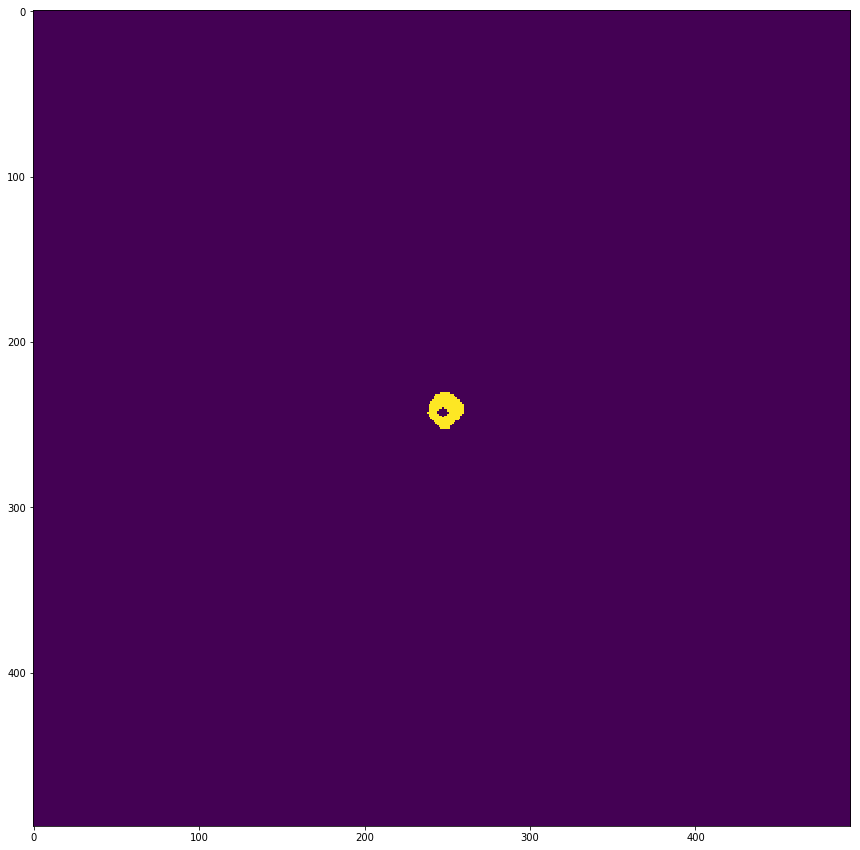

'Medan_059_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


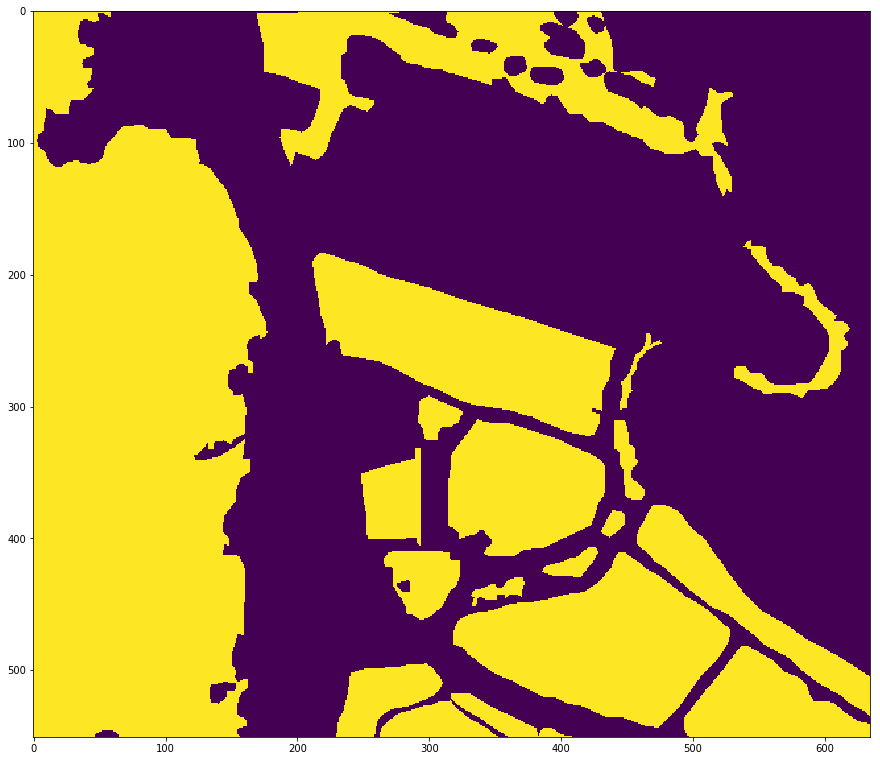

'Jakarta_150_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


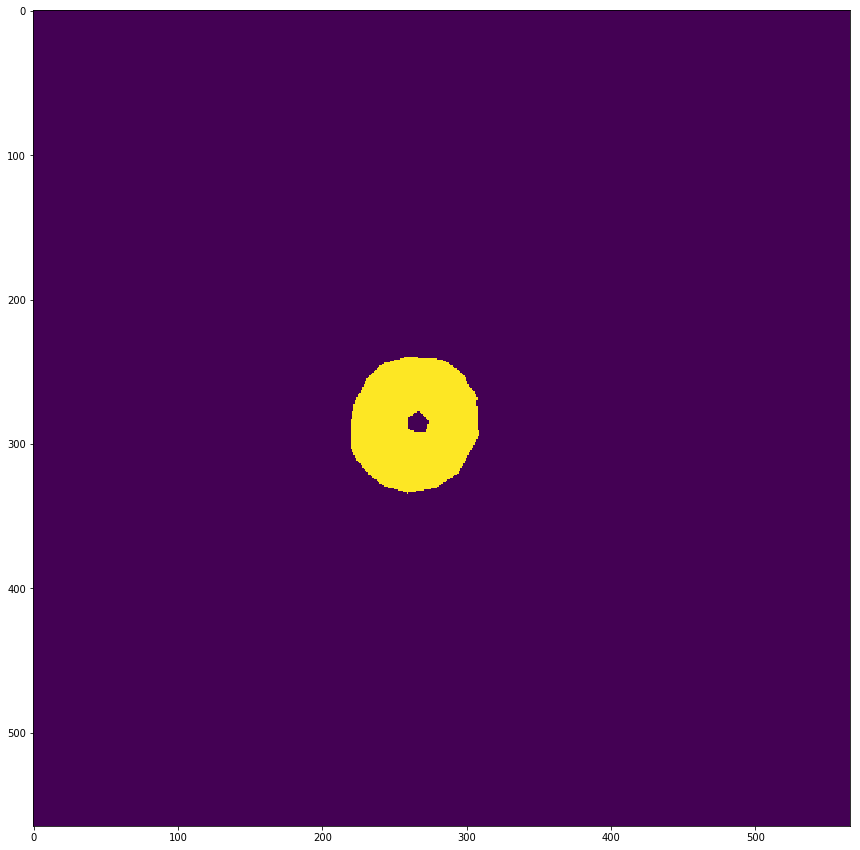

'Jakarta_635_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:32631.
 Convert vector and raster to the same CRS.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


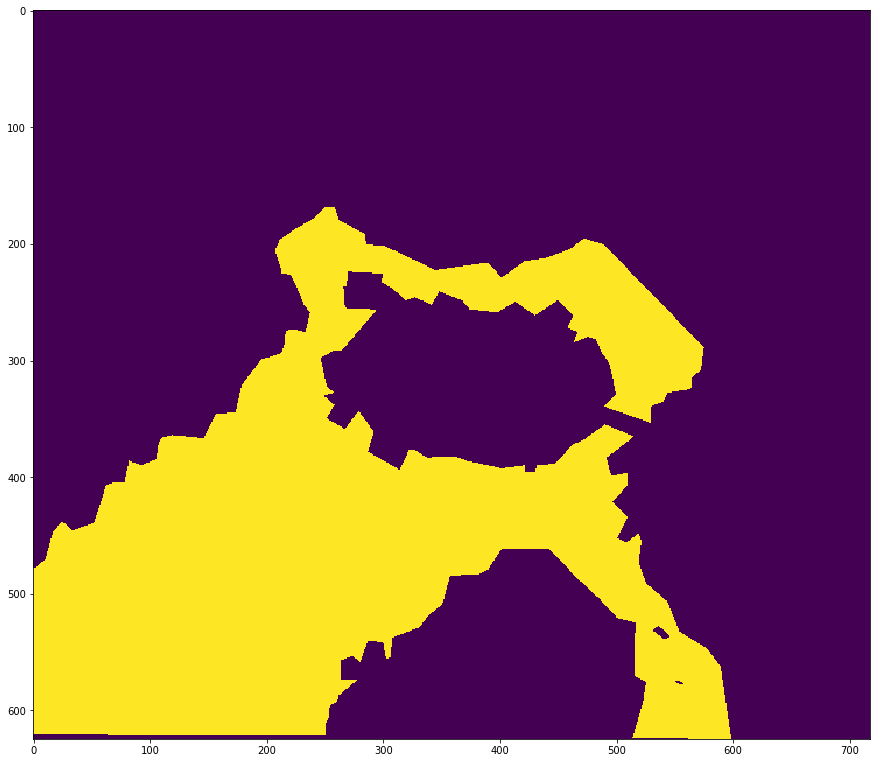

'Medan_307_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


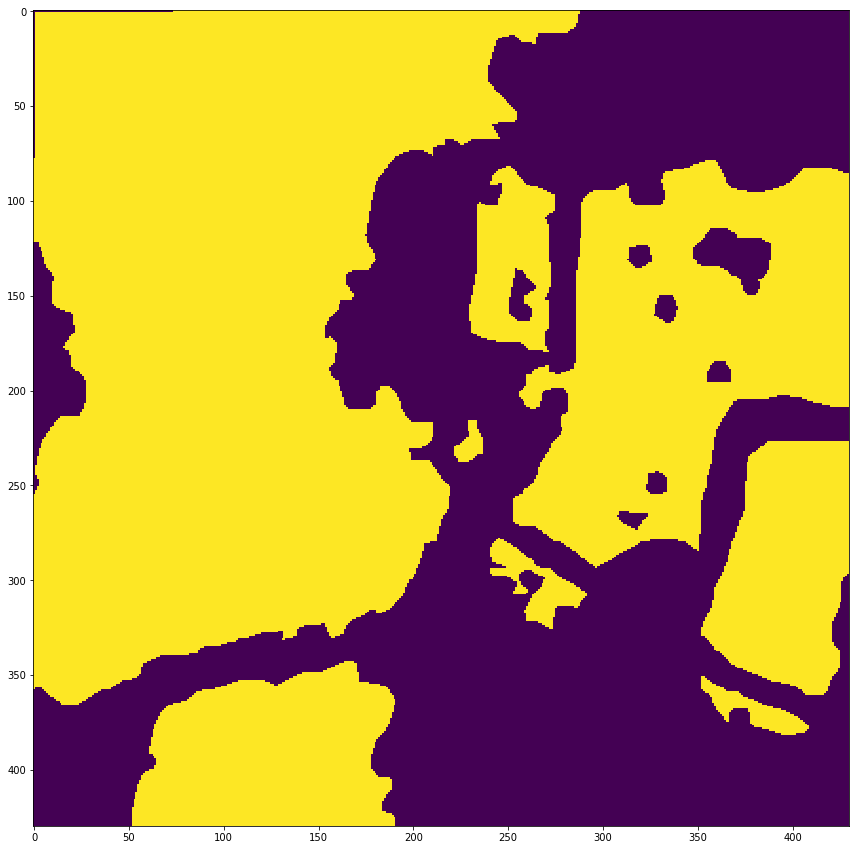

'Jakarta_422_pansharpen_True_2019-08-08_03:27_10300100989CC900_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


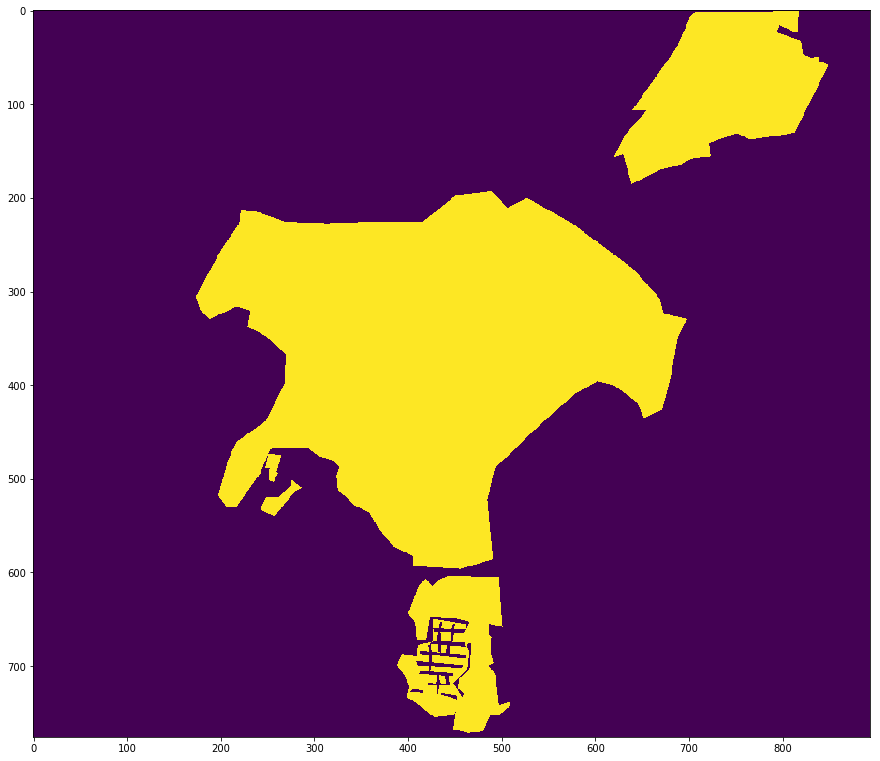

'Jakarta_359_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


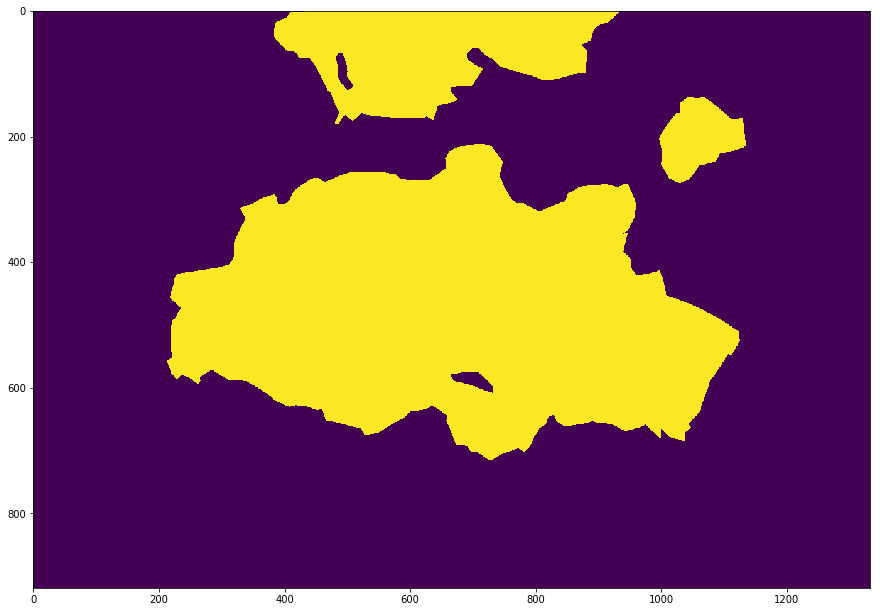

'Jakarta_597_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


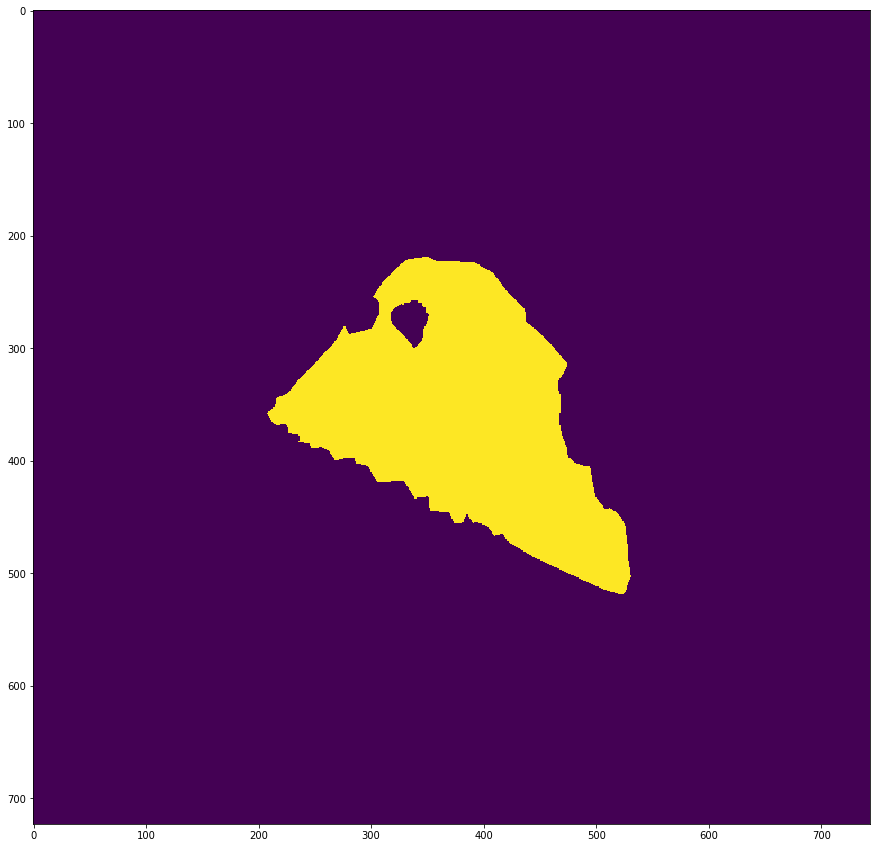

'Jakarta_249_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


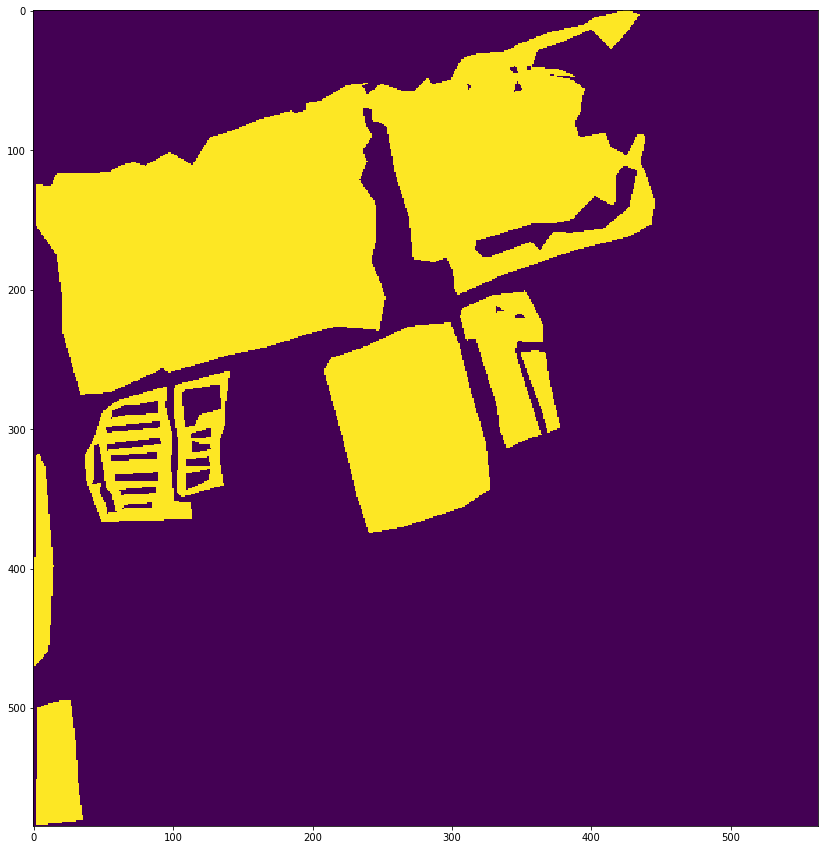

'Medan_217_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


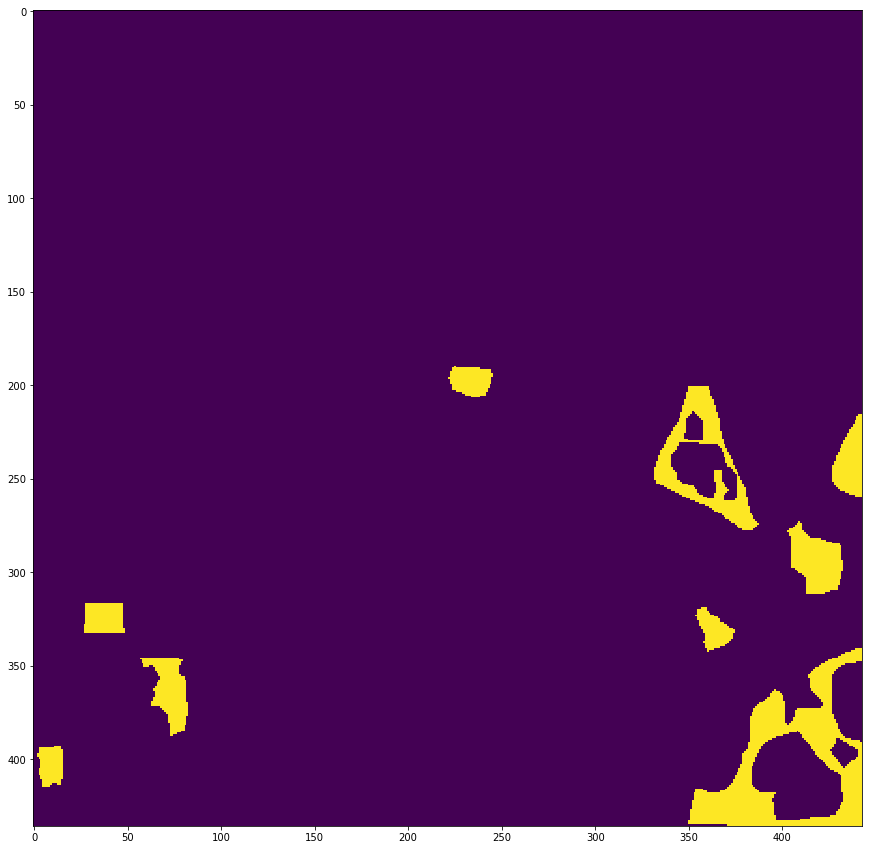

'Jakarta_669_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


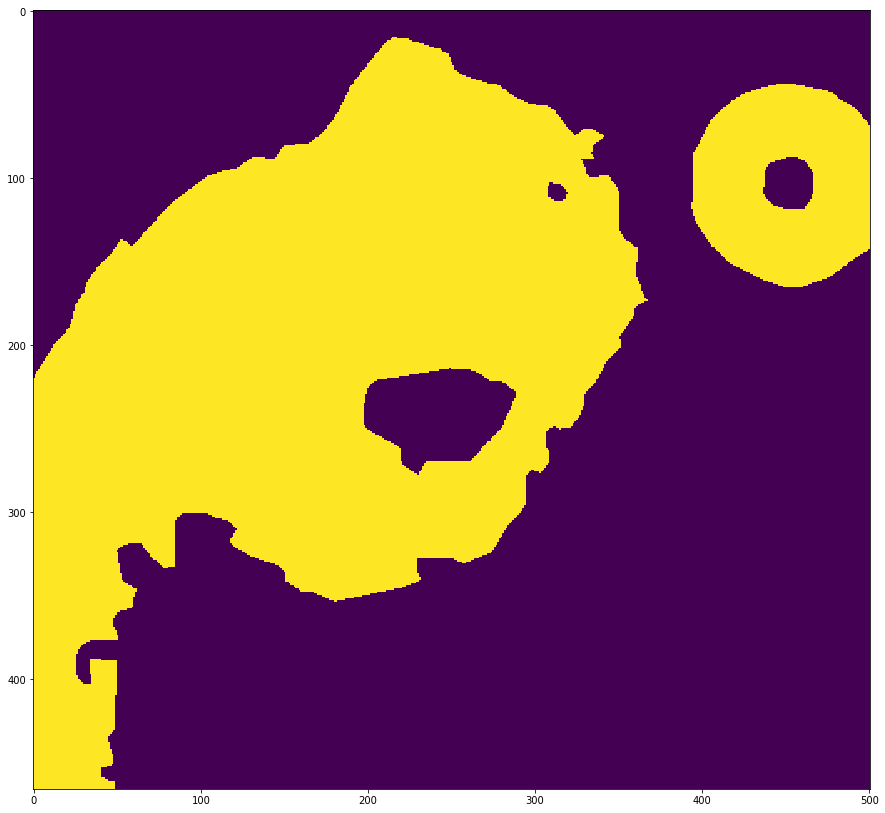

'Denpasar_012_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


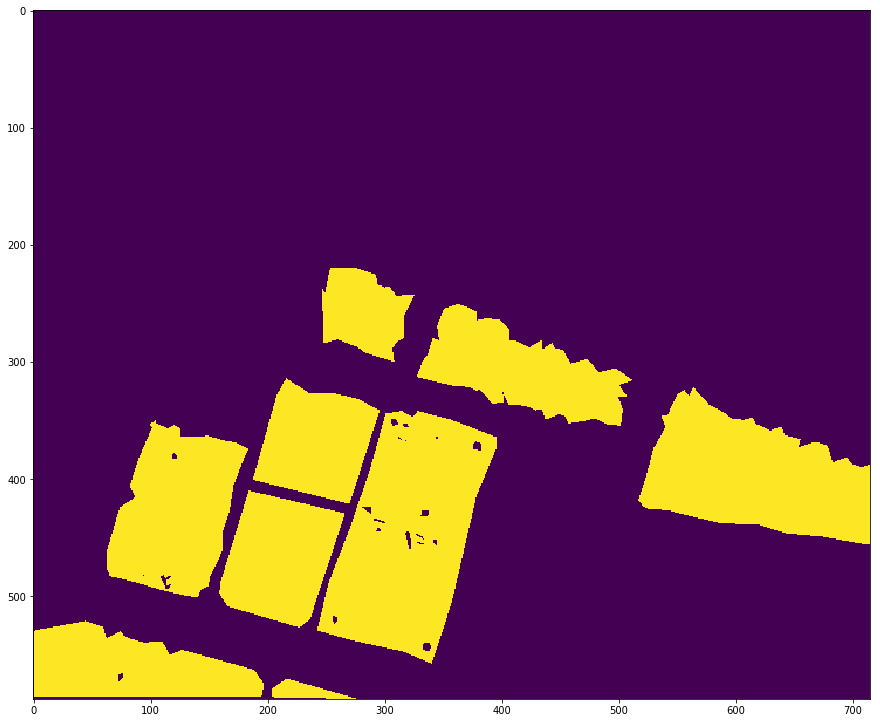

'Jakarta_230_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


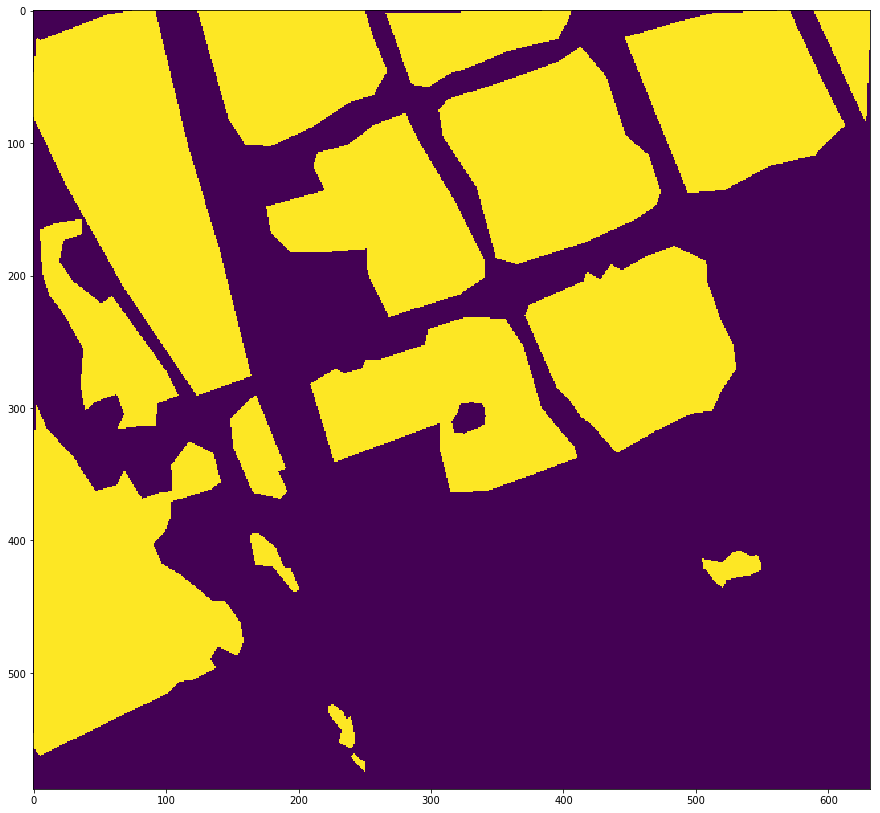

'Jakarta_072_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


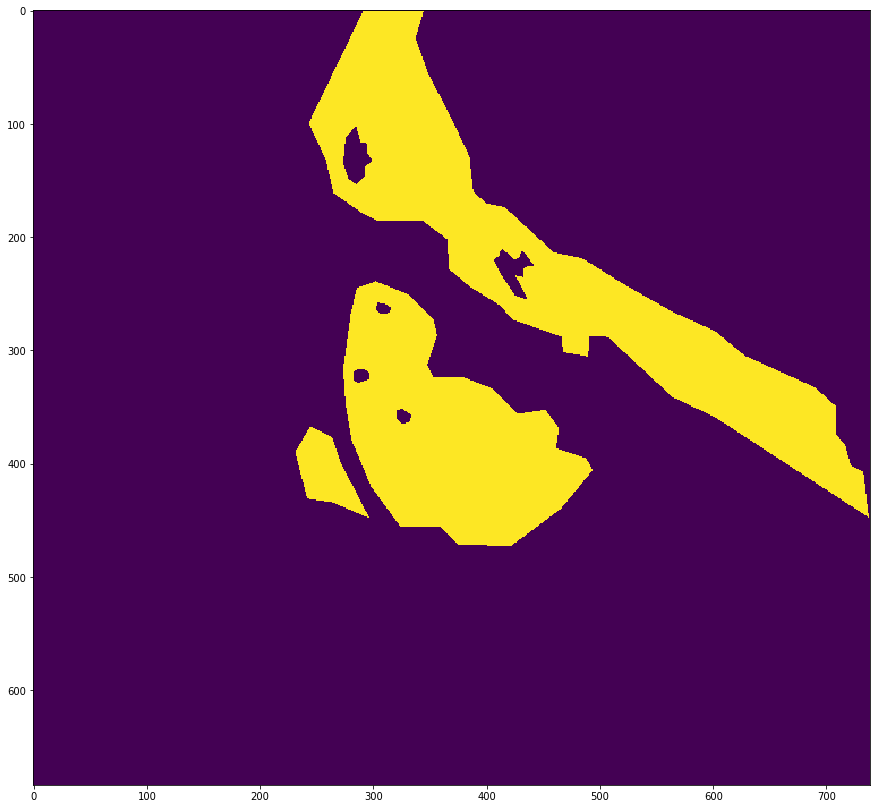

'Denpasar_039_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


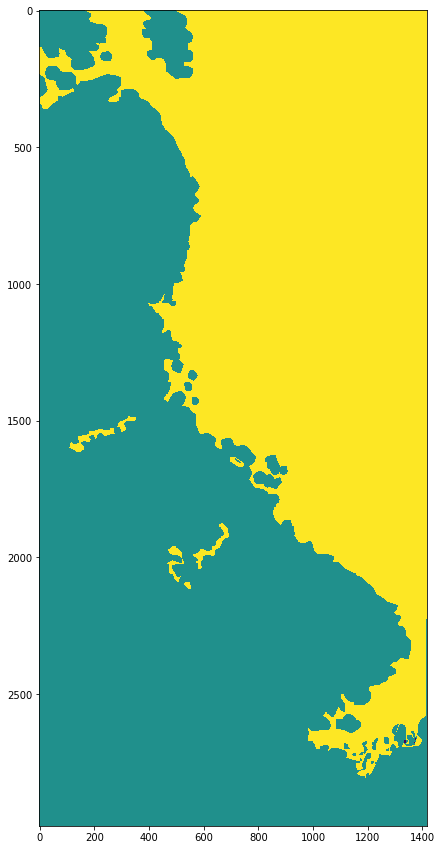

'Jakarta_508_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


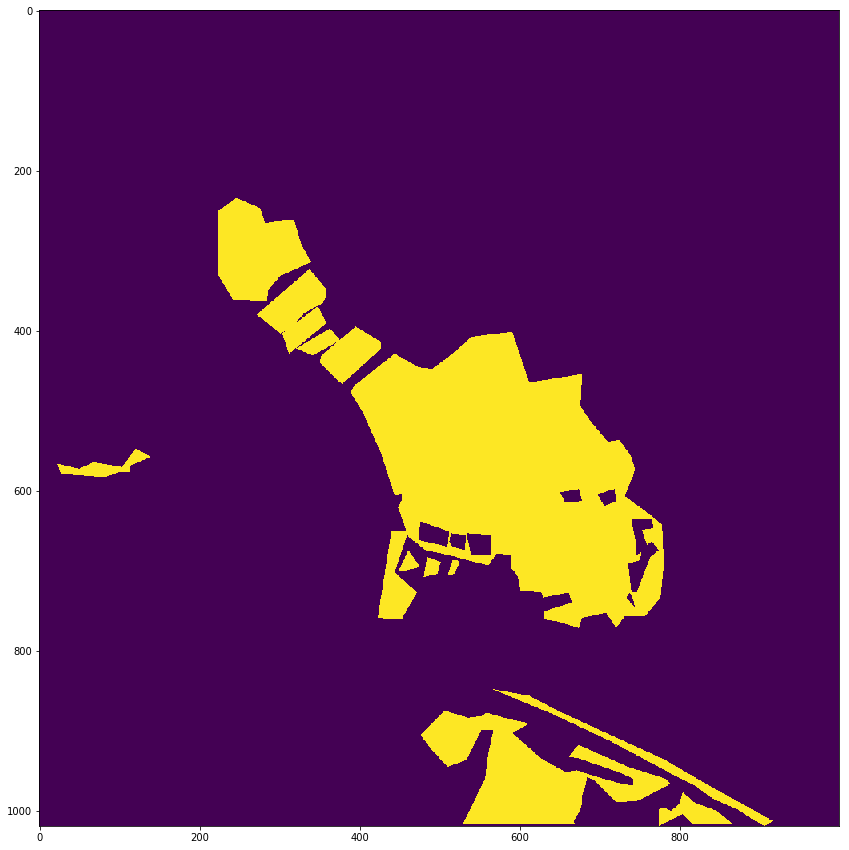

'Denpasar_043_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


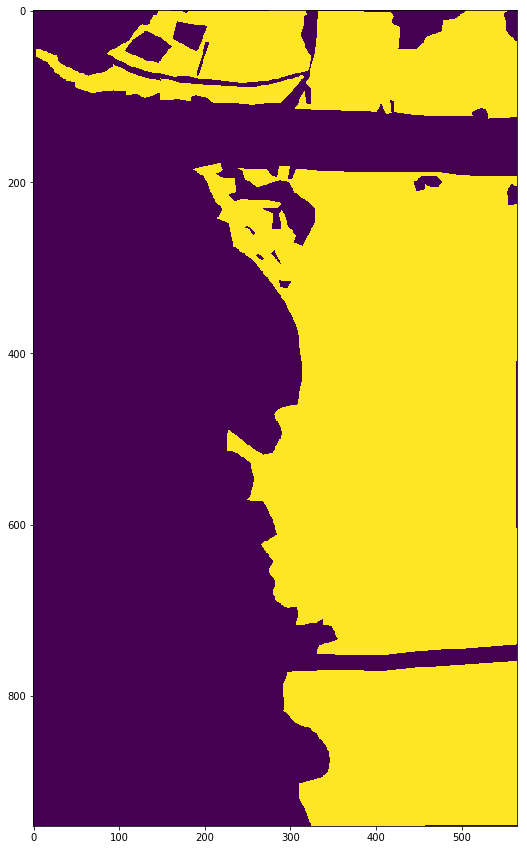

'Denpasar_035_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


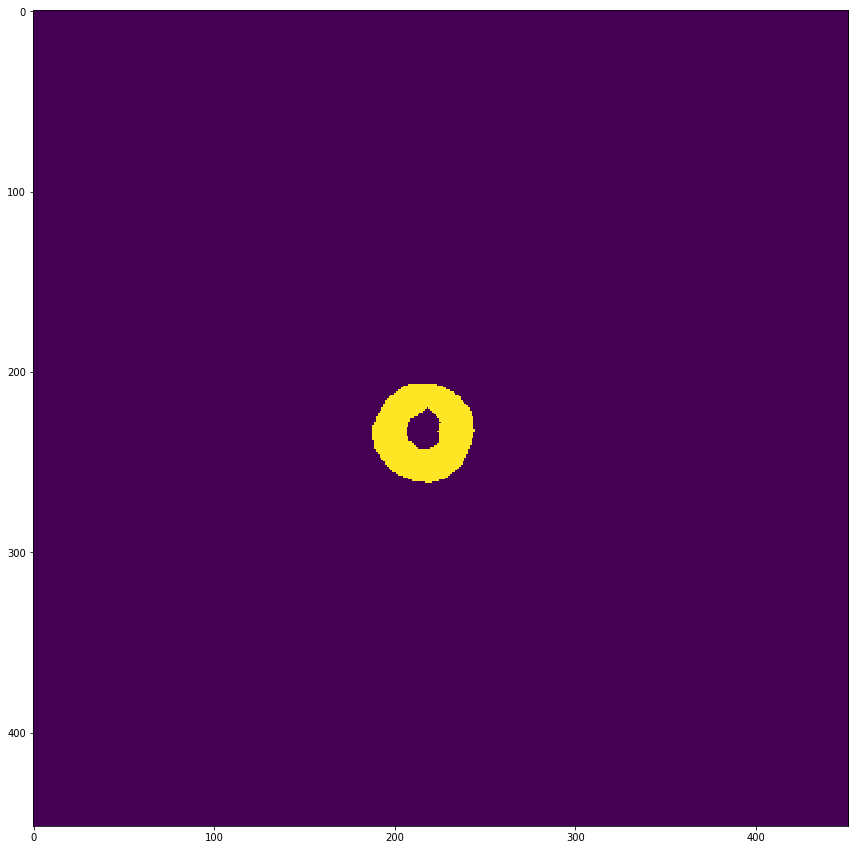

'Jakarta_415_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


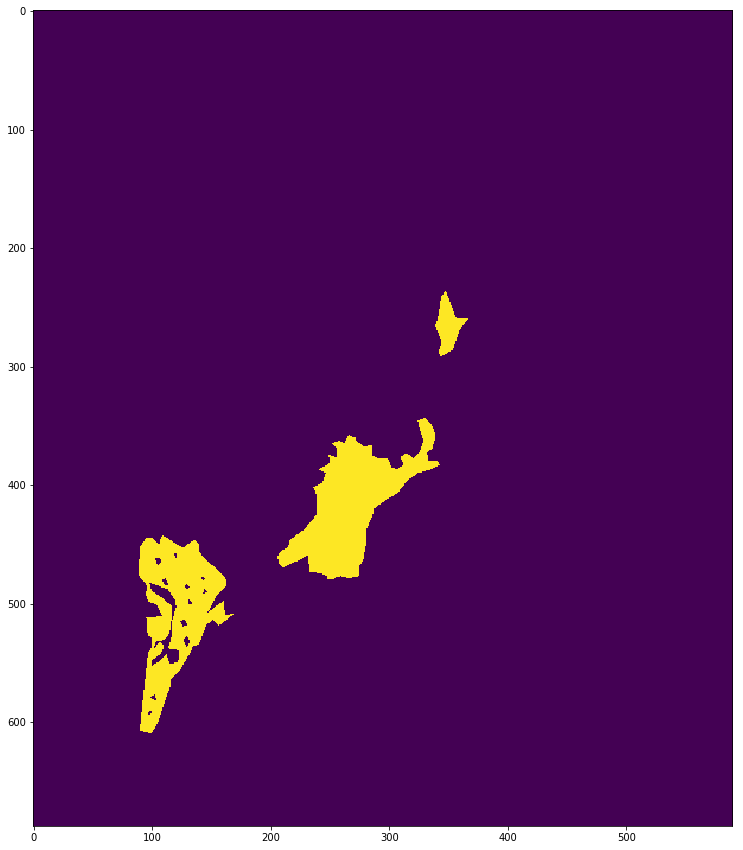

'Denpasar_054_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


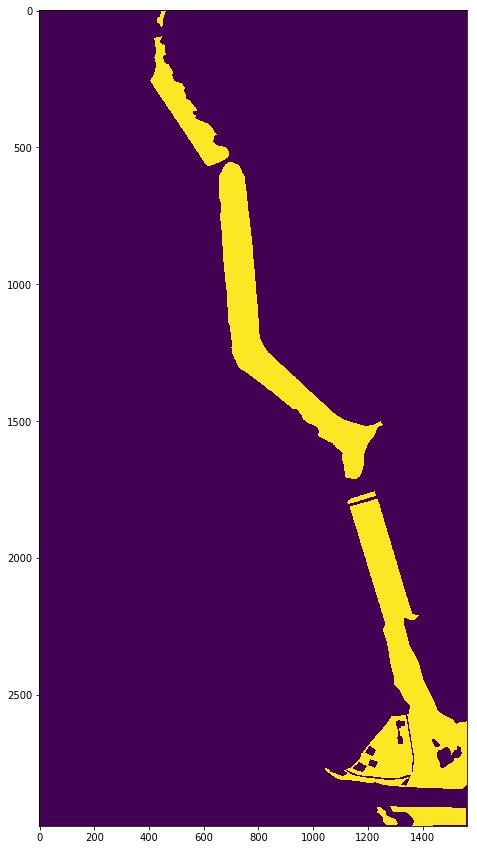

'Jakarta_243_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


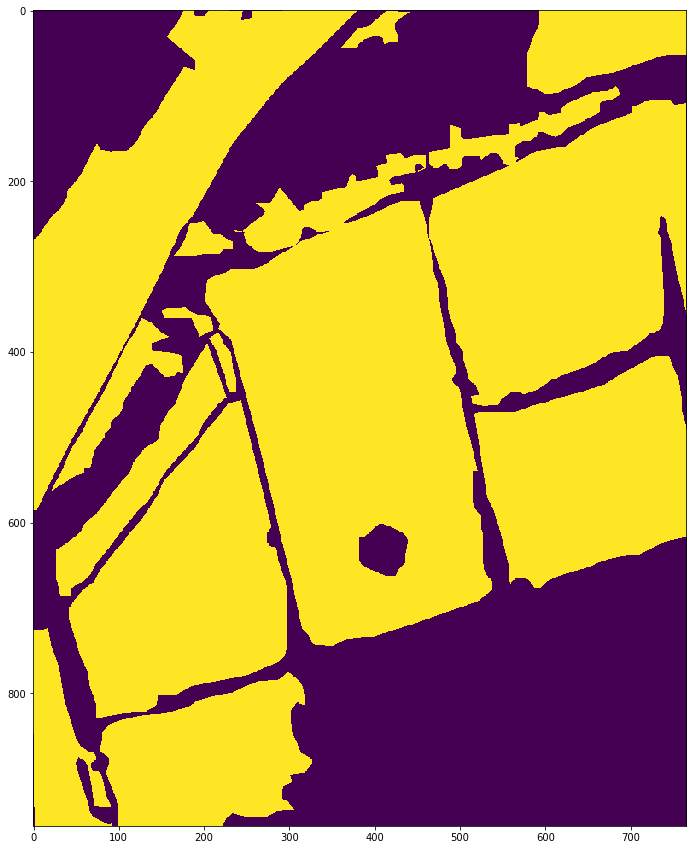

'Medan_245_pansharpen_True_2020-03-03_04:04_10300100A312C200_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


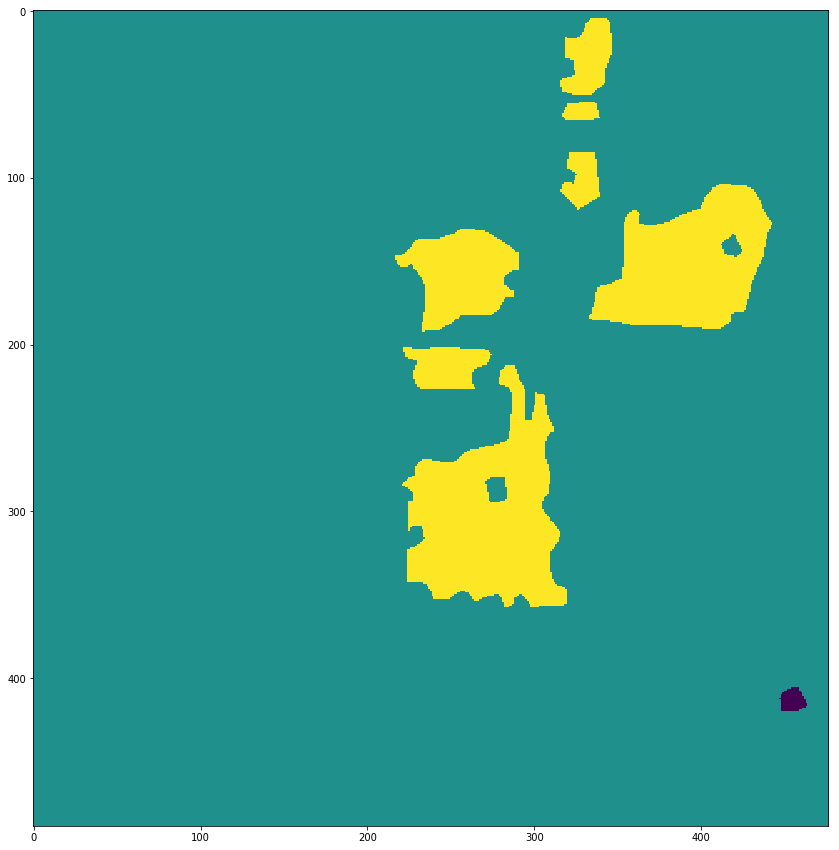

'Jakarta_235_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


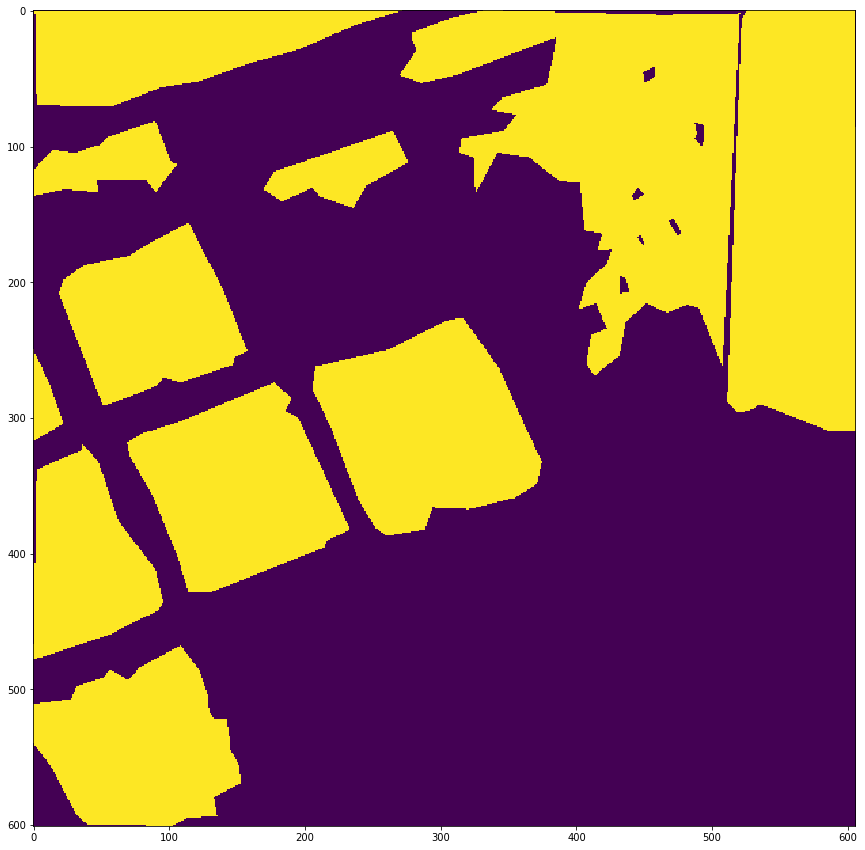

'Jakarta_352_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


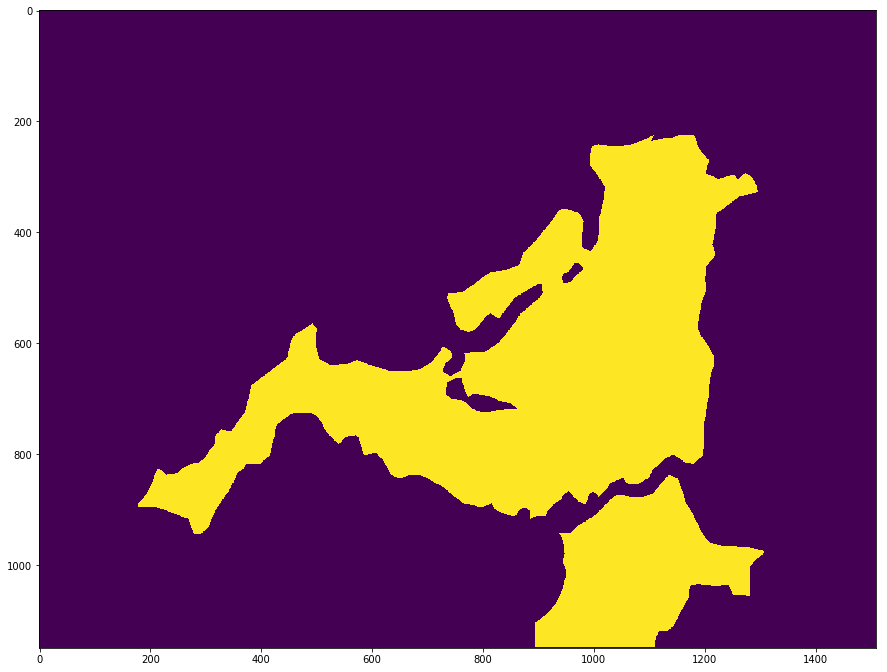

'Jakarta_000_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


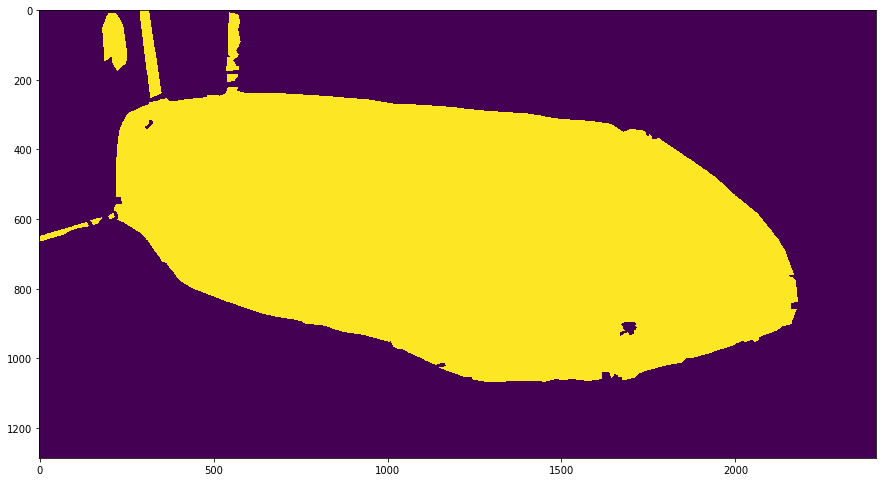

'Jakarta_252_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


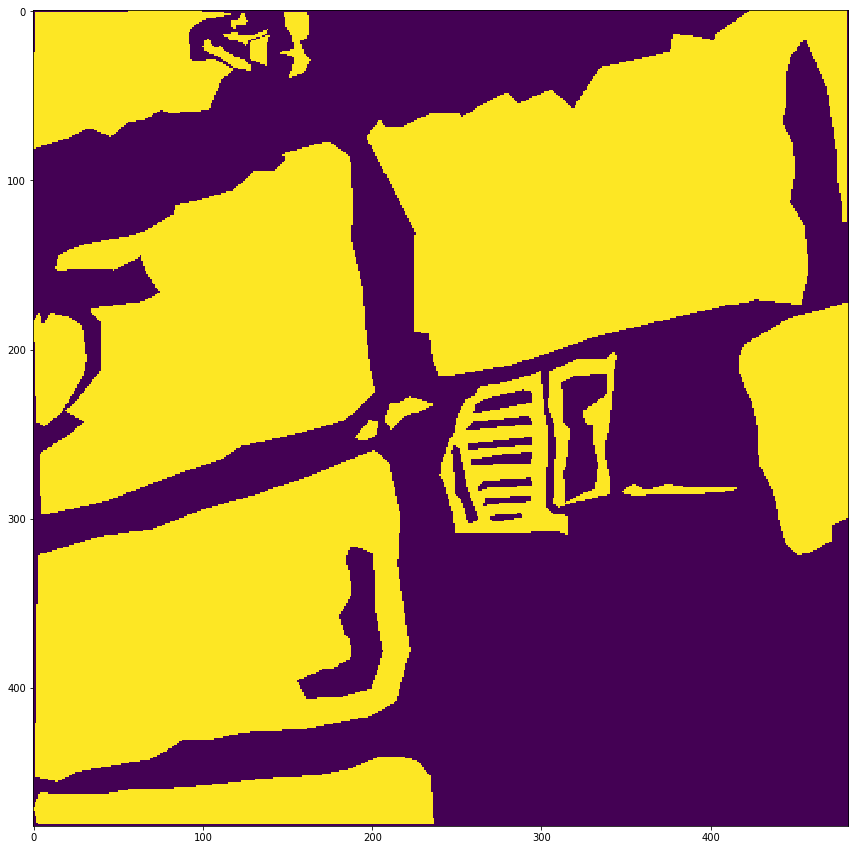

'Jakarta_221_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


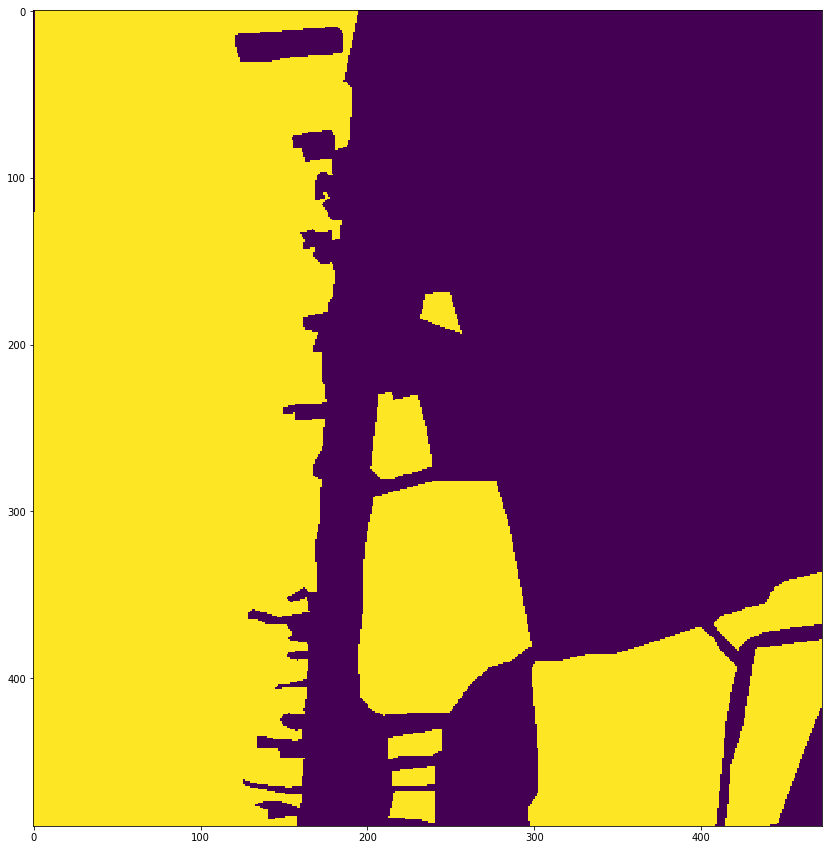

'Medan_212_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


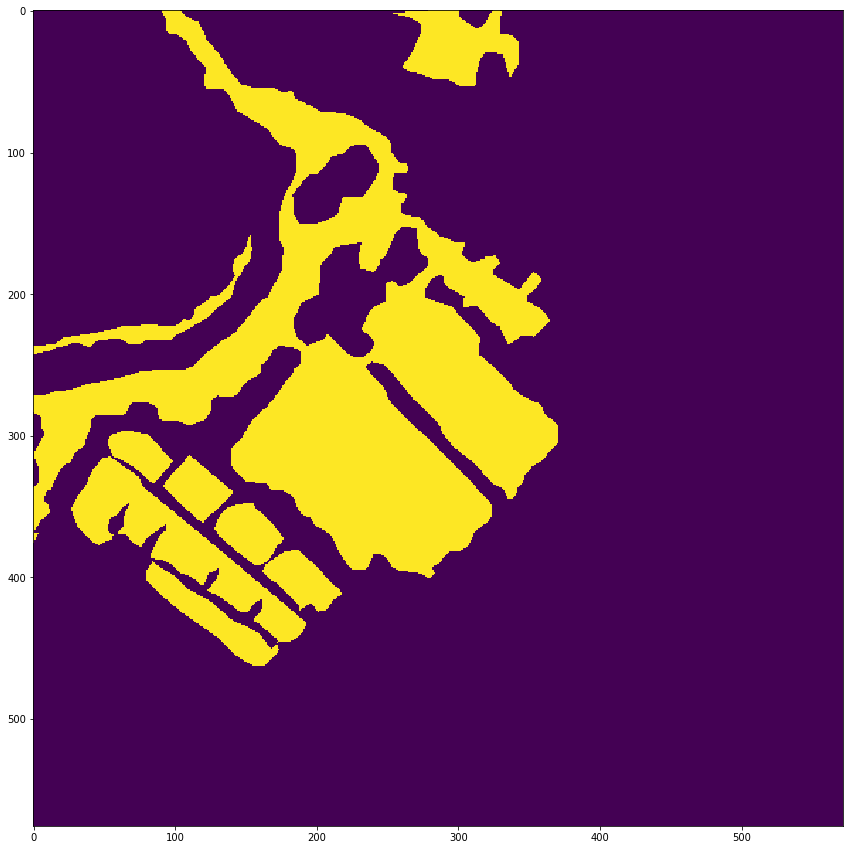

'Jakarta_226_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


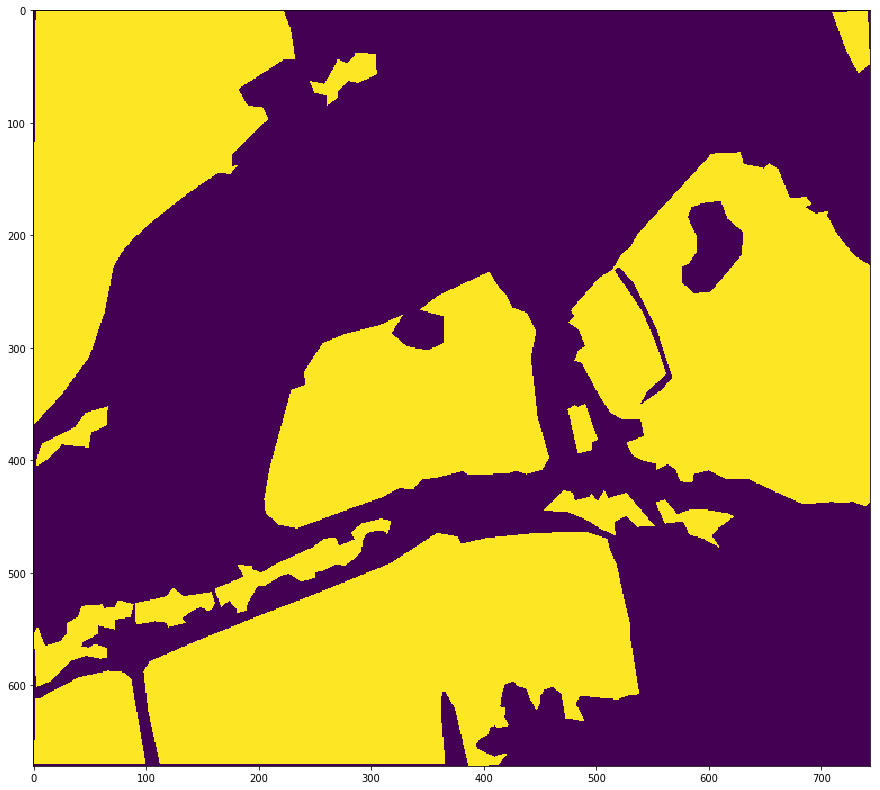

'Jakarta_254_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


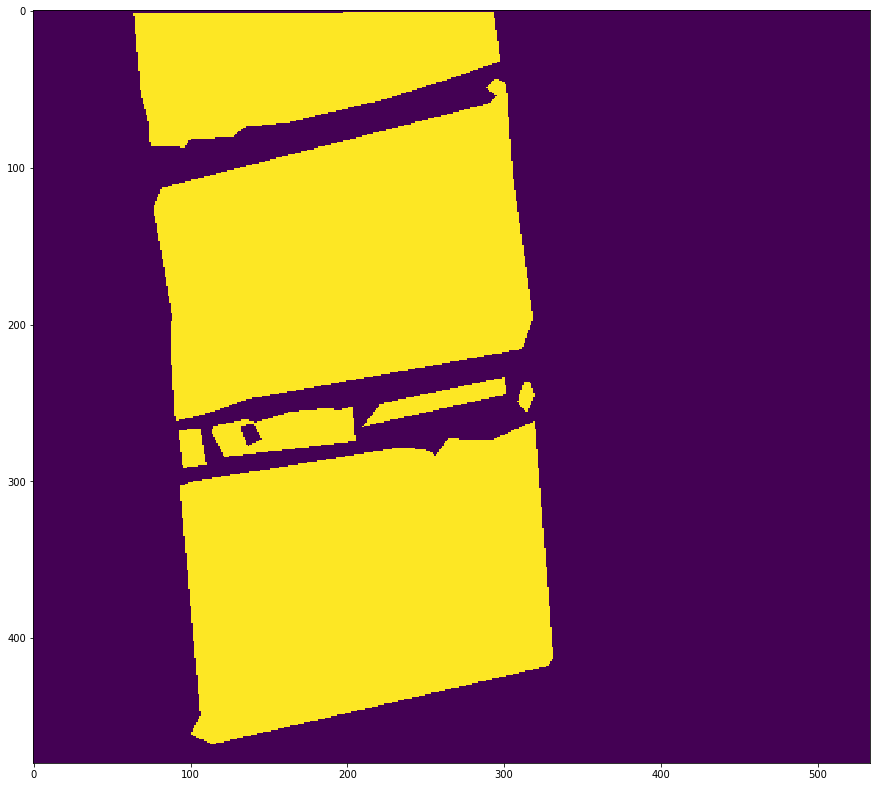

'Jakarta_543_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


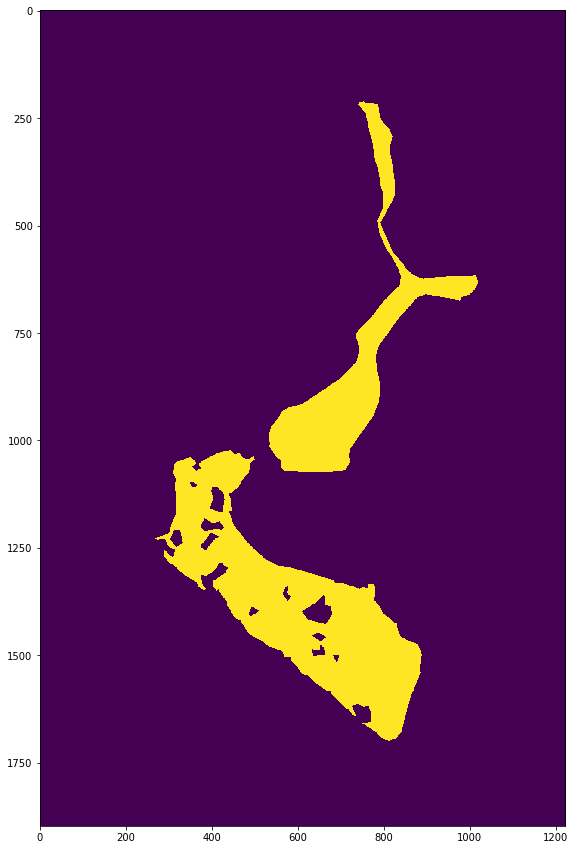

'Medan_260_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


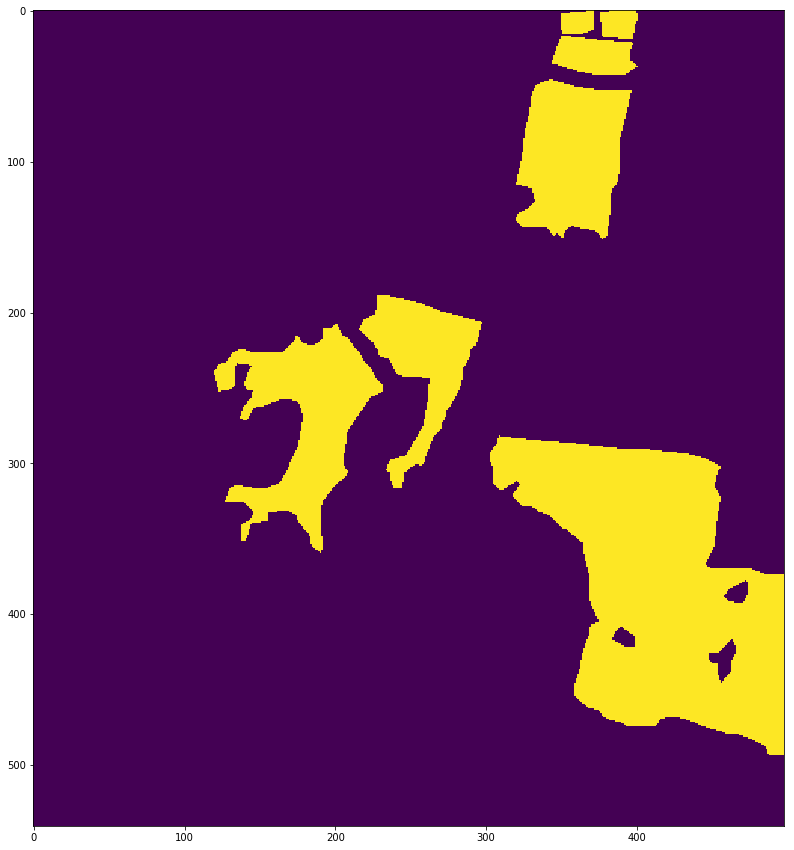

'Cilegon_007_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


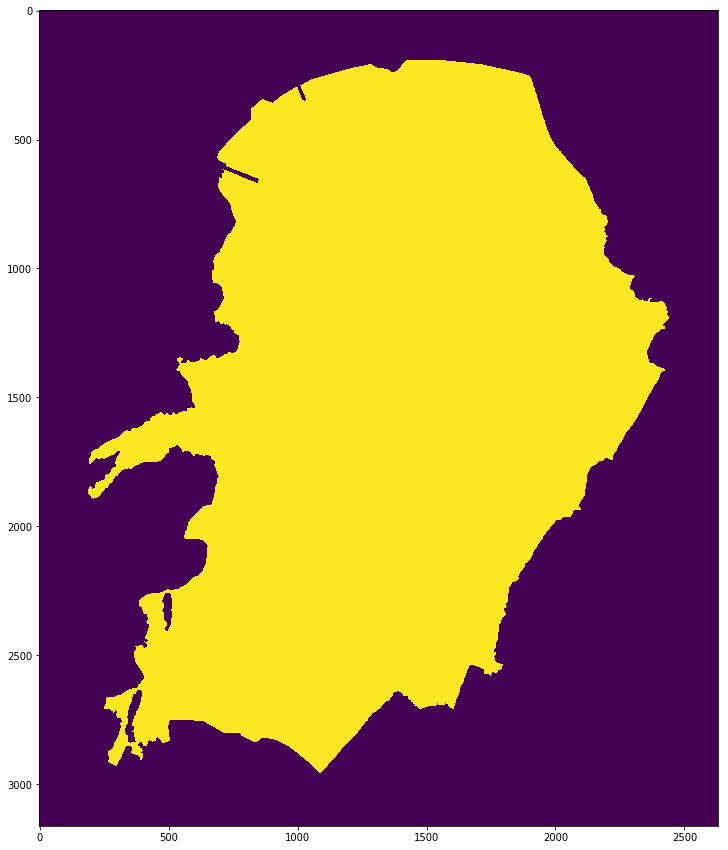

'Denpasar_006_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


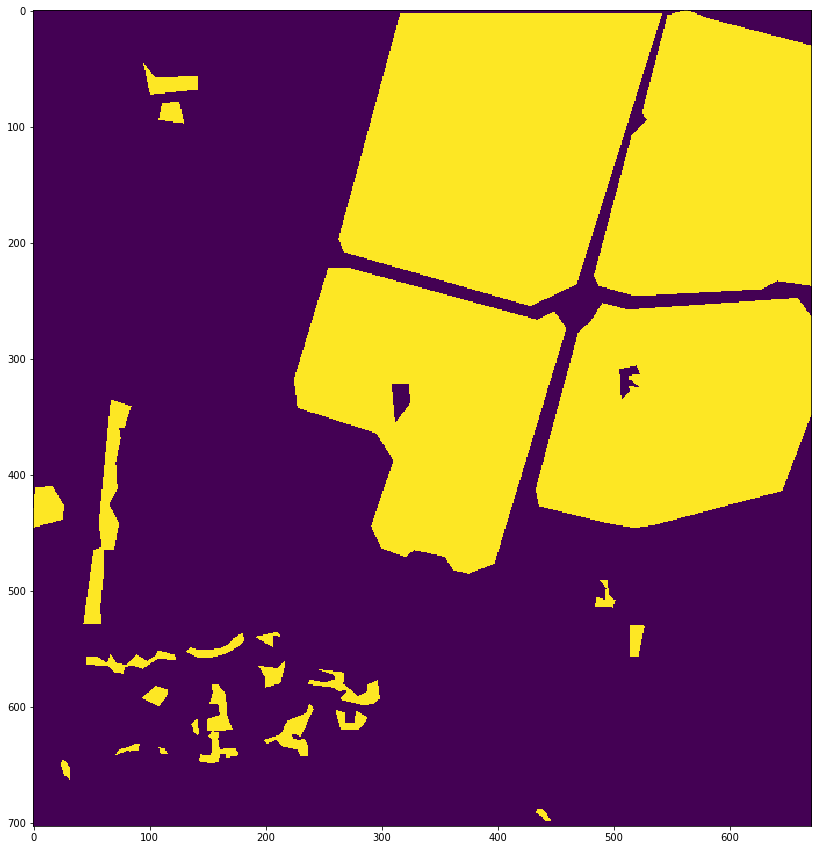

'Jakarta_626_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


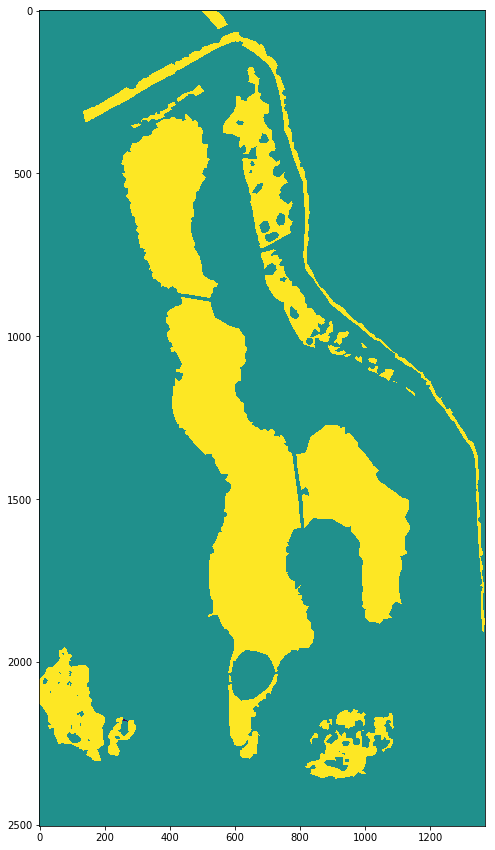

'Cilegon_013_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


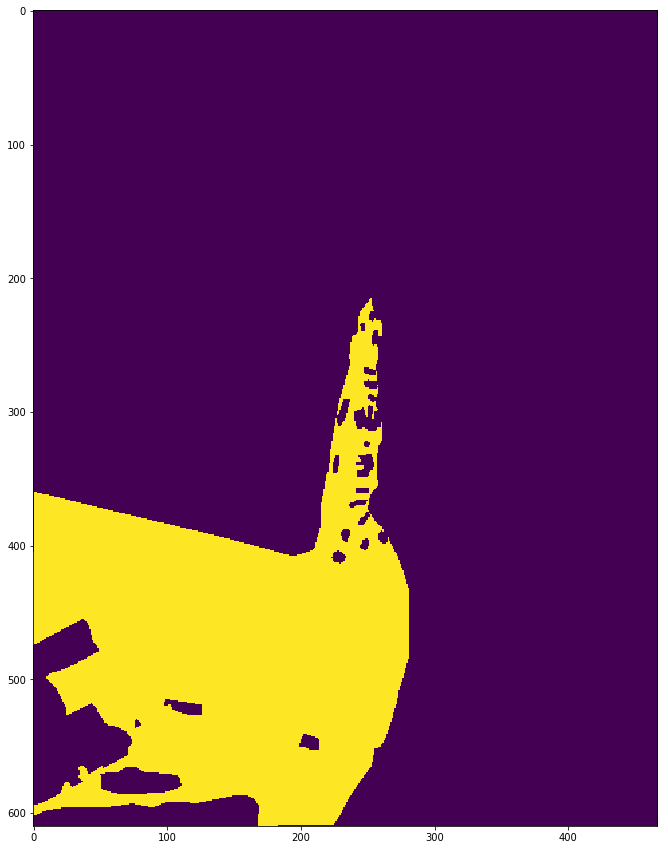

'Denpasar_016_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


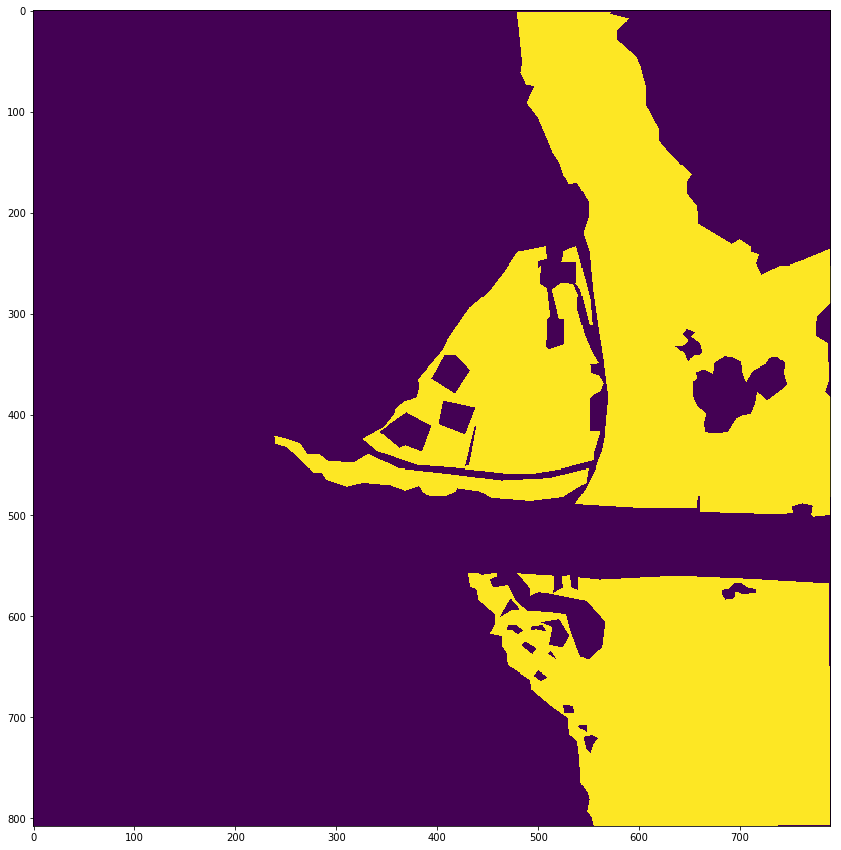

'Jakarta_234_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


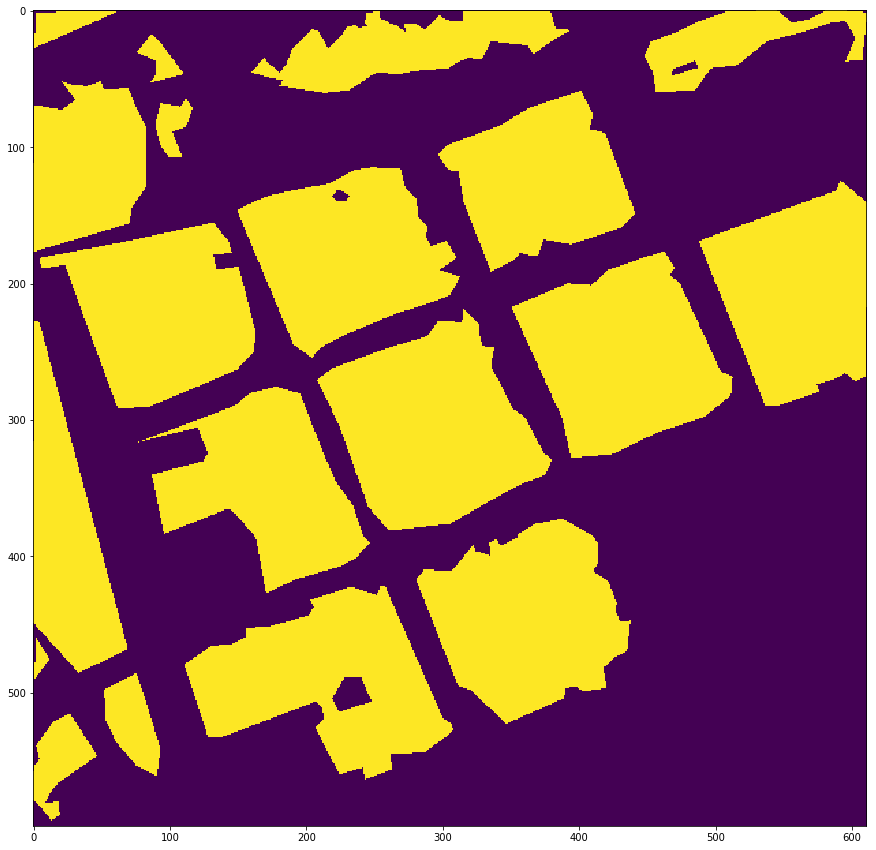

'Medan_311_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


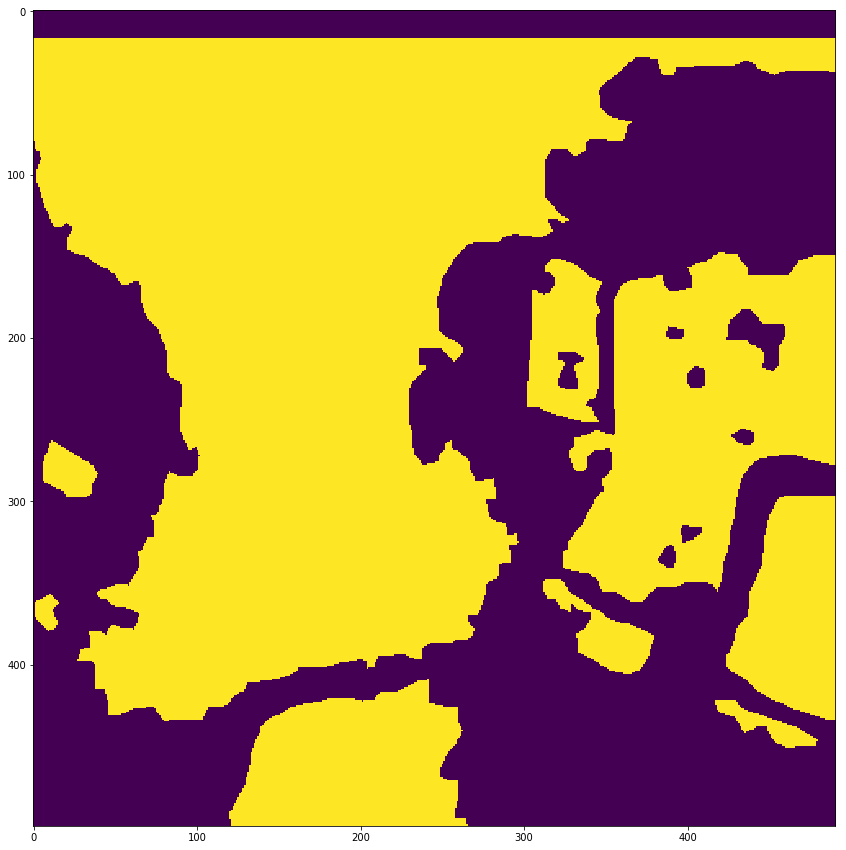

'Jakarta_353_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


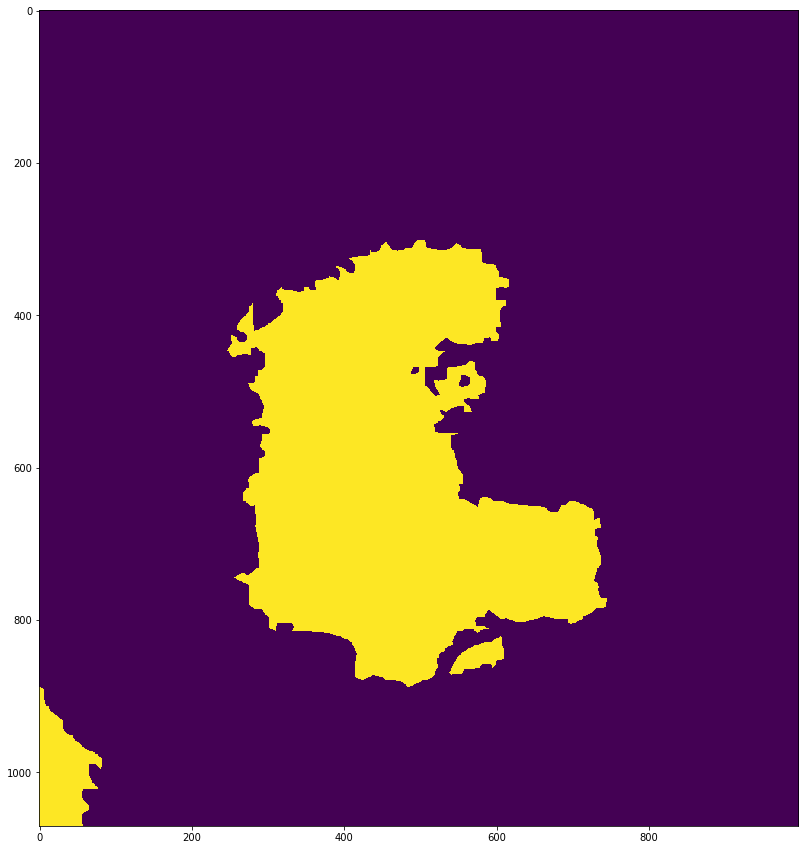

'Denpasar_023_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32750, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


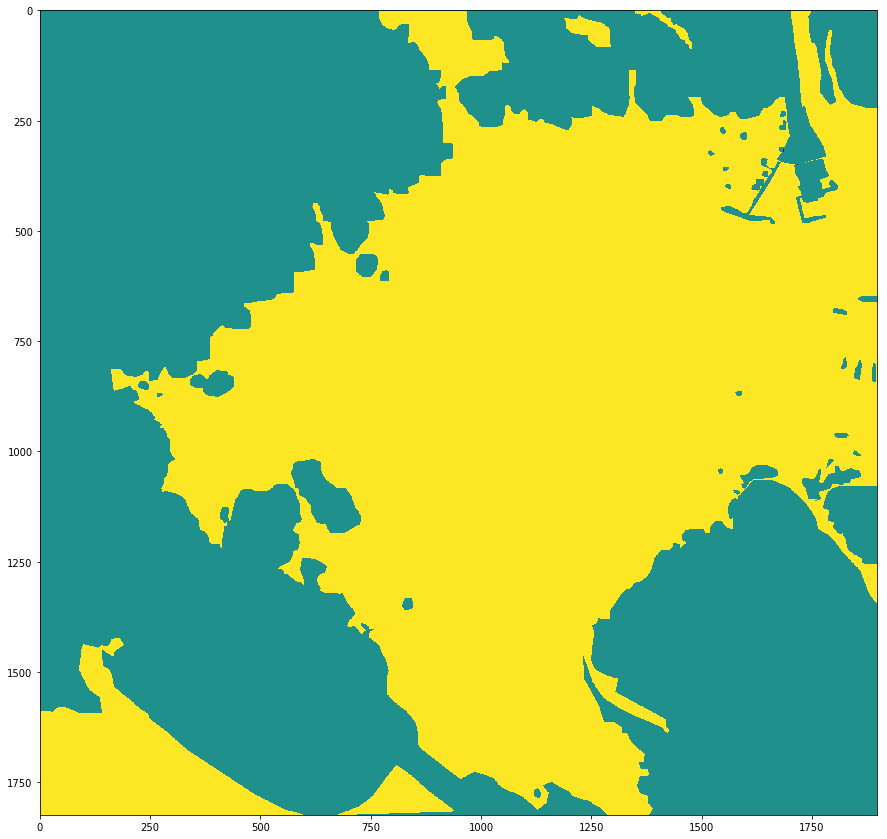

'Jakarta_239_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


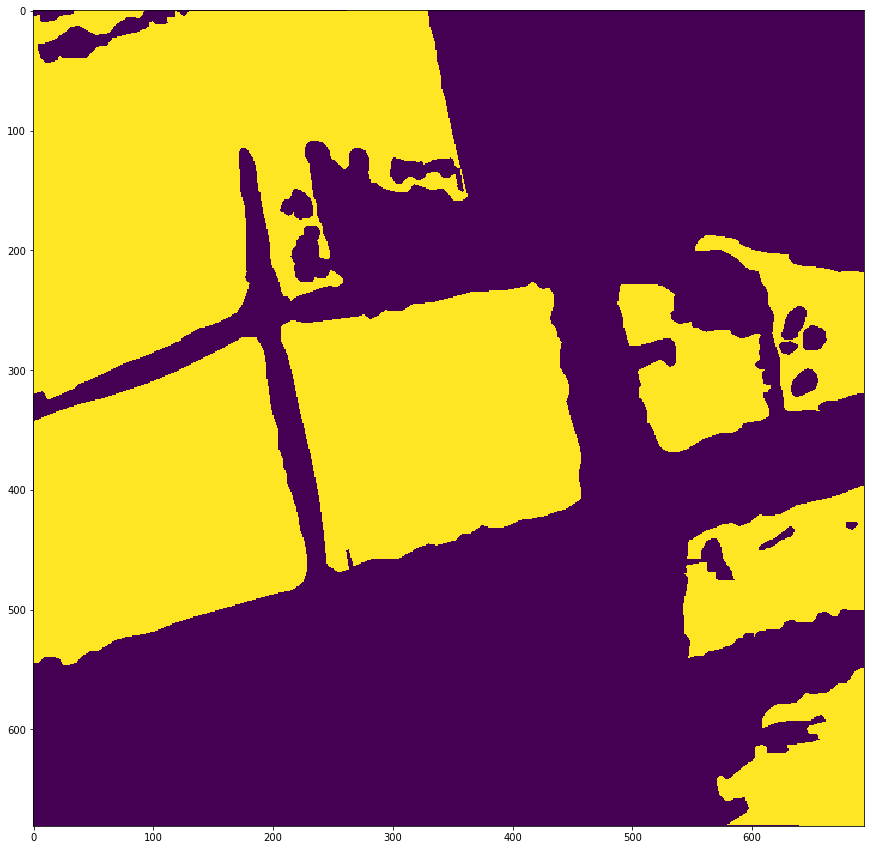

'Jakarta_344_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


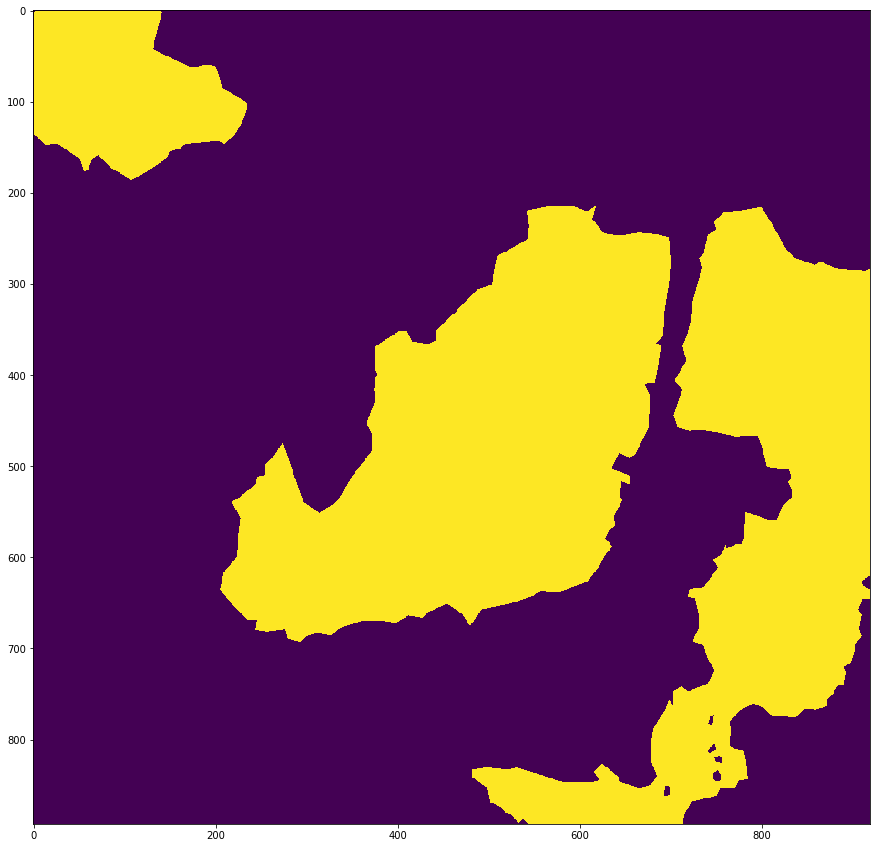

'Jakarta_349_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


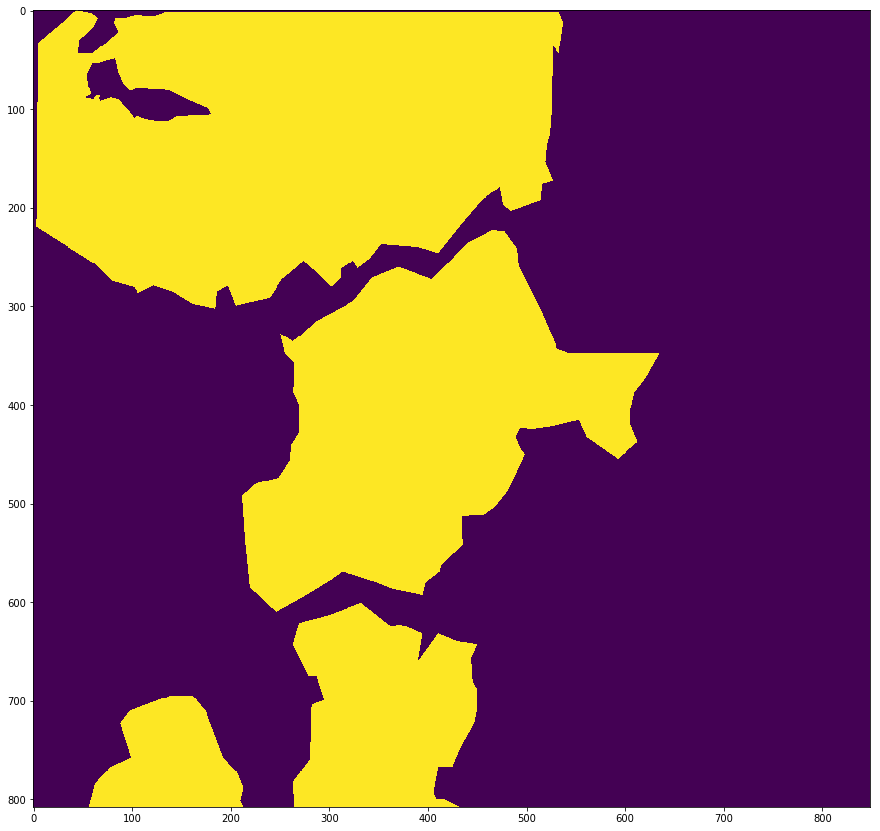

'Jakarta_218_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


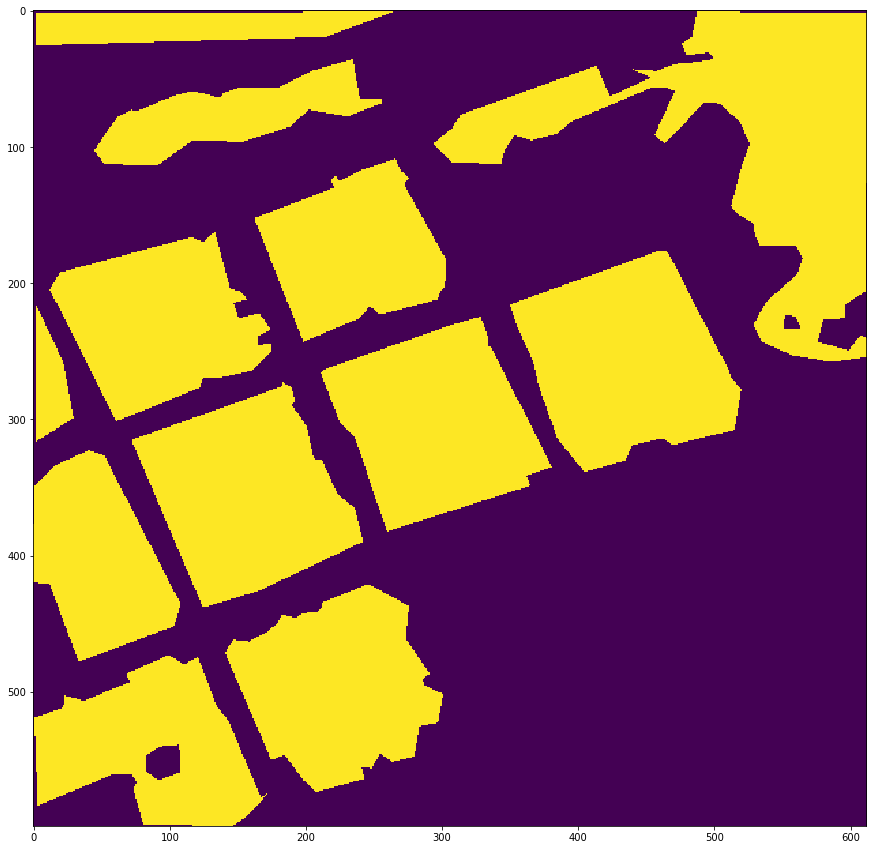

'Jakarta_399_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


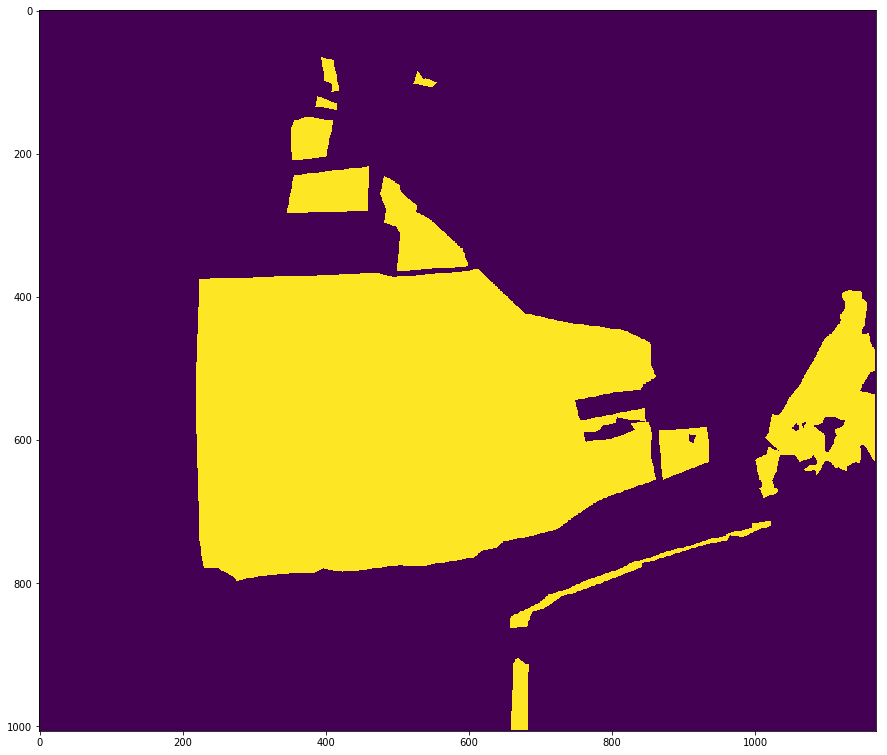

'Jakarta_224_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


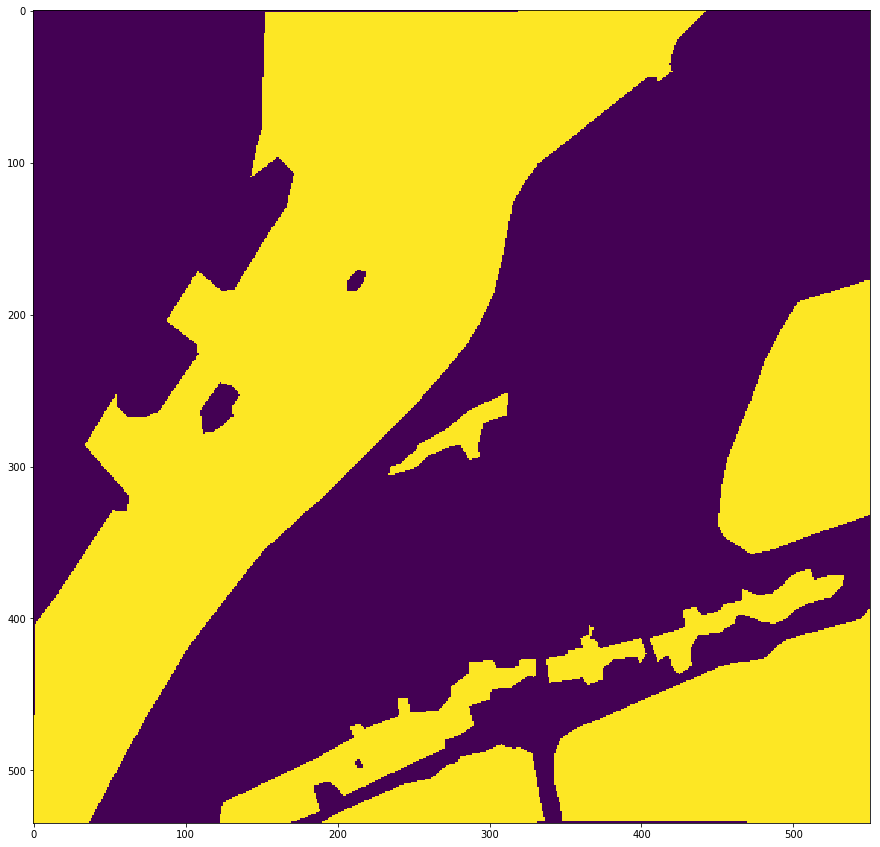

'Jakarta_641_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:32631.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


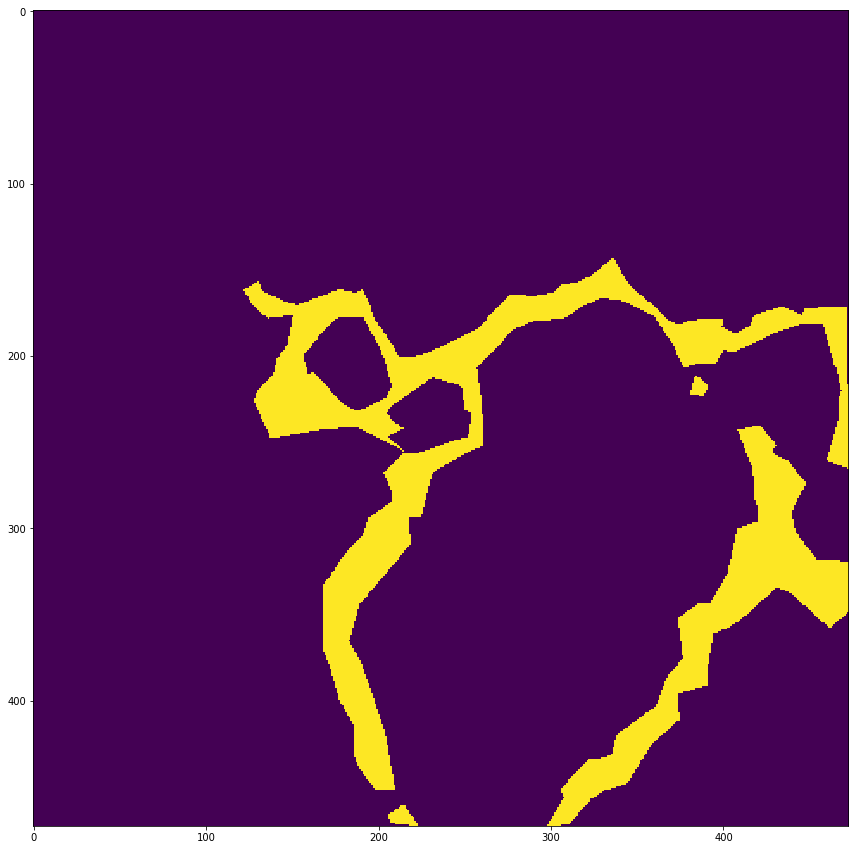

'Jakarta_261_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


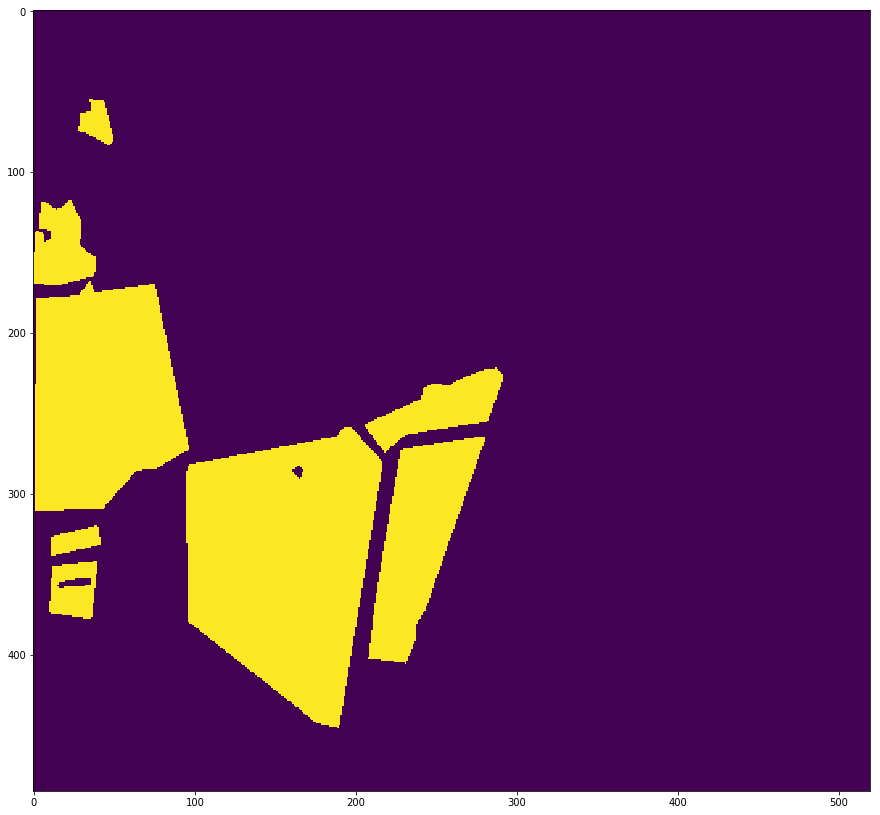

'Jakarta_335_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


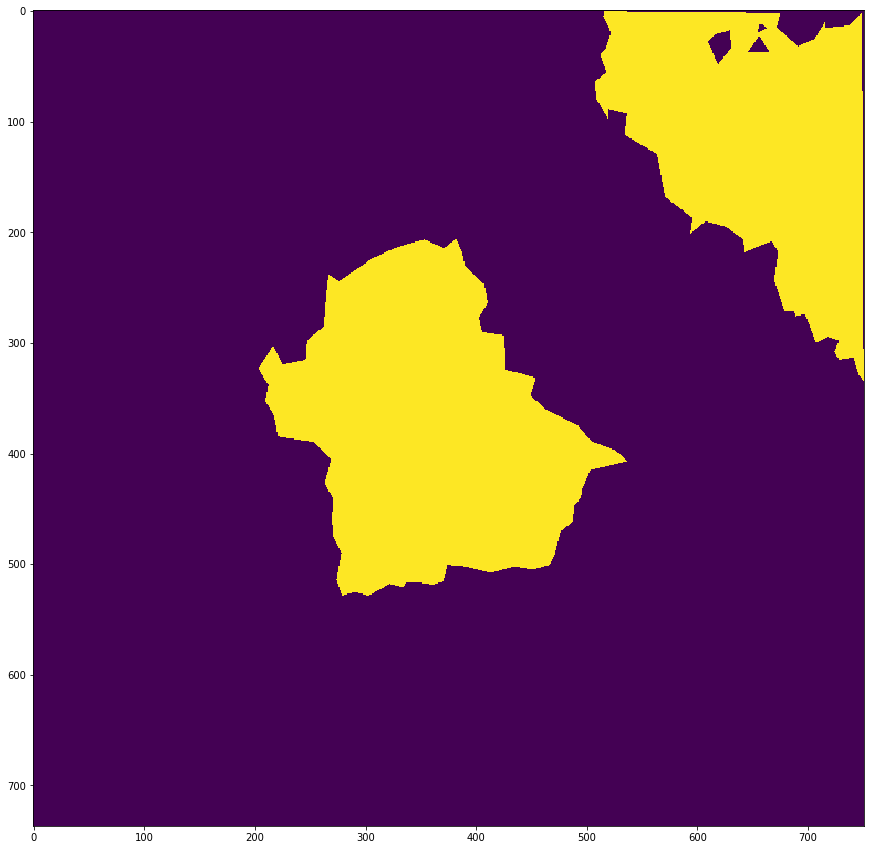

'Jakarta_500_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


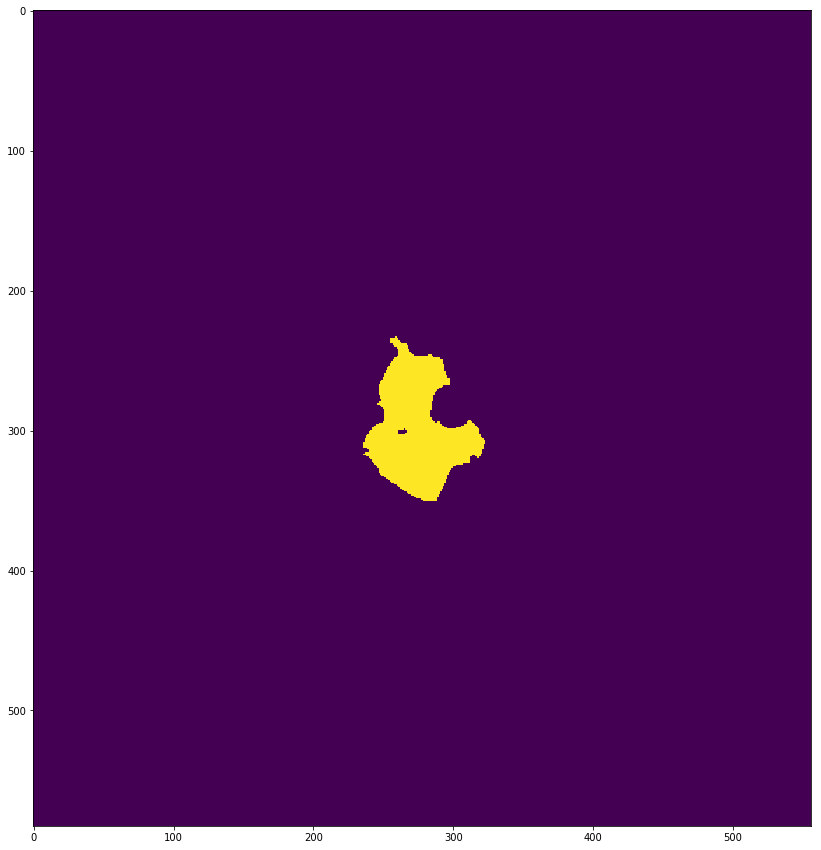

'Jakarta_228_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


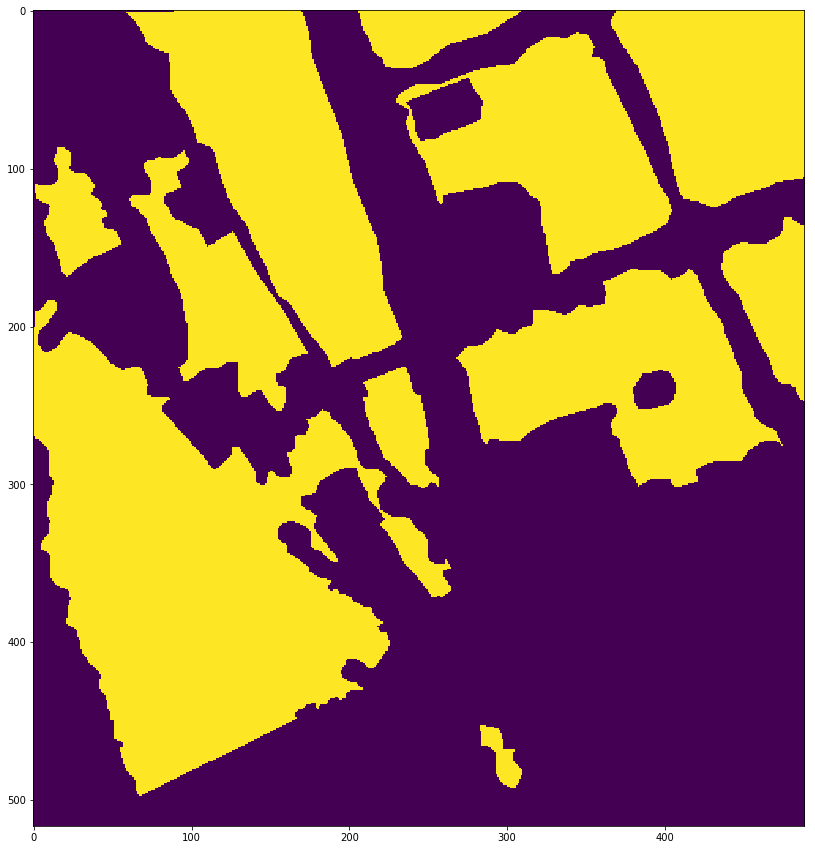

'Jakarta_646_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


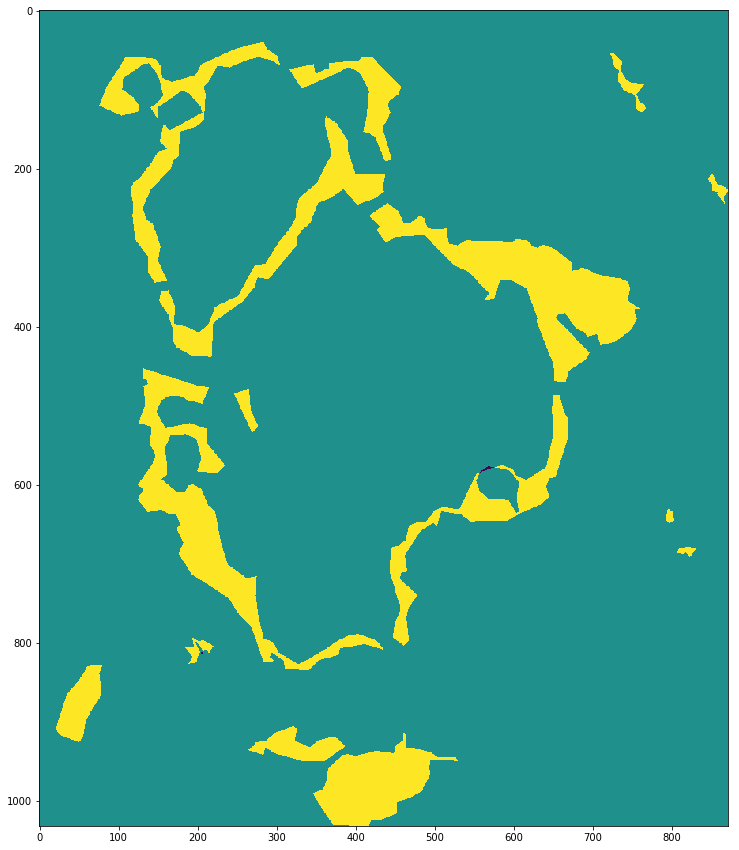

'Medan_028_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32647, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


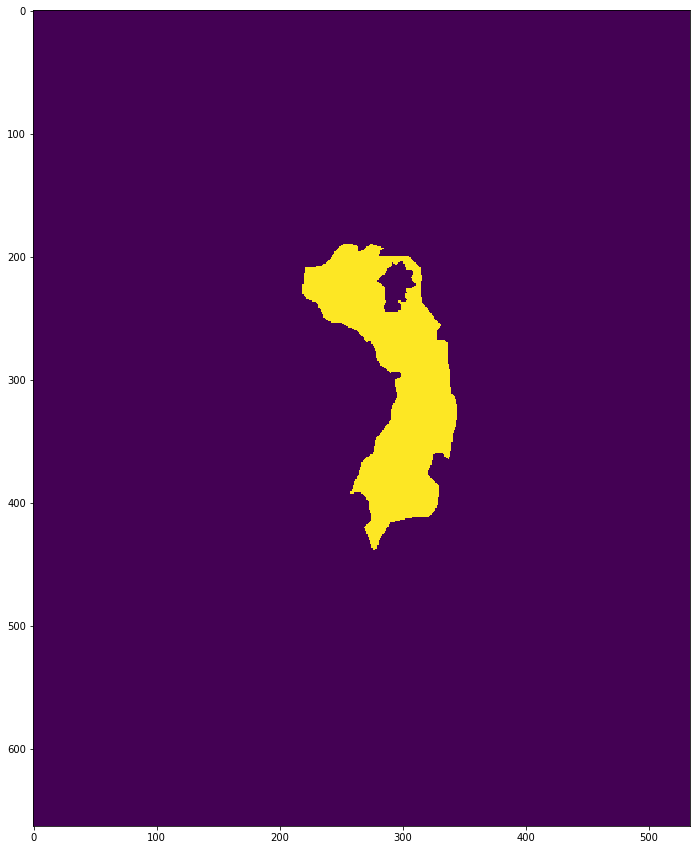

'Jakarta_351_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


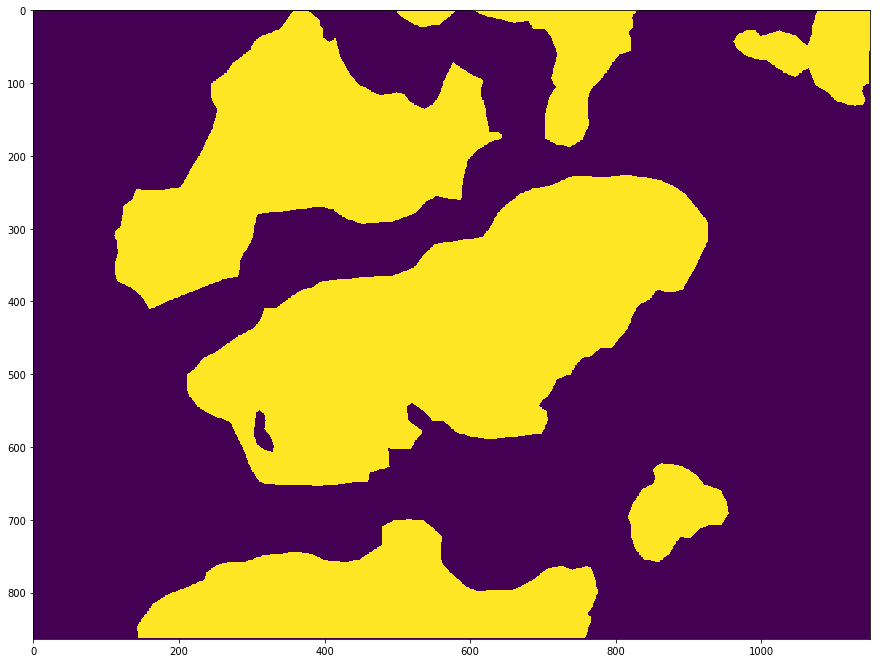

'Jakarta_186_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


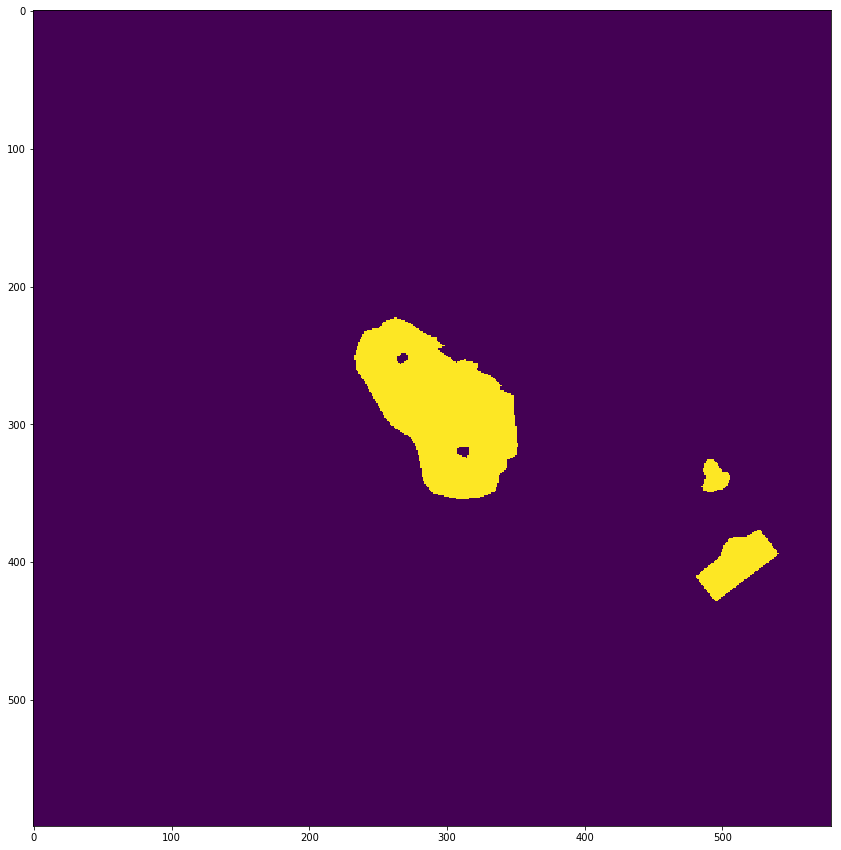

'Jakarta_337_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


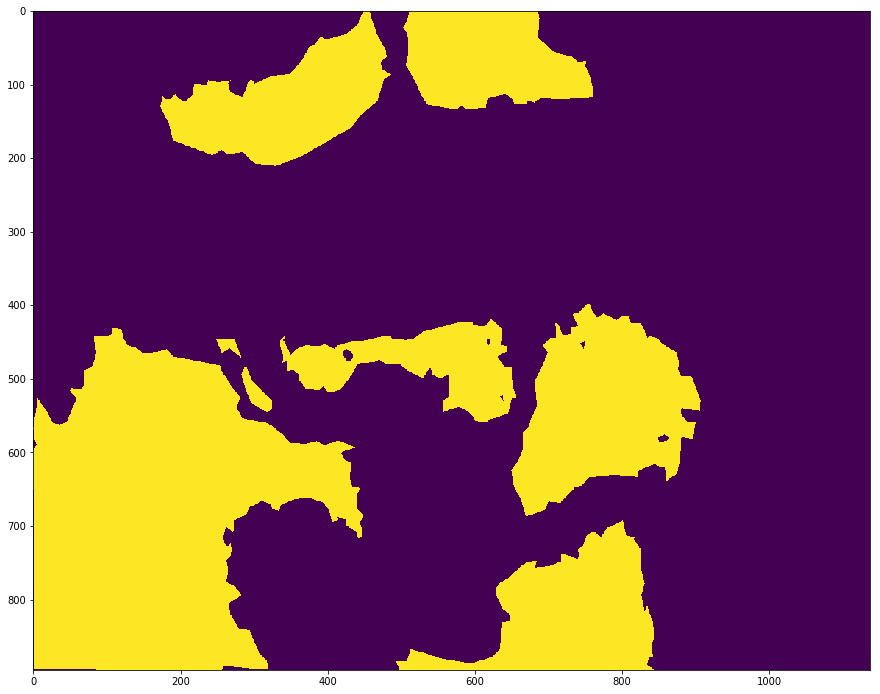

'Jakarta_197_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:32631.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


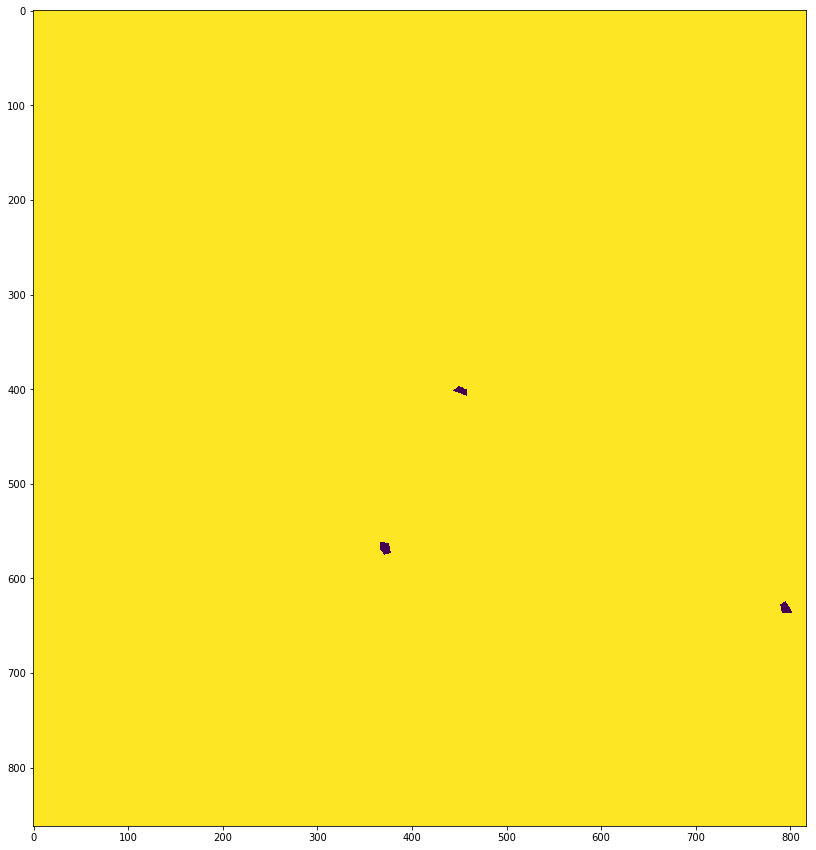

'Jakarta_237_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.
 Raster crs : EPSG:32748, Vector crs : epsg:4326.
 Convert vector and raster to the same CRS.


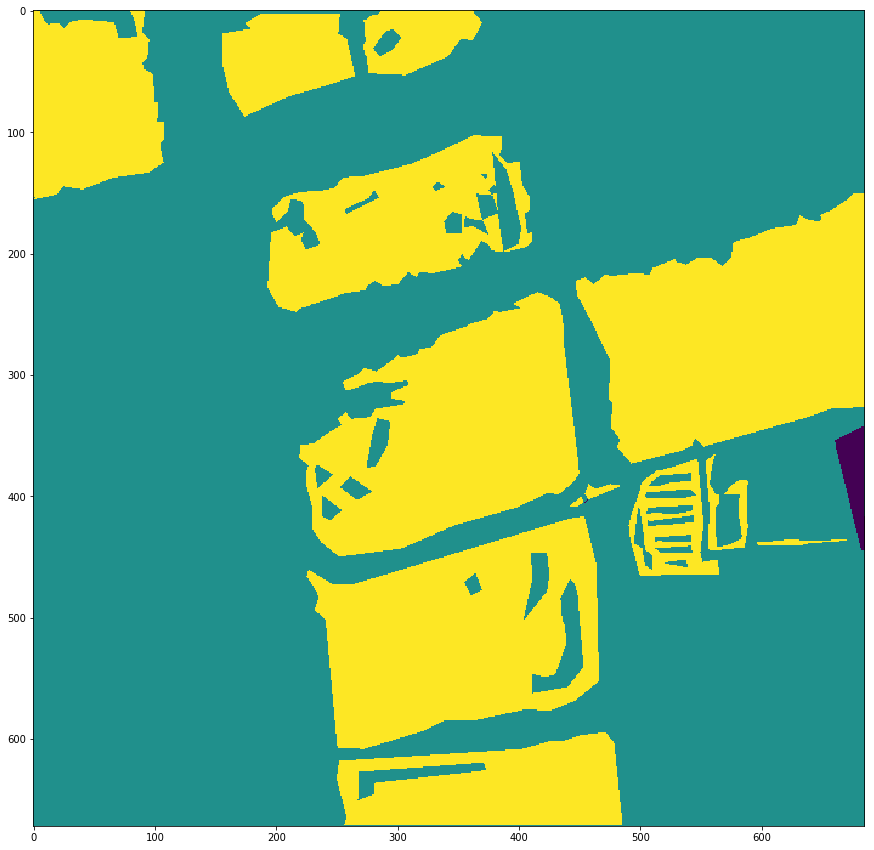

In [7]:
raster_files_root_path='/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files'
water_shape_root_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations'
non_water_shape_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/islands_annotations/*.shp'
mask_files_root_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files'

non_water_shape_files = glob.glob(non_water_shape_path)

# pprint(non_water_shape_files)
for non_water_shape_file_path in non_water_shape_files:
    filename = ntpath.basename(non_water_shape_file_path)
    filename = filename.replace('_island','')
    filename = filename.replace(' ', '')
    raster_file_path = os.path.join(raster_files_root_path, filename.replace('shp','tif'))
    water_shape_file_path = os.path.join(water_shape_root_path, filename)
    mask_file_path = os.path.join(mask_files_root_path, filename.replace('shp','tif'))
    output_path = str(Path(mask_file_path).parent)
    pprint(filename)

    generate_mask(raster_file_path, water_shape_file_path, non_water_shape_file_path, output_path, filename.replace('shp','tif'))


## Deal With The Remaing Annotation Which Only Contains Water

In [10]:
def generate_mask(raster_path, shape_path, output_path, file_name):
    
    """Function that generates a binary mask from a vector file (shp or geojson)
    
    raster_path = path to the .tif;

    shape_path = path to the shapefile or GeoJson.

    output_path = Path to save the binary mask.

    file_name = Name of the file.
    
    """
    
    #load raster
    print(raster_path)
    print(shape_path)
    print(output_path)
    print(file_name)
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    
    if not train_df.empty:
        print(train_df)
        #Verify crs
        if train_df.crs != 4326:
            train_df = train_df.to_crs({'init' :'epsg:4326'})


        #Function that generates the mask
        def poly_from_utm(polygon, transform):
            poly_pts = []

            poly = cascaded_union(polygon)
            for i in np.array(poly.exterior.coords):

                poly_pts.append(~transform * tuple(i))

            new_poly = Polygon(poly_pts)
            return new_poly


        poly_shp = []
        im_size = (src.meta['height'], src.meta['width'])
        for num, row in train_df.iterrows():
            if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
                poly = poly_from_utm(row['geometry'], src.meta['transform'])
                poly_shp.append(poly)
            else:
                if row['geometry'] is not None:
                    for p in row['geometry']:
                        poly = poly_from_utm(p, src.meta['transform'])
                        poly_shp.append(poly)
        mask = rasterize(shapes=poly_shp,
                         out_shape=im_size)

        #Plot
        plt.figure(figsize=(15,15))
        plt.imshow(mask)
        plt.show()

        #Save
        mask = mask.astype("float32")

        bin_mask_meta = src.meta.copy()
        bin_mask_meta.update({'count': 1})
        os.chdir(output_path)
        with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1)



/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_199_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_199_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_199_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.64855 -6.27426, 106.64870 -6.274...
1  None  POLYGON ((106.64965 -6.27490, 106.64980 -6.274...


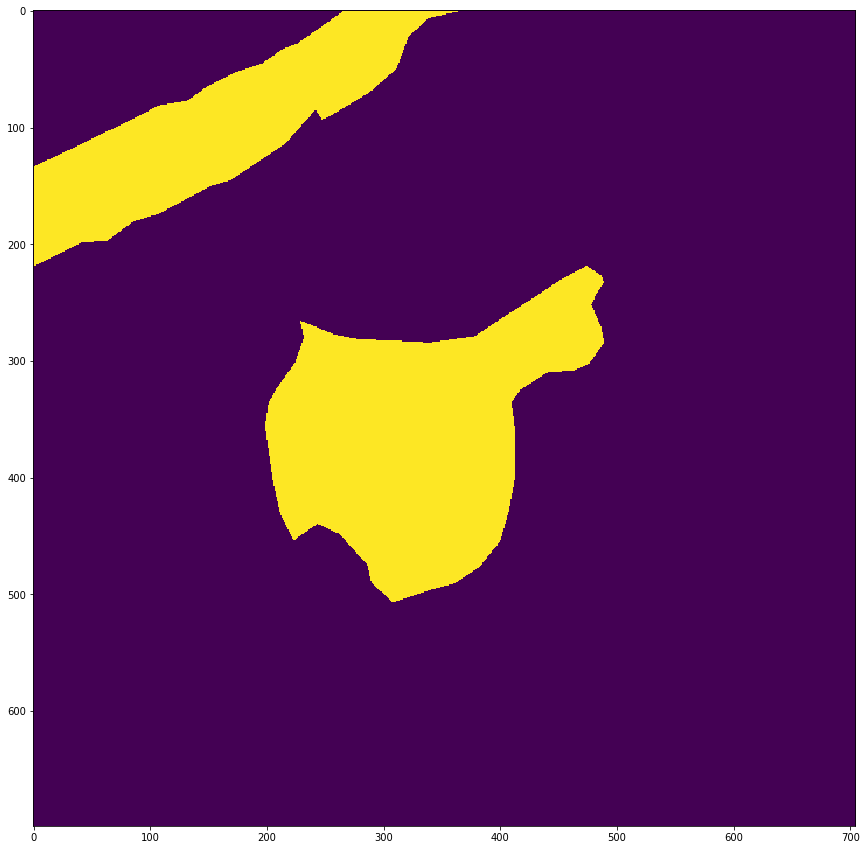

Jakarta_199_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.96099 -6.10288, 106.96206 -6.102...
1  None  POLYGON ((106.96107 -6.10330, 106.96123 -6.103...
2  None  POLYGON ((106.96113 -6.10416, 106.96120 -6.104...
3  None  POLYGON ((106.96116 -6.10402, 106.96119 -6.104...
4  None  POLYGON ((106.96167 -6.10396, 106.96170 -6.103...
5  None  POLYGON ((106.96124 -6.10403, 106.96124 -6.103...


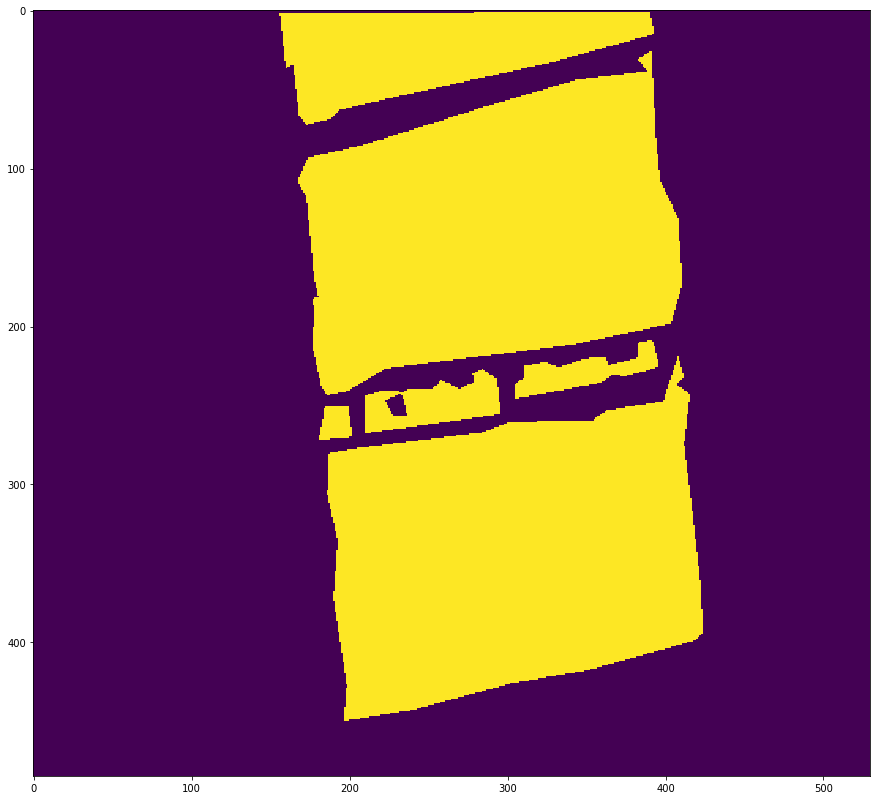

Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.82210 -1.21494, 116.82560 -1.214...
1  None  POLYGON ((116.82586 -1.21493, 116.82607 -1.214...
2  None  POLYGON ((98.64371 3.62320, 98.64384 3.62319, ...
3  None  POLYGON ((98.64371 3.62319, 98.64383 3.62320, ...


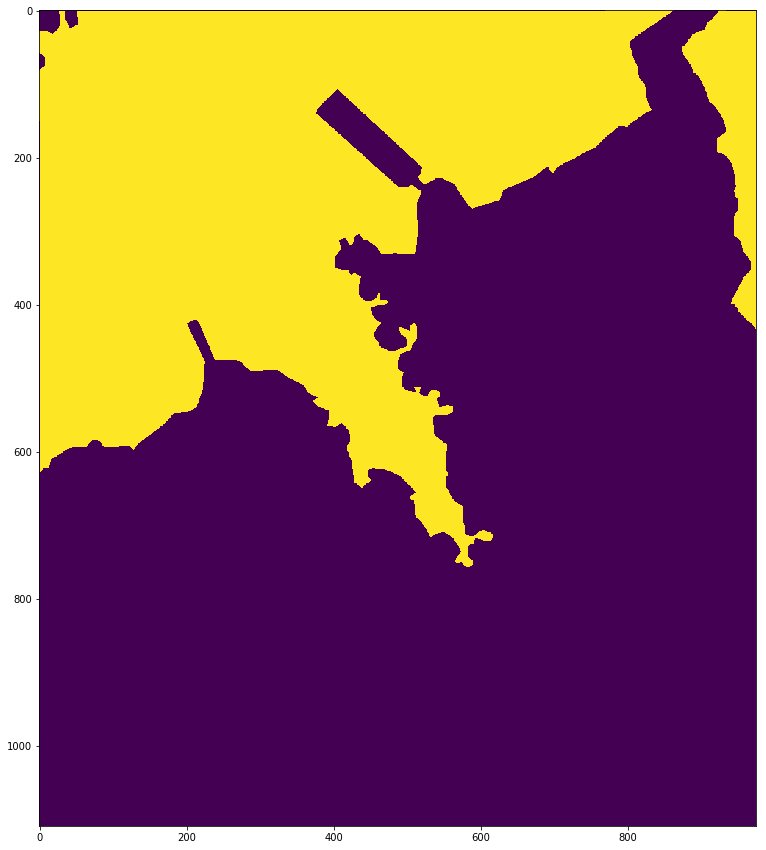

Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_047_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_047_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_047_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.21439 -8.72527, 115.21496 -8.725...
1  None  POLYGON ((115.21306 -8.72527, 115.21318 -8.725...
2  None  POLYGON ((115.21281 -8.72620, 115.21287 -8.726...
3  None  POLYGON ((115.21279 -8.72722, 115.21282 -8.727...


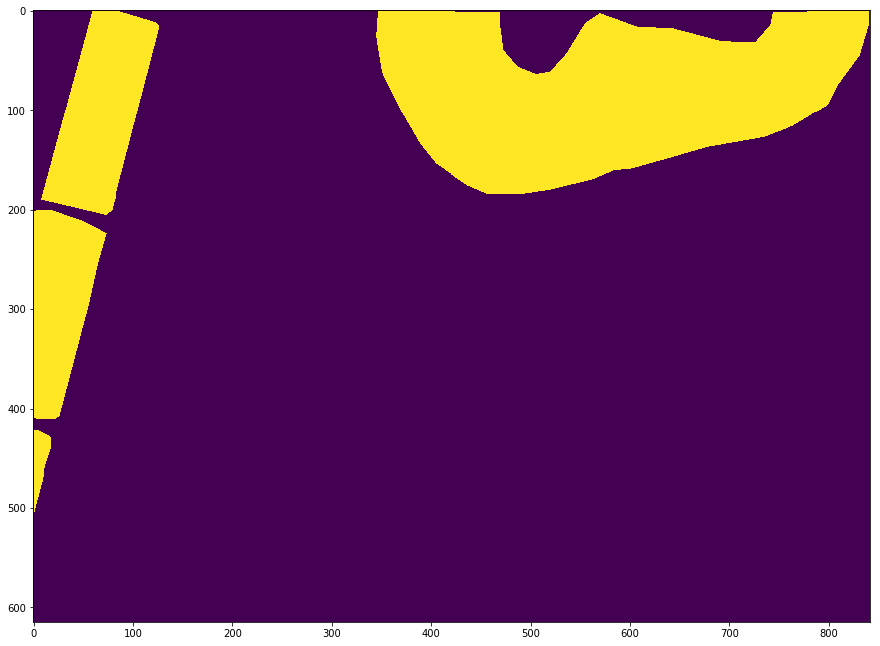

Denpasar_047_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_198_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_198_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_198_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
Jakarta_198_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_378_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_378_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_dete

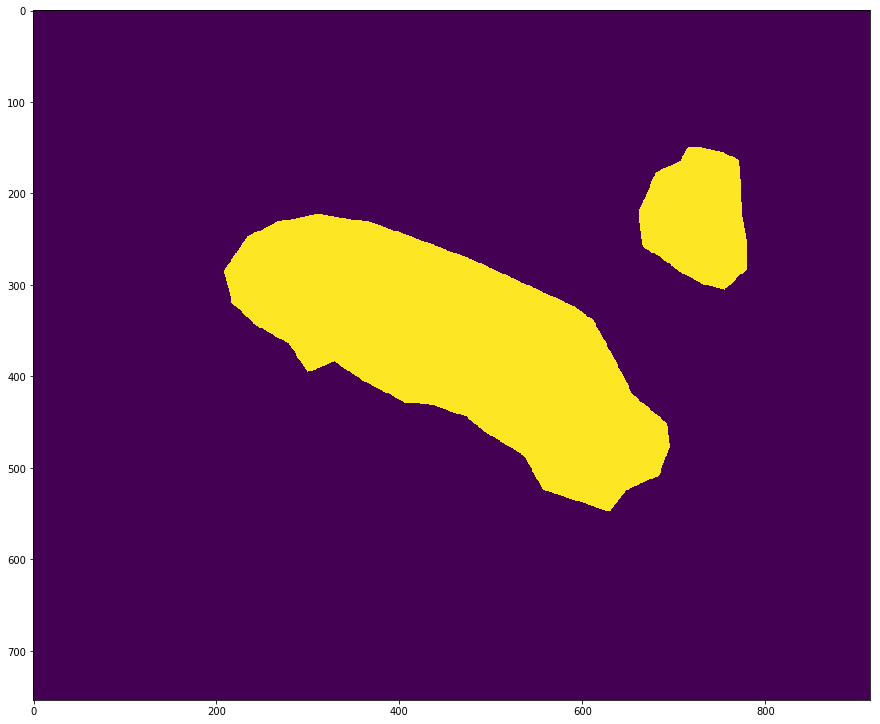

Jakarta_378_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_016_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_016_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_016_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.64676 3.62443, 98.64681 3.62443, ...
1  None  POLYGON ((98.64794 3.62460, 98.64794 3.62457, ...
2  None  POLYGON ((98.64744 3.62327, 98.64745 3.62330, ...
3  None  POLYGON ((98.64727 3.62480, 98.64728 3.62479, ...
4  None  POLYGON ((98.64721 3.62496, 98.64724 3.62496, ...


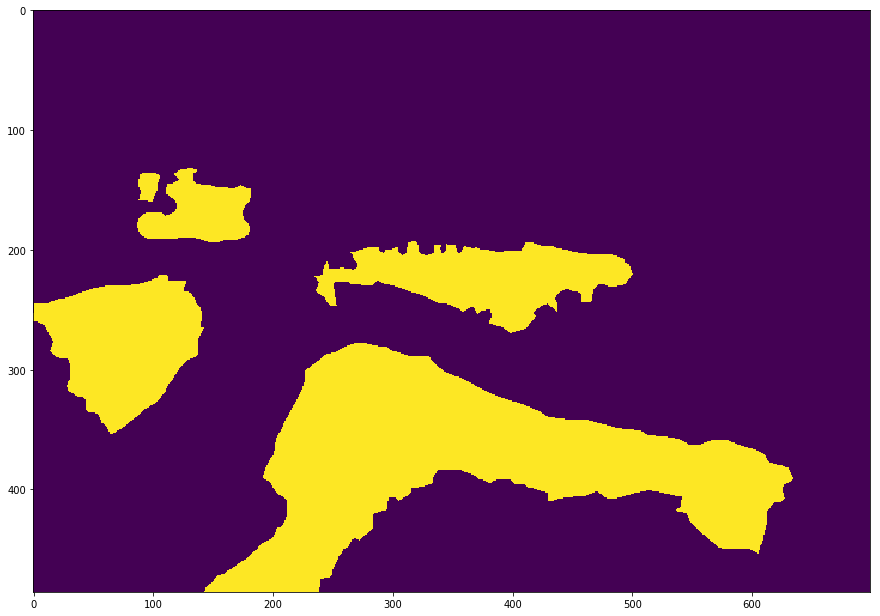

Medan_016_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_416_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_416_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_416_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.83359 -6.12314, 106.83357 -6.123...
1  None  POLYGON ((106.83367 -6.12333, 106.83370 -6.123...
2  None  POLYGON ((106.83343 -6.12348, 106.83345 -6.123...
3  None  POLYGON ((106.83389 -6.12350, 106.83392 -6.123...


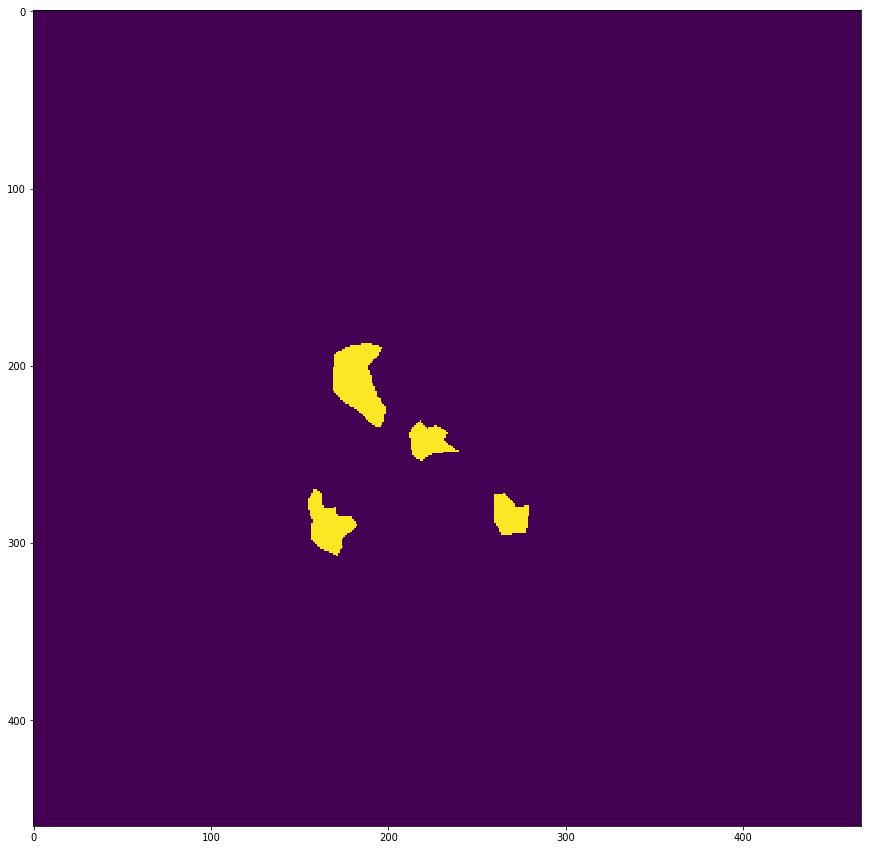

Jakarta_416_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Cilegon_002_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Cilegon_002_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Cilegon_002_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.02527 -5.88832, 106.02547 -5.888...
1  None  POLYGON ((106.02651 -5.88925, 106.02656 -5.889...
2  None  POLYGON ((106.02567 -5.88825, 106.02635 -5.888...
3  None  POLYGON ((106.02667 -5.88912, 106.02694 -5.888...
4  None  POLYGON ((106.02658 -5.88824, 106.02849 -5.888...
5  None  POLYGON ((106.02886 -5.88826, 106.02922 -5.888...


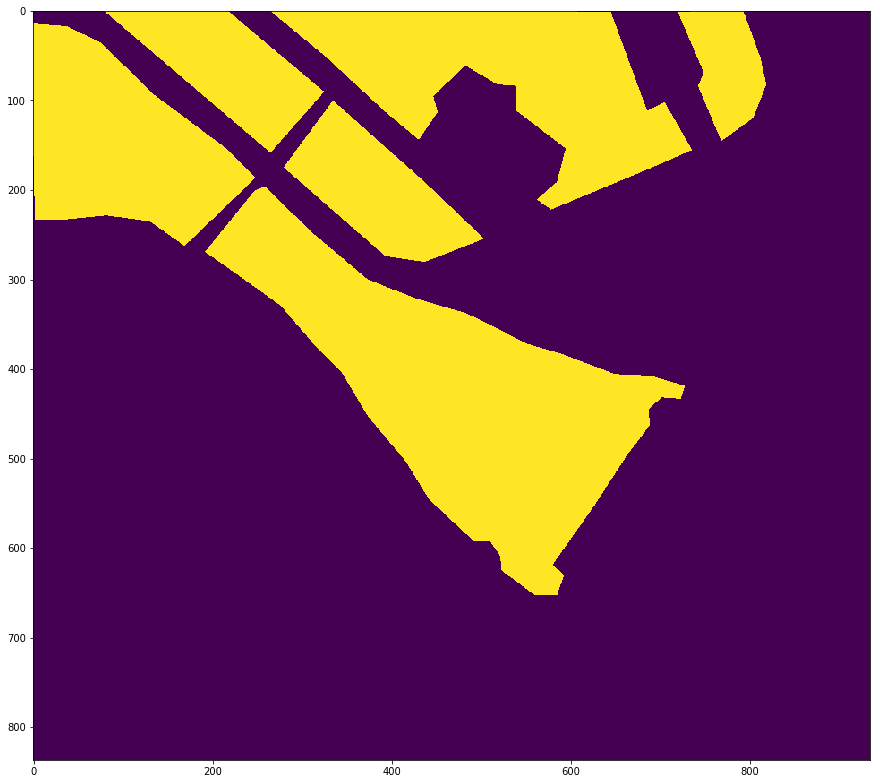

Cilegon_002_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_099_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_099_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_099_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.60740 3.70161, 98.60753 3.70161, ...
1  None  POLYGON ((98.60750 3.70114, 98.60760 3.70117, ...


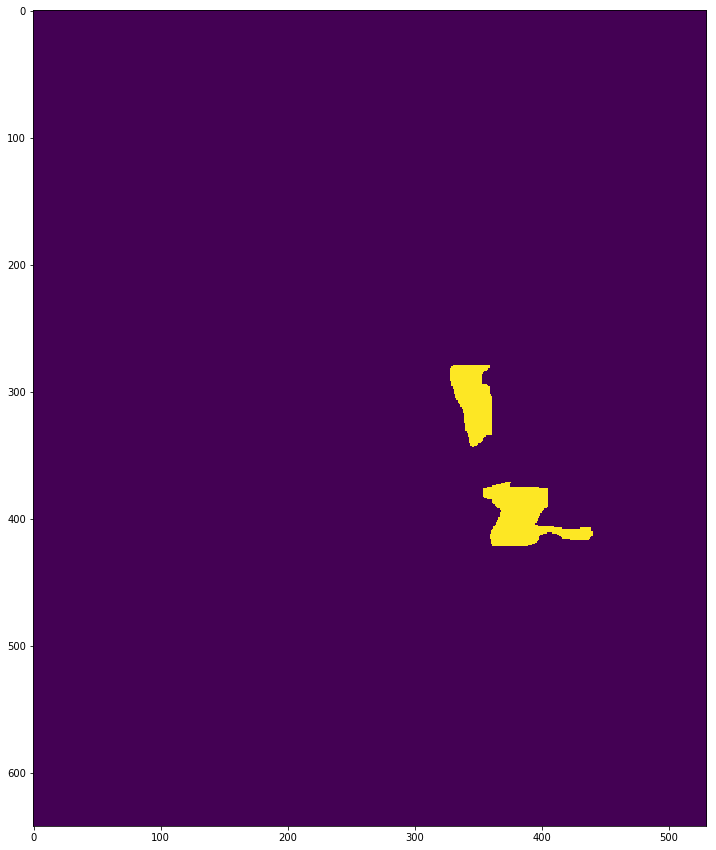

Medan_099_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Cilegon_009_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Cilegon_009_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Cilegon_009_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.03985 -5.98741, 106.03985 -5.987...
1  None  POLYGON ((106.04058 -5.98721, 106.04060 -5.987...


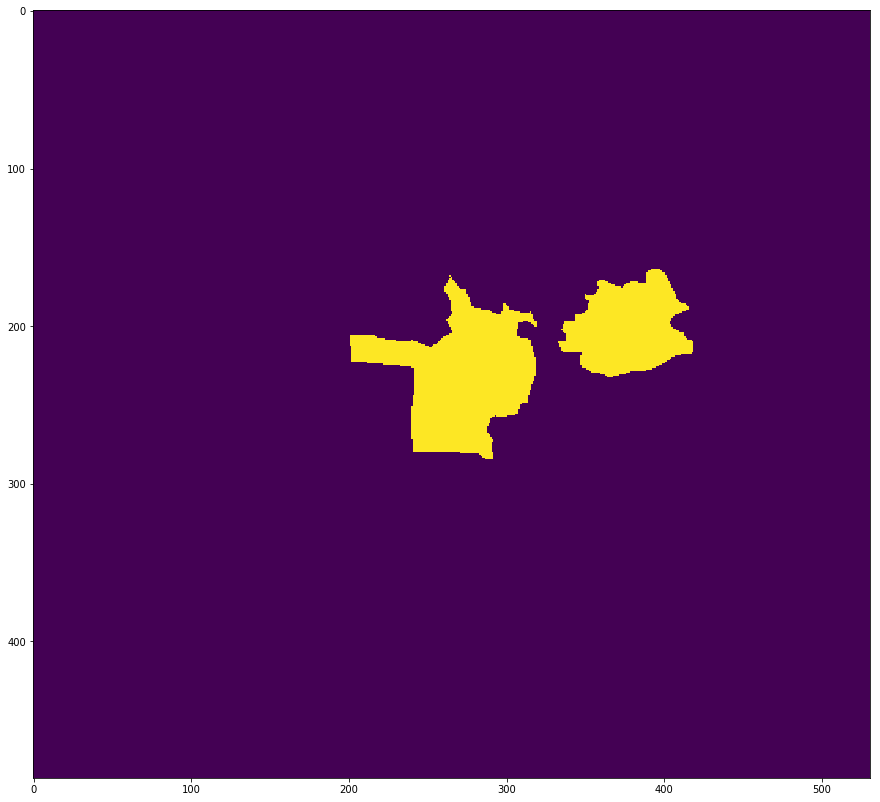

Cilegon_009_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_281_pansharpen_True_2020-03-03_04:04_10300100A312C200_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_281_pansharpen_True_2020-03-03_04:04_10300100A312C200_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_281_pansharpen_True_2020-03-03_04:04_10300100A312C200_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.69005 3.50702, 98.69005 3.50705, ...


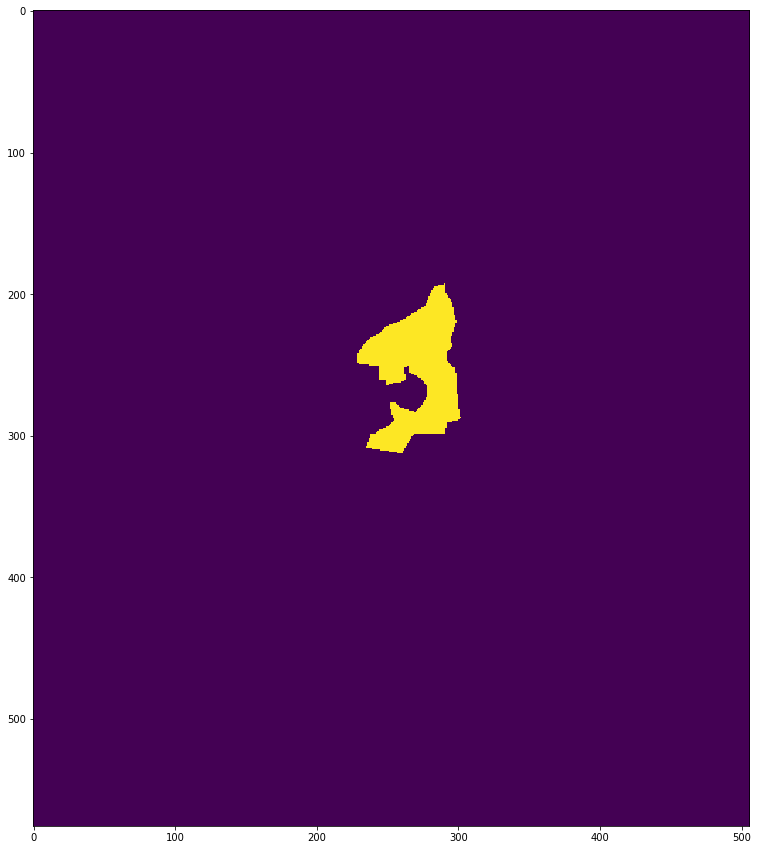

Medan_281_pansharpen_True_2020-03-03_04:04_10300100A312C200_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_227_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_227_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_227_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.67893 3.49749, 98.67892 3.49747, ...
1  None  POLYGON ((98.67930 3.49765, 98.67932 3.49766, ...
2  None  POLYGON ((98.67929 3.49791, 98.67942 3.49791, ...
3  None  POLYGON ((98.67993 3.49781, 98.67999 3.49781, ...
4  None  POLYGON ((98.68004 3.49743, 98.68010 3.49745, ...


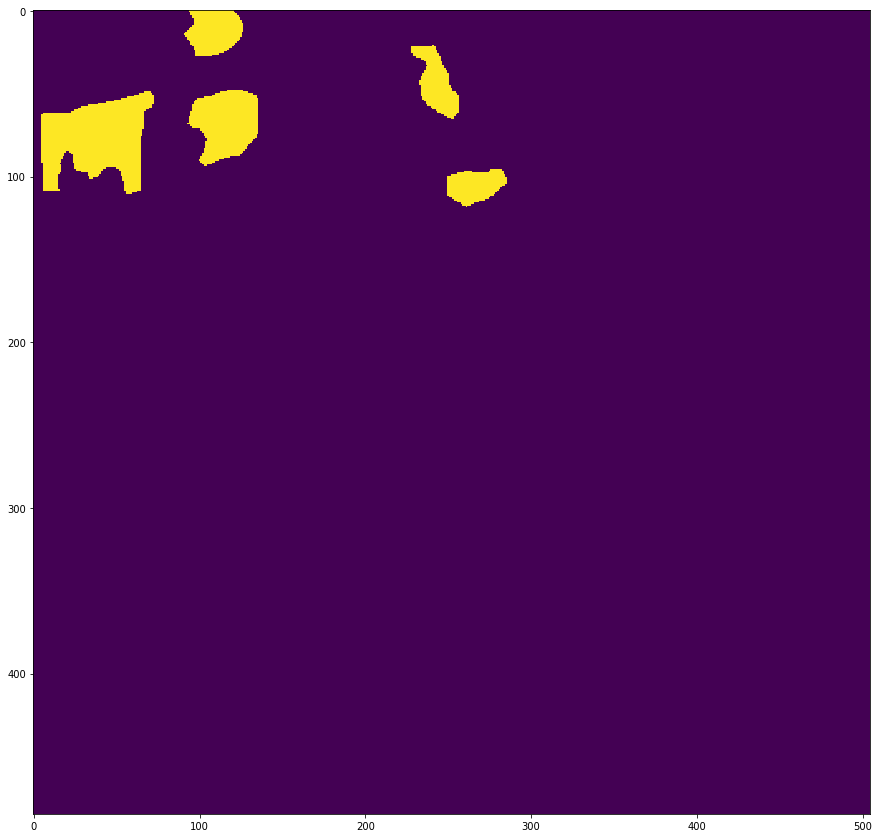

Medan_227_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_021_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_021_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_021_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.64398 3.62244, 98.64401 3.62255, ...
1  None  POLYGON ((98.64398 3.62174, 98.64402 3.62181, ...
2  None  POLYGON ((98.64371 3.62320, 98.64383 3.62319, ...
3  None  POLYGON ((98.64741 3.62319, 98.64768 3.62320, ...
4  None  POLYGON ((98.64147 3.62195, 98.64150 3.62198, ...


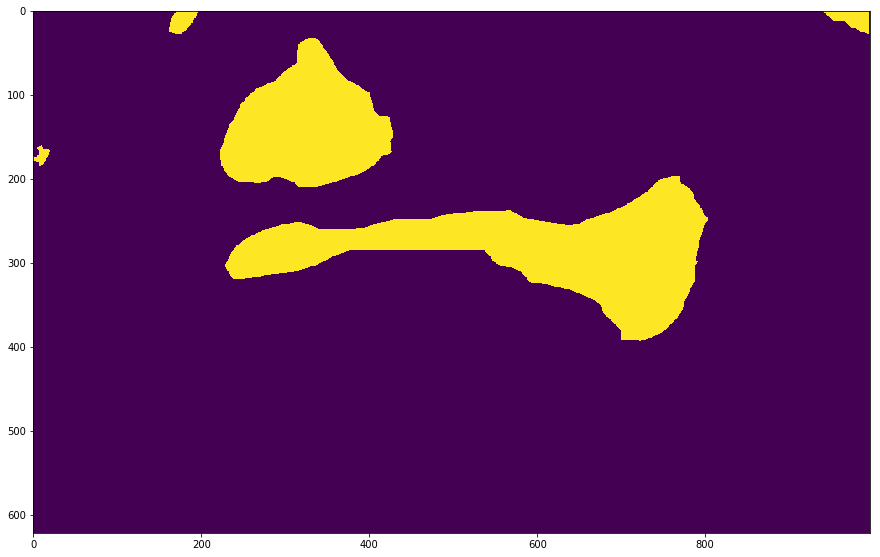

Medan_021_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_041_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_041_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_041_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.18475 -8.74675, 115.18615 -8.746...
1  None  POLYGON ((115.18420 -8.74917, 115.18424 -8.749...
2  None  POLYGON ((115.18615 -8.74771, 115.18615 -8.747...


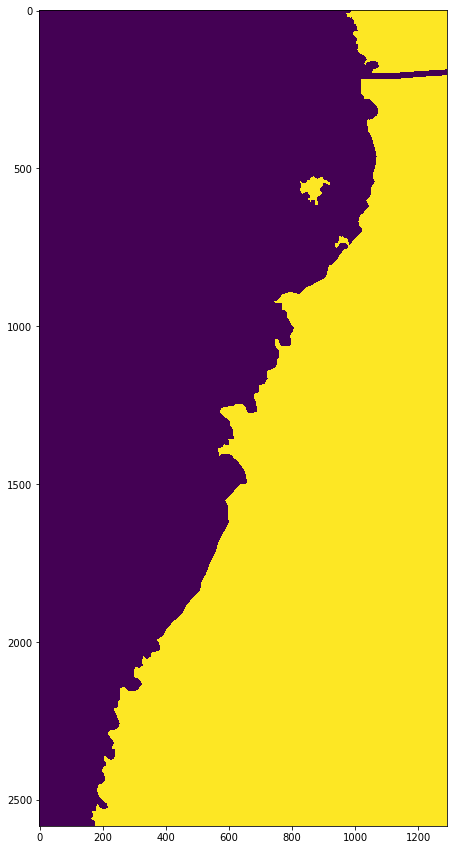

Denpasar_041_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_196_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_196_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_196_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.73169 -6.13554, 106.73169 -6.135...
1  None  POLYGON ((106.73172 -6.13524, 106.73171 -6.135...


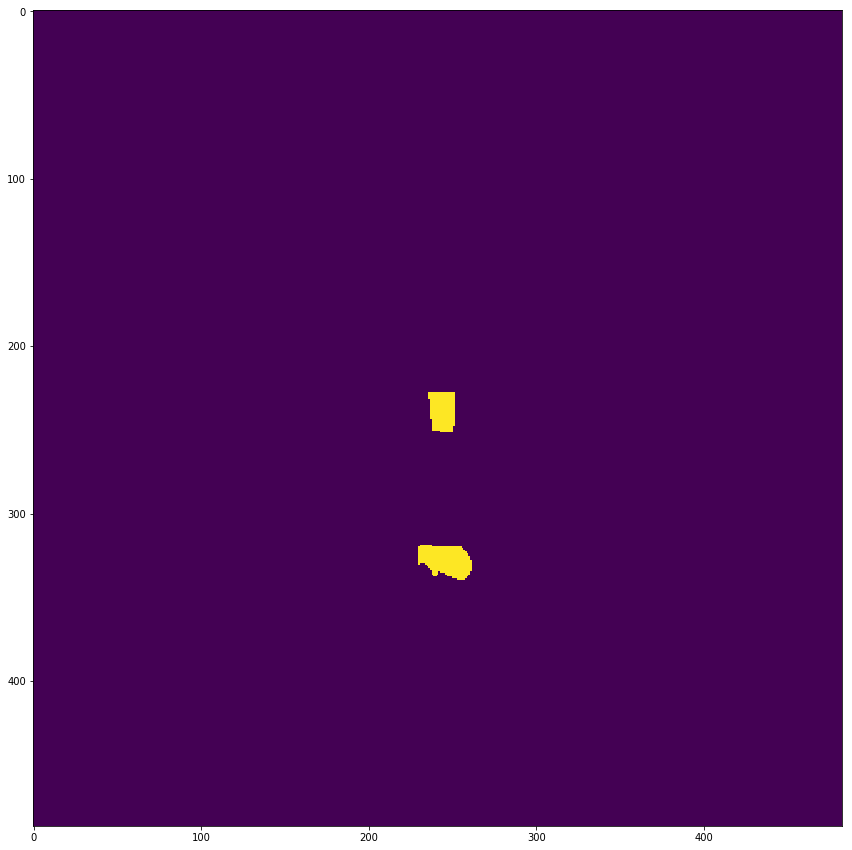

Jakarta_196_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.62497 -6.34004, 106.62502 -6.340...
1  None  POLYGON ((106.62571 -6.34206, 106.62598 -6.341...
2  None  POLYGON ((106.62553 -6.34206, 106.62548 -6.342...


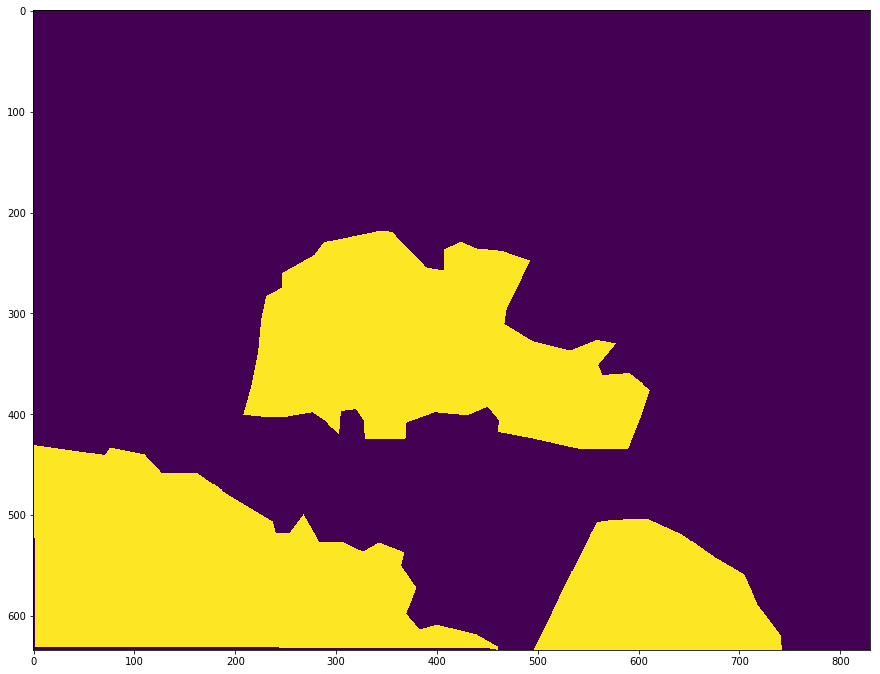

Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_034_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_034_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_034_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((116.82847 -1.21904, 116.82848 -1.219...
1   None  POLYGON ((116.82885 -1.21953, 116.83003 -1.219...
2   None  POLYGON ((116.83004 -1.22036, 116.83031 -1.220...
3   None  POLYGON ((116.83000 -1.22037, 116.83002 -1.220...
4   None  POLYGON ((116.82964 -1.22064, 116.83002 -1.220...
5   None  POLYGON ((116.82946 -1.22006, 116.83003 -1.220...
6   None  P

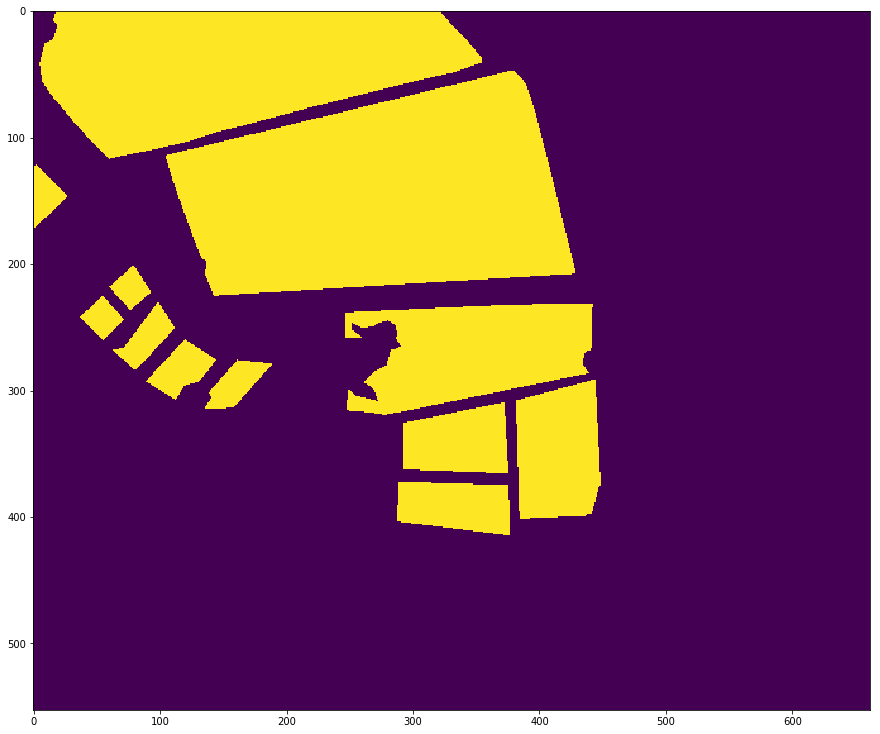

Balikpapan_034_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_458_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_458_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_458_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.76603 -6.25260, 106.76612 -6.252...
1  None  POLYGON ((106.76568 -6.25150, 106.76587 -6.251...
2  None  POLYGON ((106.76633 -6.25149, 106.76657 -6.251...
3  None  POLYGON ((106.76761 -6.25436, 106.76769 -6.254...


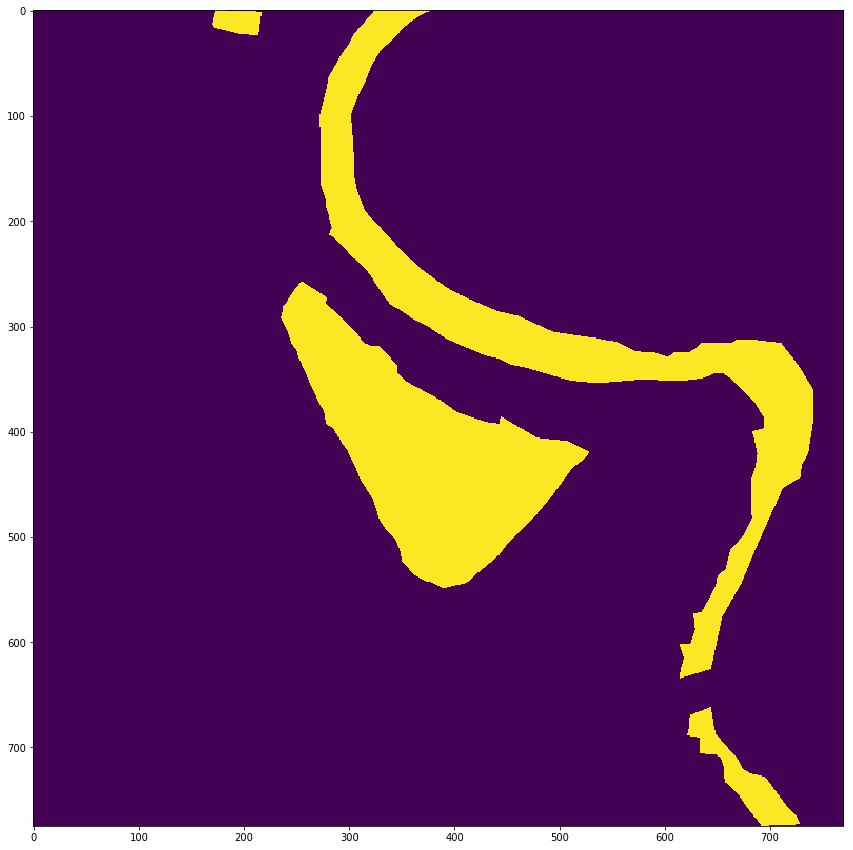

Jakarta_458_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.18425 -8.74091, 115.18477 -8.740...


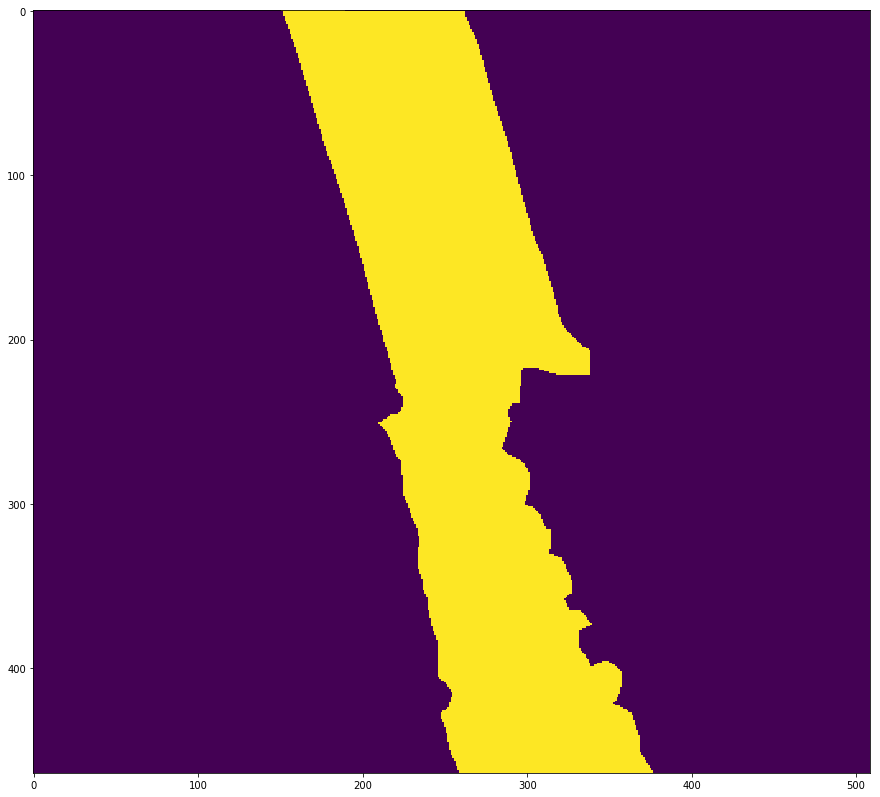

Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_204_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_204_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_204_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.80127 -6.20933, 106.80164 -6.209...


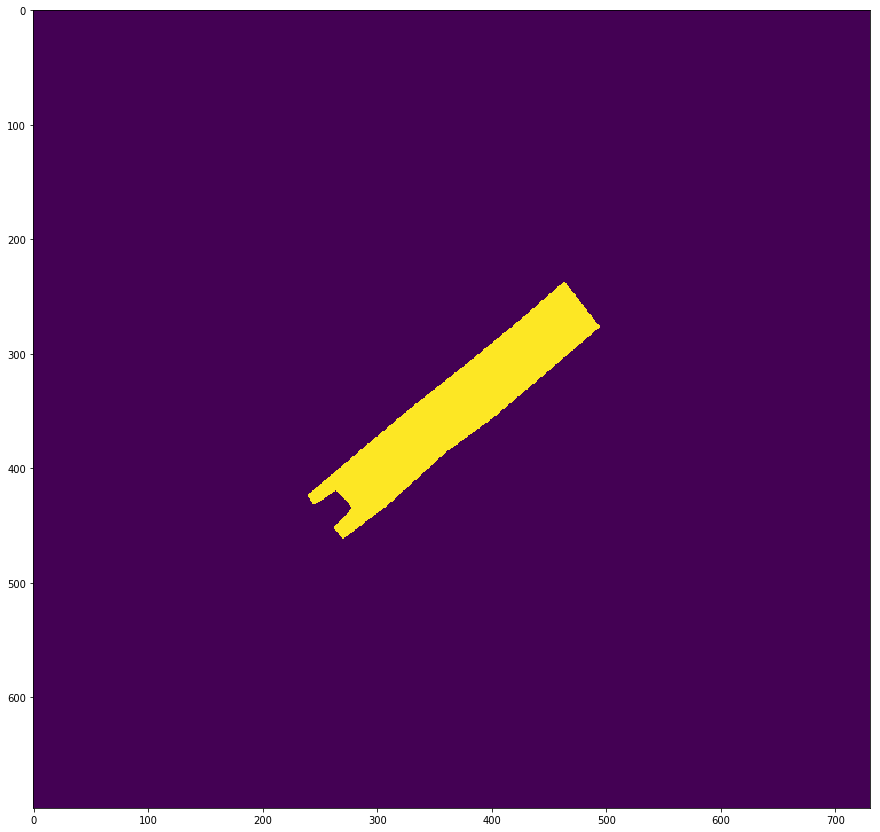

Jakarta_204_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_327_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_327_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_327_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.63393 -6.34583, 106.63396 -6.345...
1  None  POLYGON ((106.63400 -6.34767, 106.63400 -6.347...
2  None  POLYGON ((106.63431 -6.34535, 106.63431 -6.345...


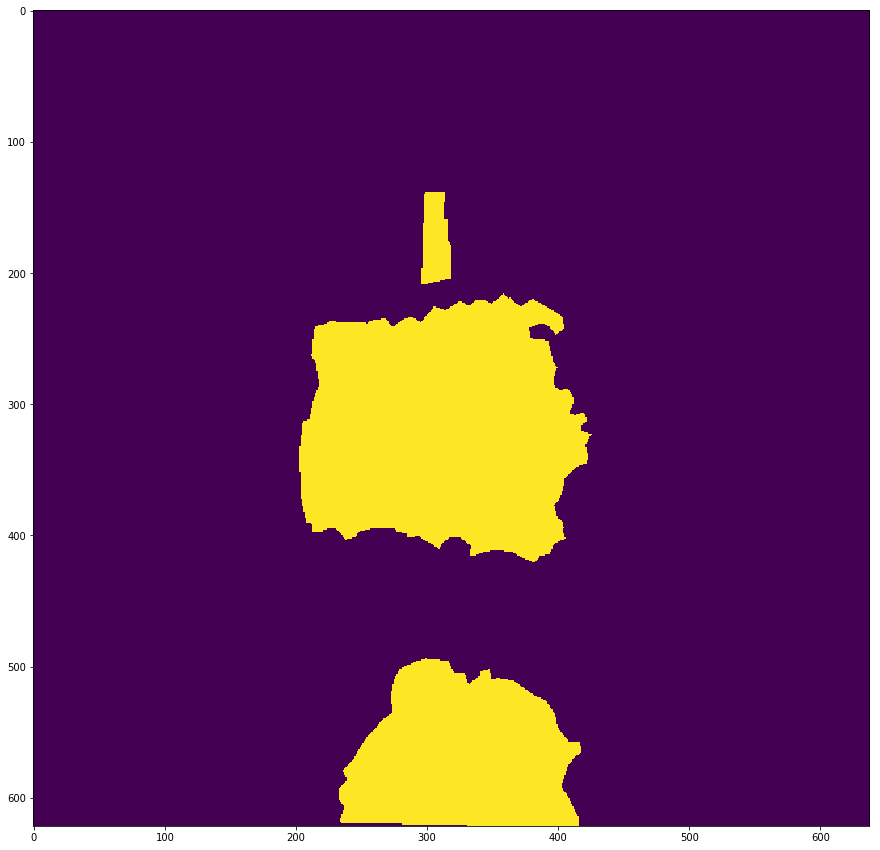

Jakarta_327_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_033_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_033_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_033_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((116.82855 -1.21886, 116.82934 -1.218...
1   None  POLYGON ((116.82884 -1.21954, 116.82937 -1.219...
2   None  POLYGON ((116.82780 -1.21828, 116.82807 -1.218...
3   None  POLYGON ((116.82780 -1.21897, 116.82791 -1.219...
4   None  POLYGON ((116.82850 -1.21826, 116.82920 -1.218...
5   None  POLYGON ((116.82841 -1.21956, 116.82851 -1.219...
6   None  P

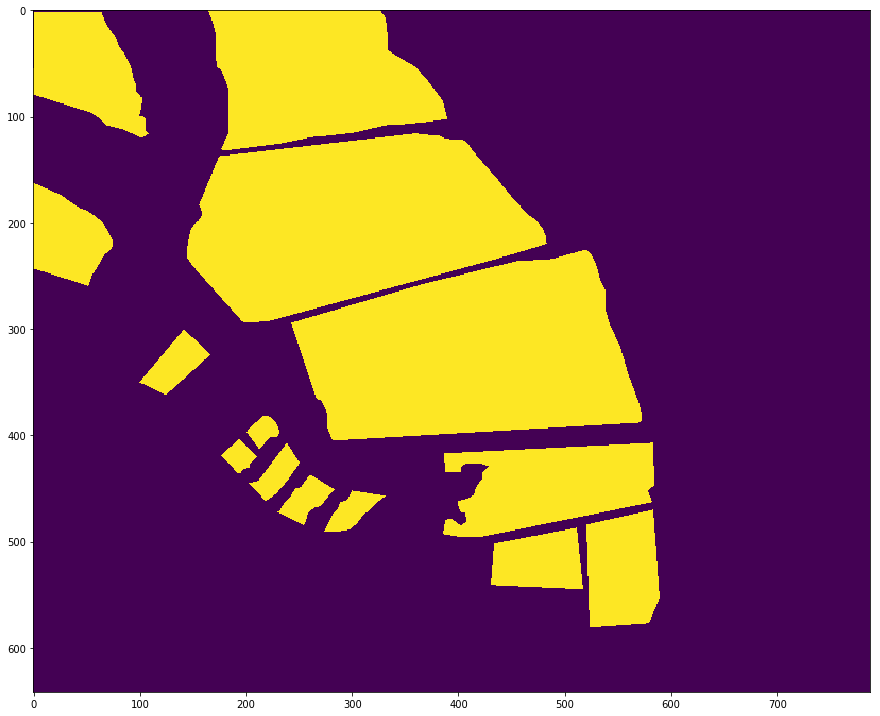

Balikpapan_033_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_216_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_216_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_216_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.67262 3.75560, 98.67276 3.75560, ...
1  None  POLYGON ((98.67195 3.75488, 98.67198 3.75492, ...
2  None  POLYGON ((98.67223 3.75472, 98.67232 3.75465, ...
3  None  POLYGON ((98.67207 3.75509, 98.67209 3.75514, ...
4  None  POLYGON ((98.67226 3.75496, 98.67235 3.75507, ...
5  None  POLYGON ((98.67243 3.75482, 98.67250 3.75490, ...
6  None  POLYGON ((98.67260 3.

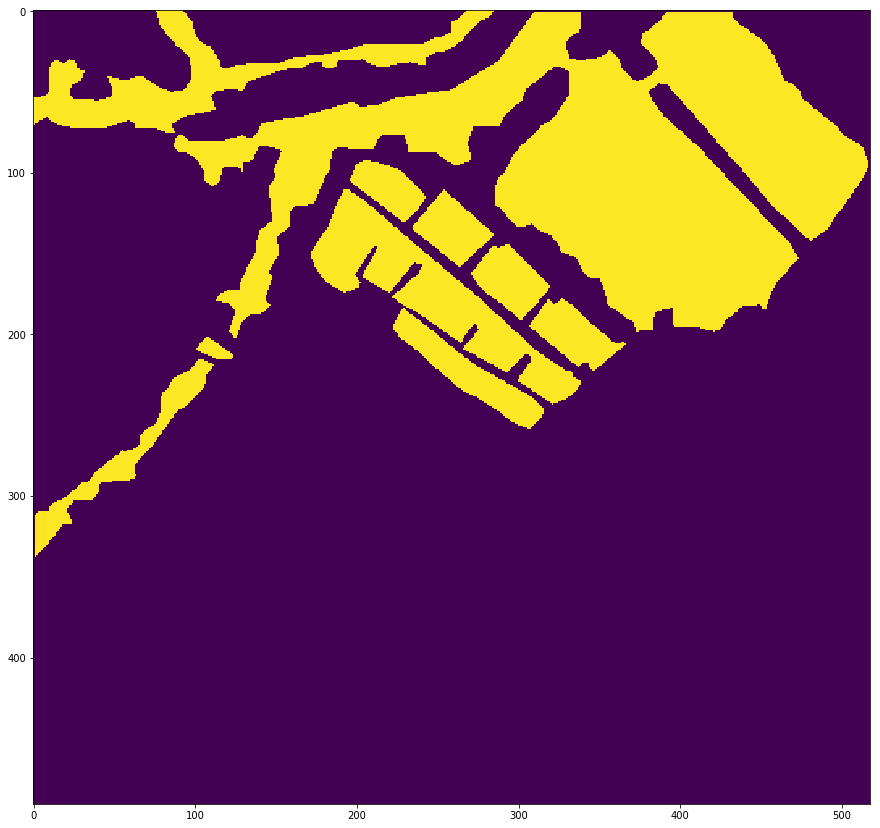

Medan_216_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Cilegon_004_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Cilegon_004_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Cilegon_004_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.03676 -5.88269, 106.03826 -5.882...
1  None  POLYGON ((106.03798 -5.88379, 106.03822 -5.883...
2  None  POLYGON ((106.03641 -5.88616, 106.03662 -5.886...
3  None  POLYGON ((106.03621 -5.88841, 106.03624 -5.888...
4  None  POLYGON ((106.03628 -5.88270, 106.03685 -5.883...
5  None  POLYGON ((106.03547 -5.88570, 106.03523 -5.885...
6  None  POLYGON ((106.03570 

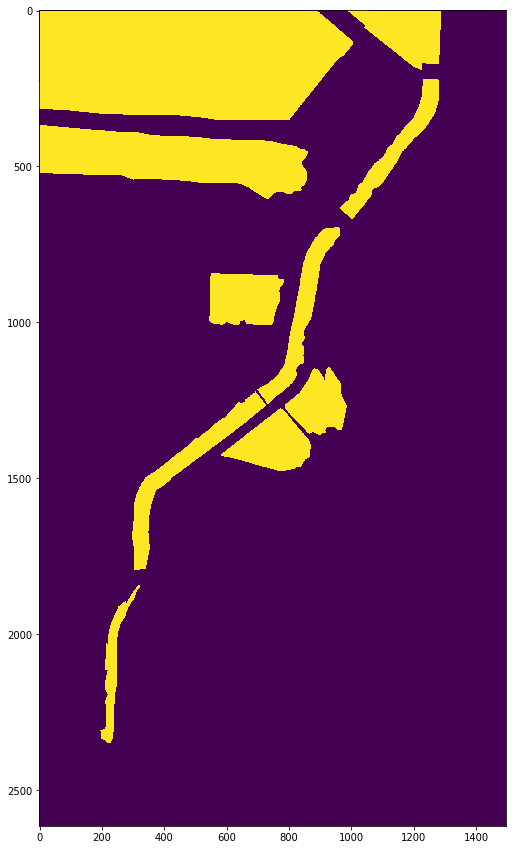

Cilegon_004_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_200_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_200_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_200_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.60404 -6.23502, 106.60411 -6.234...
1  None  POLYGON ((106.60524 -6.23445, 106.60532 -6.234...
2  None  POLYGON ((106.60516 -6.23541, 106.60538 -6.235...
3  None  POLYGON ((106.60282 -6.23365, 106.60285 -6.233...
4  None  POLYGON ((106.60507 -6.23365, 106.60548 -6.233...
5  None  POLYGON ((106.60484 -6.23400, 106.60488 -6.233...
6  None  POLYGON ((106.6027

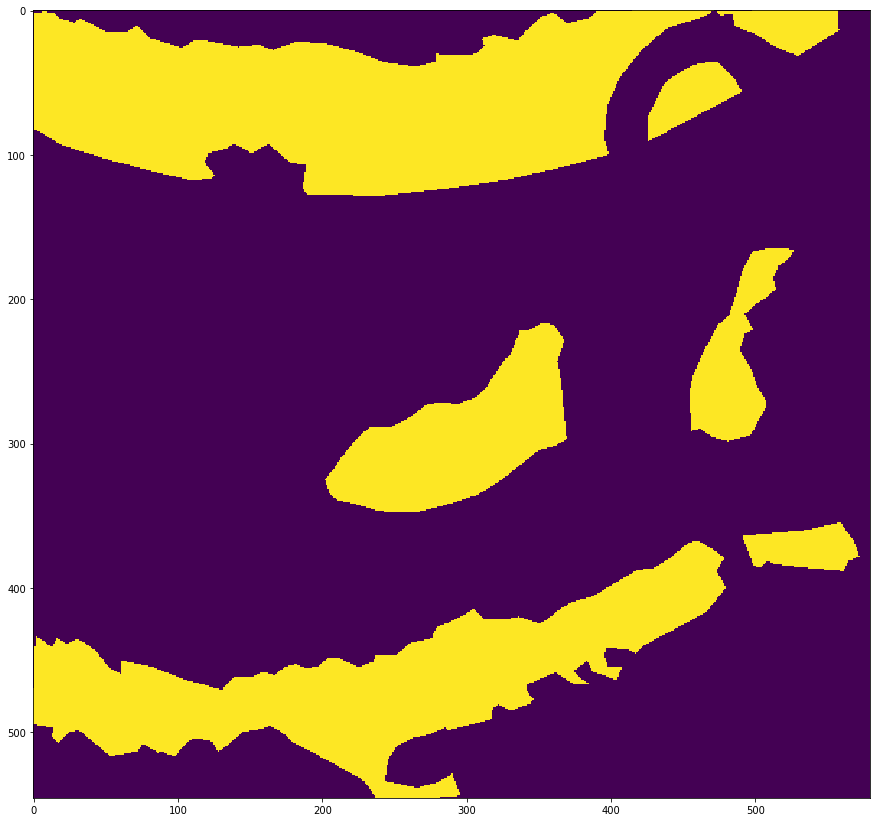

Jakarta_200_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.26510 -8.67789, 115.26531 -8.677...
1  None  POLYGON ((115.26387 -8.67972, 115.26394 -8.679...
2  None  POLYGON ((115.26404 -8.67804, 115.26411 -8.678...


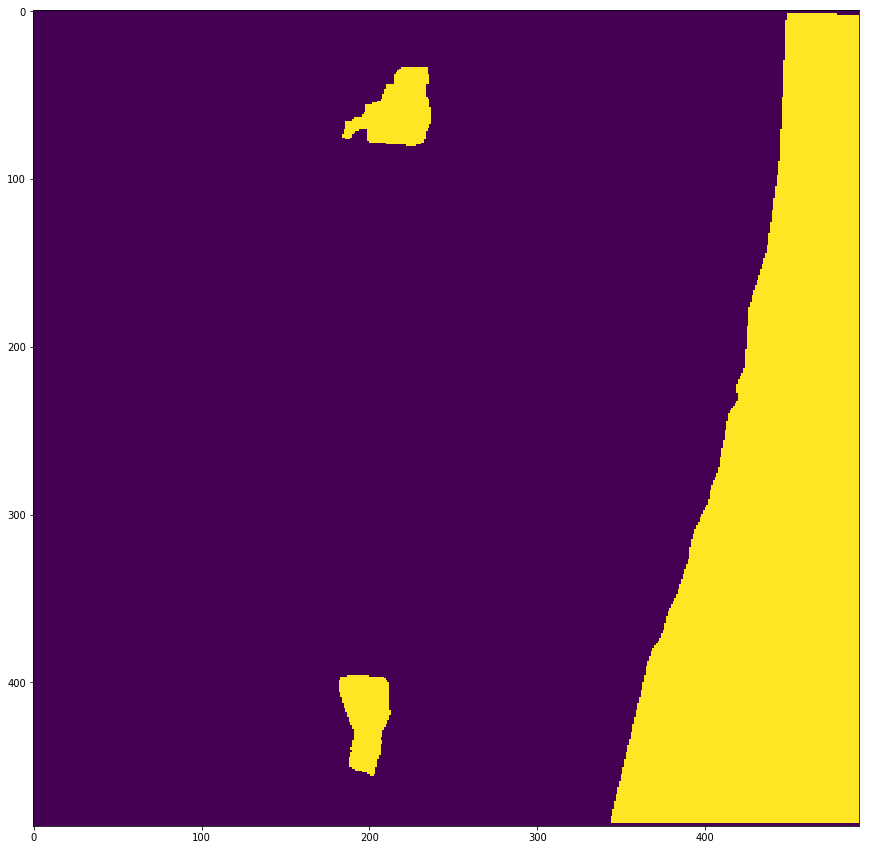

Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_031_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_031_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_031_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.91070 -6.20145, 106.91076 -6.201...


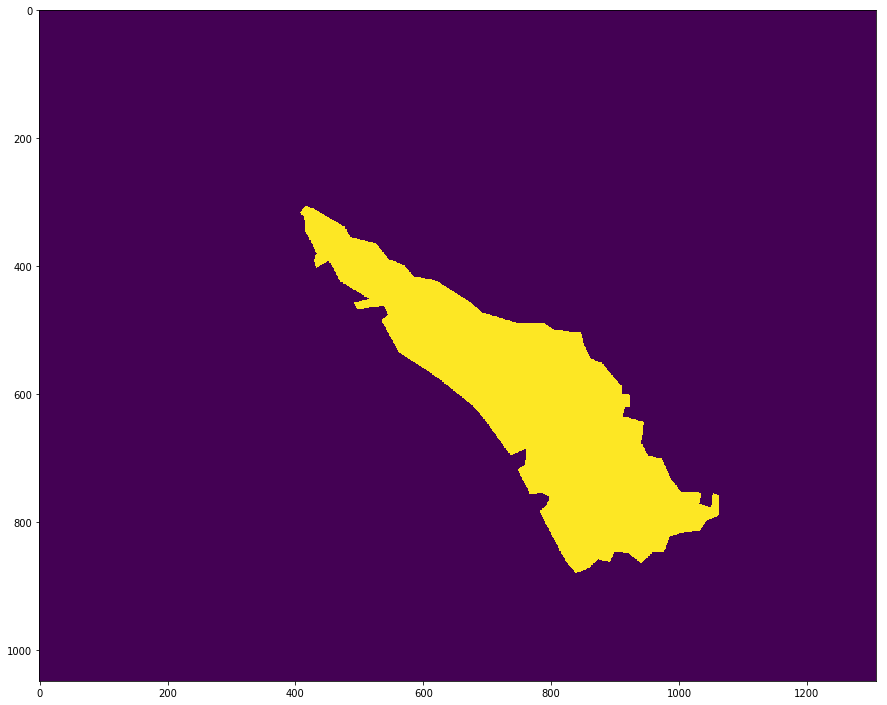

Jakarta_031_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_288_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_288_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_288_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((106.79695 -6.21642, 106.79709 -6.216...
1   None  POLYGON ((106.79608 -6.21701, 106.79613 -6.217...
2   None  POLYGON ((106.79616 -6.21650, 106.79619 -6.216...
3   None  POLYGON ((106.79635 -6.21695, 106.79642 -6.216...
4   None  POLYGON ((106.79629 -6.21575, 106.79632 -6.215...
5   None  POLYGON ((106.79627 -6.21595, 106.79632 -6.215...
6   None  POLYGON ((

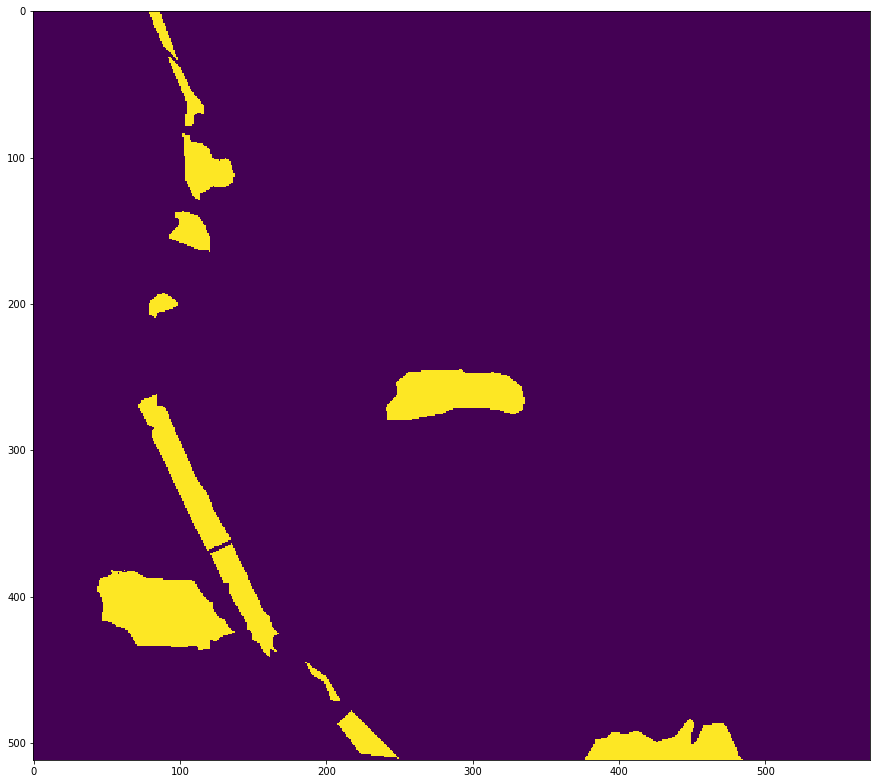

Jakarta_288_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_214_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_214_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_214_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.96916 -6.09846, 106.96920 -6.098...
1  None  POLYGON ((106.96949 -6.10093, 106.96953 -6.100...
2  None  POLYGON ((106.96997 -6.09953, 106.97005 -6.099...
3  None  POLYGON ((106.96992 -6.09957, 106.96994 -6.099...
4  None  POLYGON ((106.97004 -6.09895, 106.97004 -6.099...
5  None  POLYGON ((106.96982 -6.09875, 106.96984 -6.098...
6  None  POLYGON ((106.9697

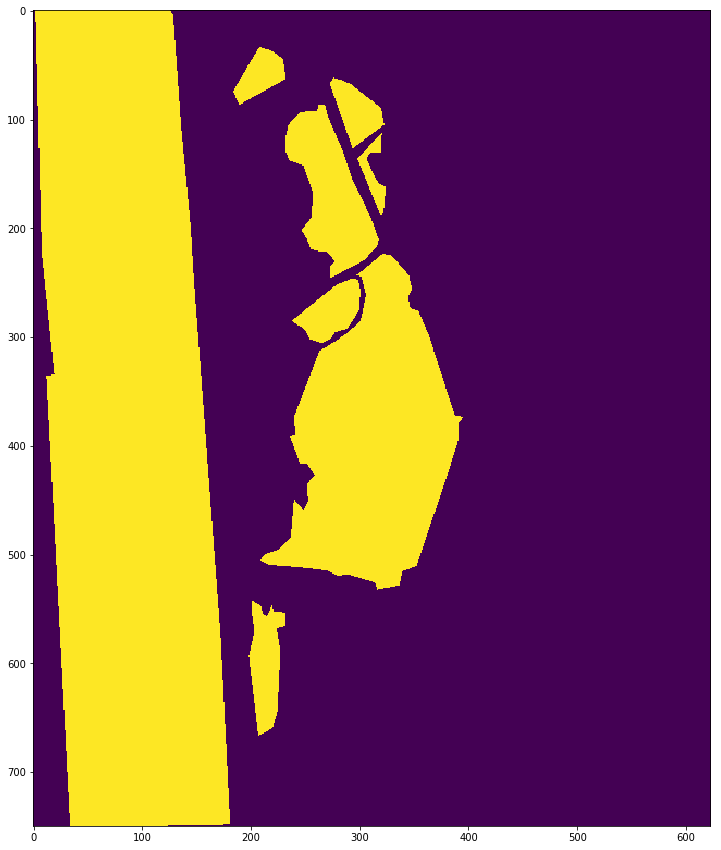

Jakarta_214_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_190_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_190_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_190_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.73015 -6.14184, 106.73013 -6.141...
1  None  POLYGON ((106.73010 -6.14314, 106.73007 -6.143...
2  None  POLYGON ((106.72941 -6.14148, 106.72941 -6.141...
3  None  POLYGON ((106.72949 -6.14136, 106.72948 -6.141...
4  None  POLYGON ((106.72931 -6.14191, 106.72934 -6.141...
5  None  POLYGON ((106.72927 -6.14205, 106.72929 -6.142...
6  None  POLYGON ((106.7294

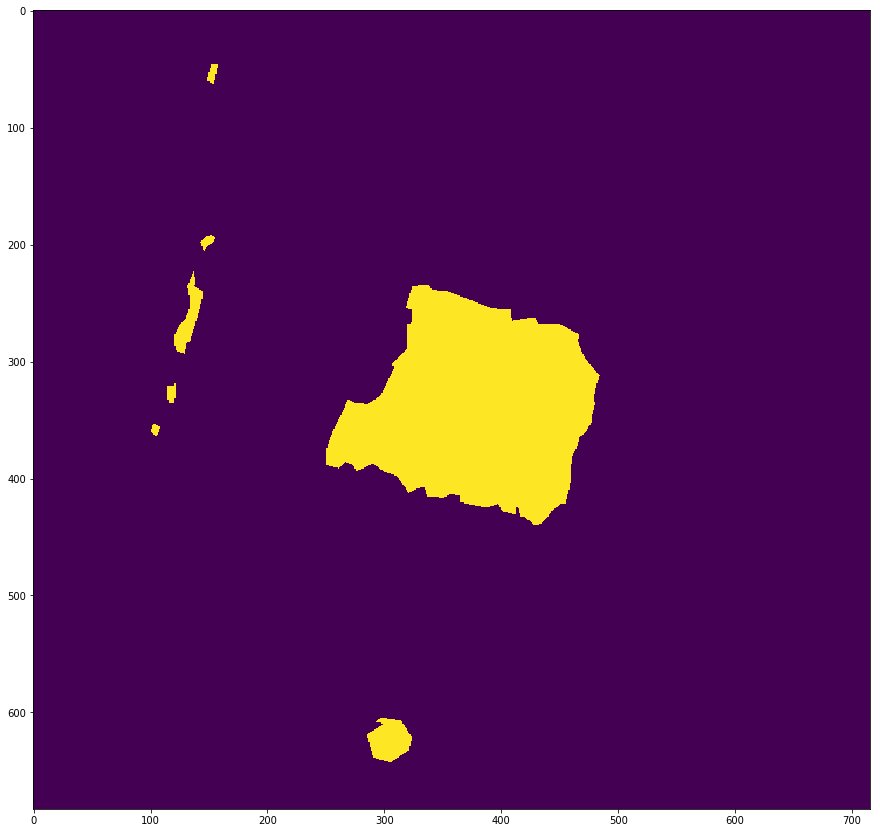

Jakarta_190_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_025_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_025_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_025_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.78593 -6.10707, 106.78593 -6.107...
1  None  POLYGON ((106.78756 -6.10770, 106.78775 -6.107...
2  None  POLYGON ((106.78694 -6.10813, 106.78703 -6.107...


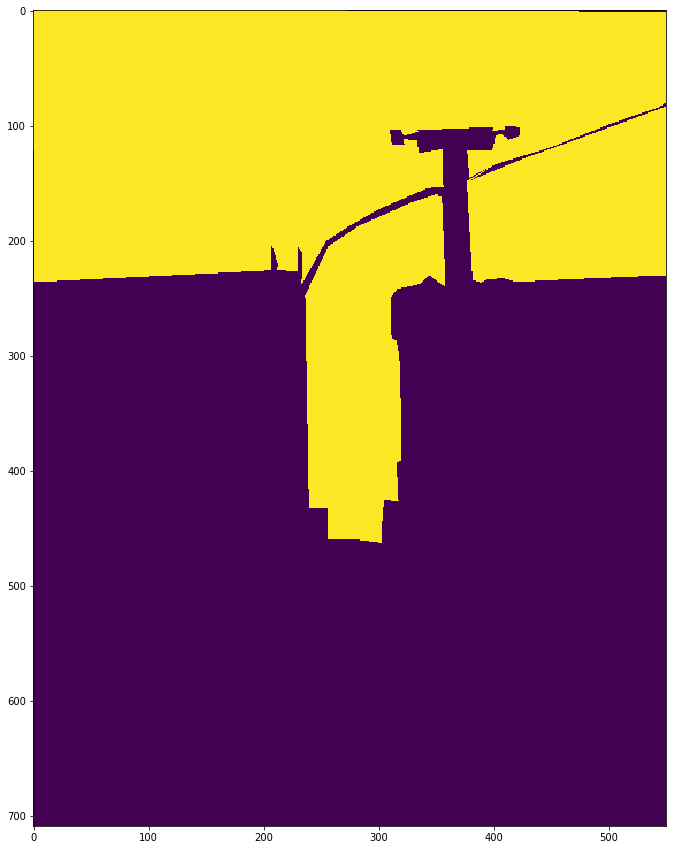

Jakarta_025_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_179_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_179_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_179_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.65466 3.49280, 98.65489 3.49279, ...
1  None  POLYGON ((98.65511 3.49274, 98.65525 3.49271, ...
2  None  POLYGON ((98.65369 3.49244, 98.65372 3.49249, ...
3  None  POLYGON ((98.65375 3.49224, 98.65382 3.49225, ...
4  None  POLYGON ((98.65359 3.49223, 98.65366 3.49220, ...
5  None  POLYGON ((98.65366 3.49206, 98.65373 3.49205, ...
6  None  POLYGON ((98.65365 3.491

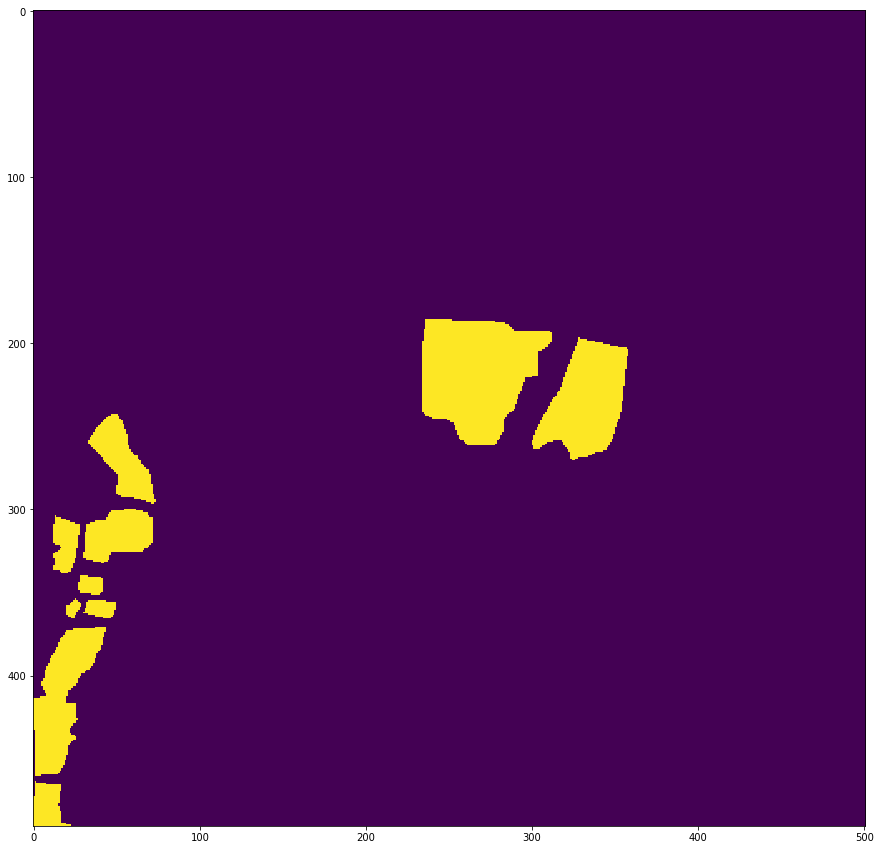

Medan_179_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_004_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_004_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_004_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.95326 -1.23223, 116.95277 -1.232...
1  None  POLYGON ((116.95121 -1.23077, 116.95125 -1.230...
2  None  POLYGON ((116.95235 -1.23090, 116.95277 -1.231...
3  None  POLYGON ((116.95264 -1.23158, 116.95295 -1.231...
4  None  POLYGON ((116.95314 -1.23122, 116.95318 -1.231...
5  None  POLYGON ((116.95269 -1.23030, 116.95271 -1.230...
6  None  POLYGON ((1

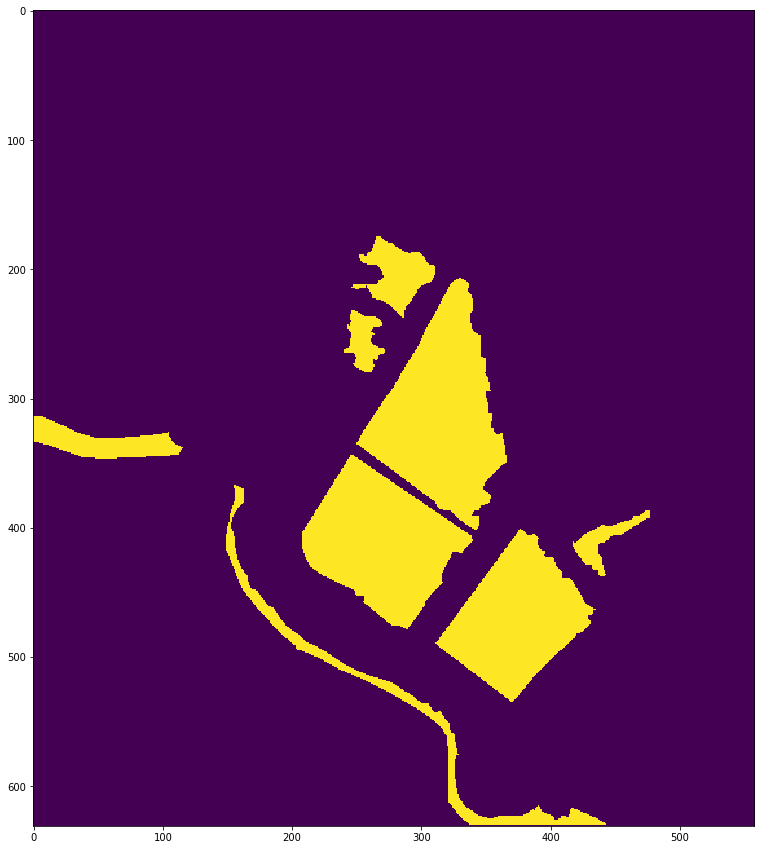

Balikpapan_004_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_381_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_381_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_381_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.64240 -6.25344, 106.64241 -6.253...
1  None  POLYGON ((106.64365 -6.25267, 106.64366 -6.252...


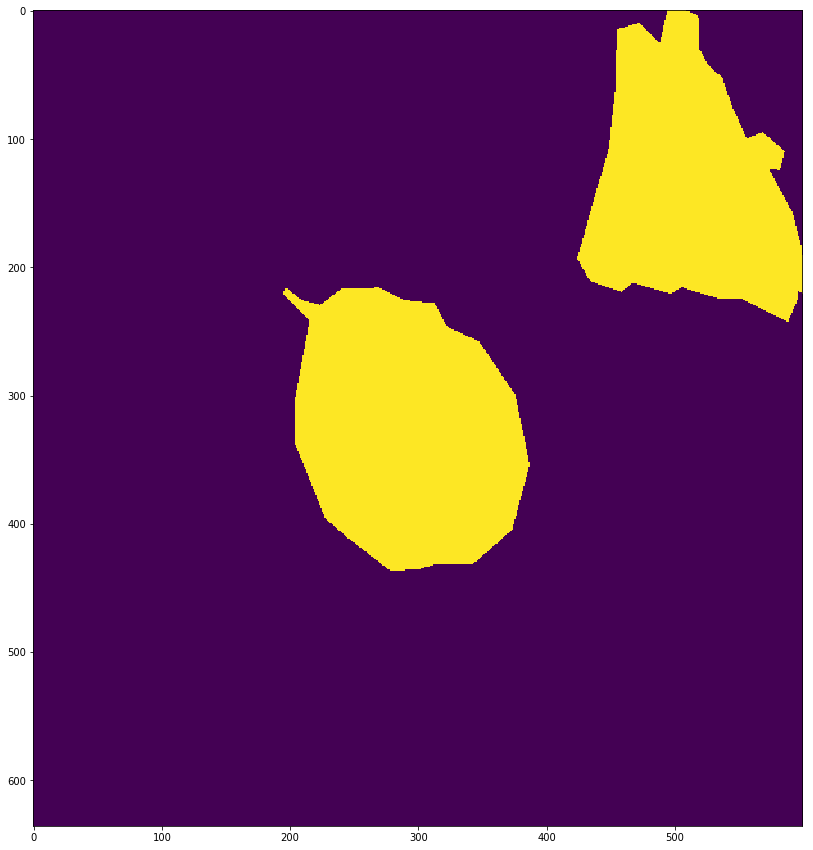

Jakarta_381_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_227_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_227_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_227_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((106.95873 -6.09723, 106.95871 -6.097...
1   None  POLYGON ((106.95948 -6.09760, 106.95955 -6.097...
2   None  POLYGON ((106.95950 -6.09792, 106.95951 -6.097...
3   None  POLYGON ((106.95949 -6.09725, 106.95953 -6.097...
4   None  POLYGON ((106.95882 -6.09817, 106.95882 -6.098...
5   None  POLYGON ((106.95843 -6.09817, 106.95845 -6.098...
6   None  POLYGON ((

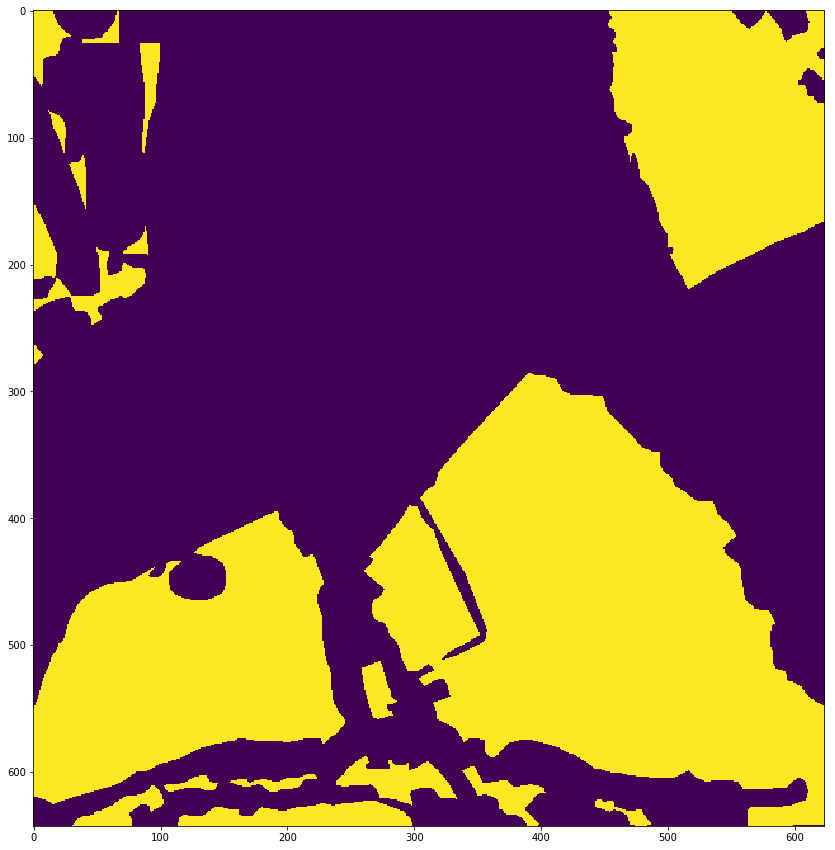

Jakarta_227_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_511_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_511_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_511_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.64185 -6.29906, 106.64176 -6.300...


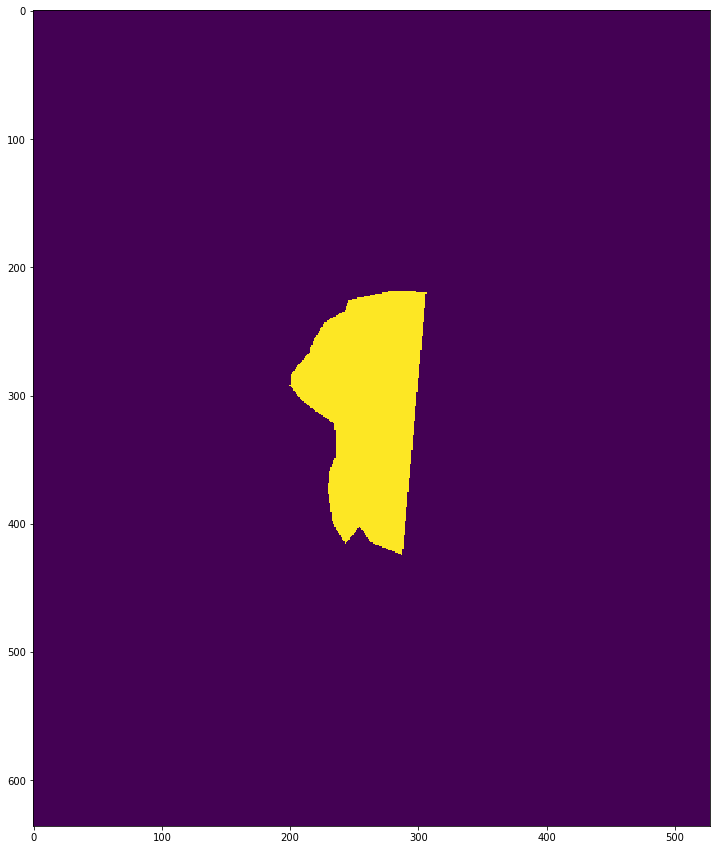

Jakarta_511_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_129_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_129_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_129_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.65362 -6.30009, 106.65359 -6.300...
1  None  POLYGON ((106.65372 -6.30078, 106.65382 -6.300...
2  None  POLYGON ((106.65575 -6.30022, 106.65566 -6.300...


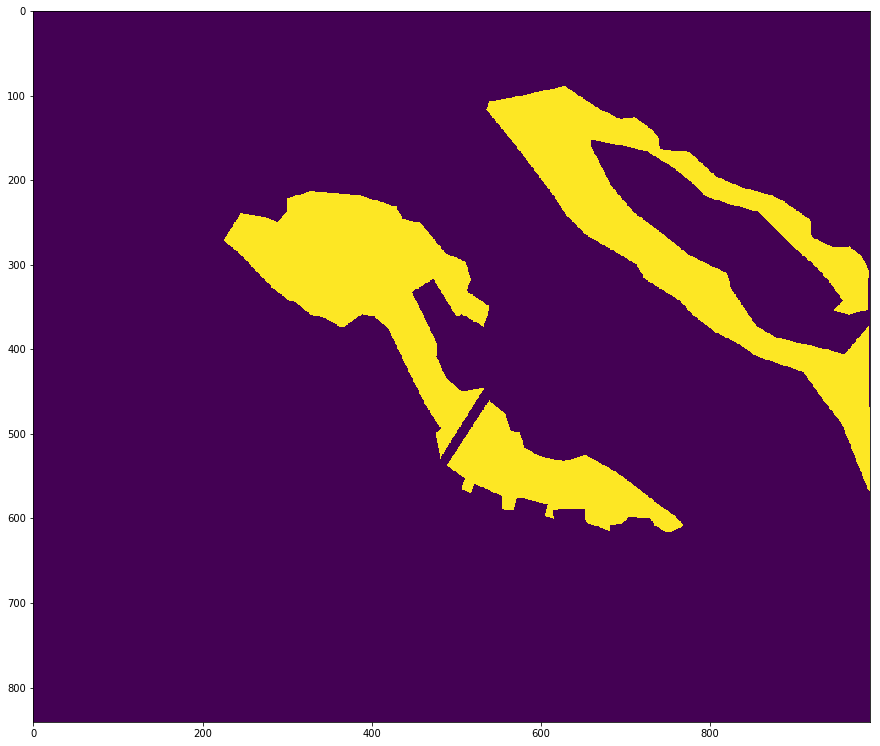

Jakarta_129_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_030_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_030_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_030_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.96083 -6.20633, 106.96097 -6.206...
1  None  POLYGON ((106.96103 -6.20633, 106.96119 -6.206...
2  None  POLYGON ((106.96160 -6.20802, 106.96183 -6.208...
3  None  POLYGON ((106.96183 -6.20753, 106.96183 -6.207...


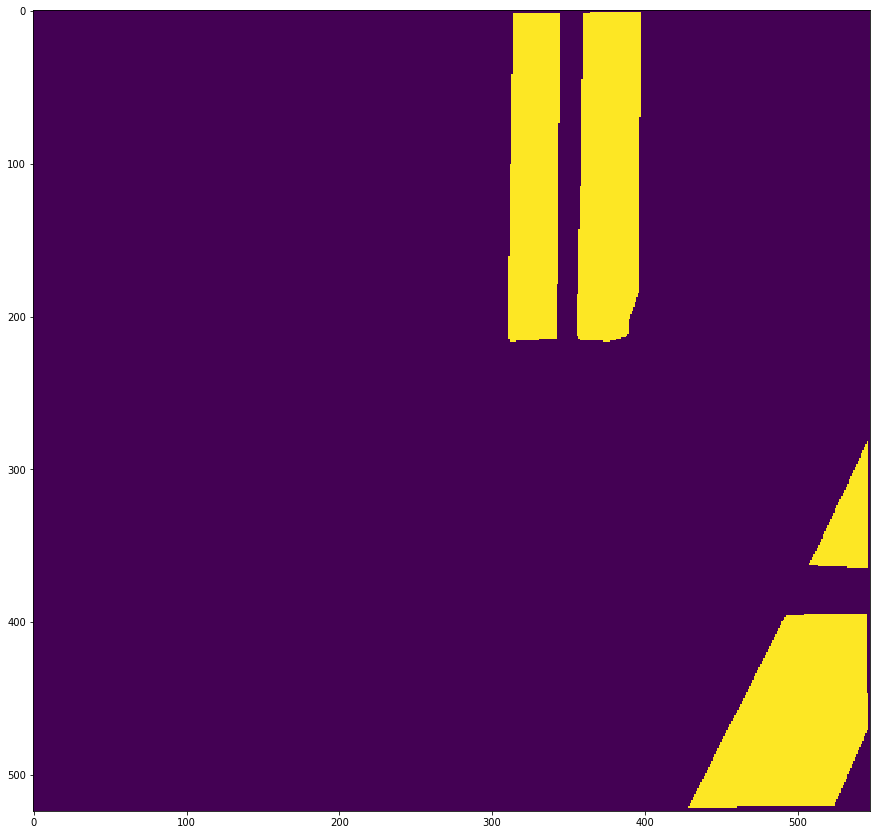

Jakarta_030_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_027_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_027_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_027_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.21814 -8.67474, 115.21821 -8.674...
1  None  POLYGON ((115.21821 -8.67510, 115.21822 -8.675...
2  None  POLYGON ((115.21847 -8.67523, 115.21848 -8.675...
3  None  POLYGON ((115.21890 -8.67533, 115.21890 -8.675...
4  None  POLYGON ((115.21894 -8.67498, 115.21898 -8.674...
5  None  POLYGON ((115.21866 -8.67493, 115.21868 -8.674...
6  None  POLYGON ((115.2

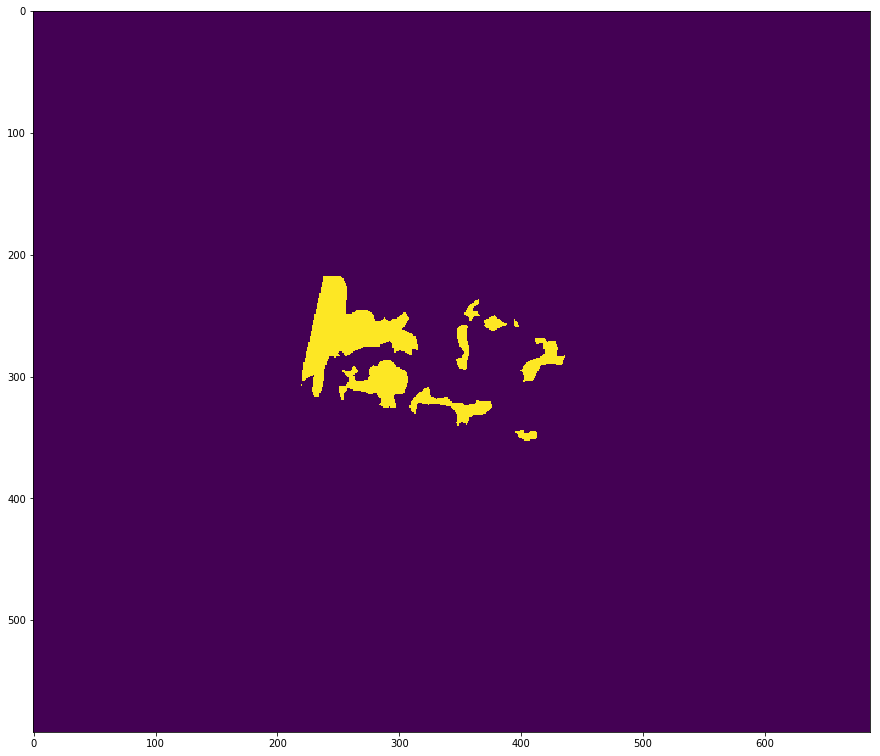

Denpasar_027_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_661_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_661_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_661_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((106.63977 -6.33520, 106.64014 -6.335...
1   None  POLYGON ((106.64017 -6.33508, 106.64027 -6.335...
2   None  POLYGON ((106.63954 -6.33521, 106.63954 -6.335...
3   None  POLYGON ((106.63980 -6.33538, 106.63994 -6.335...
4   None  POLYGON ((106.64025 -6.33524, 106.64036 -6.335...
5   None  POLYGON ((106.64005 -6.33585, 106.64000 -6.335...
6   None  POLYGON (

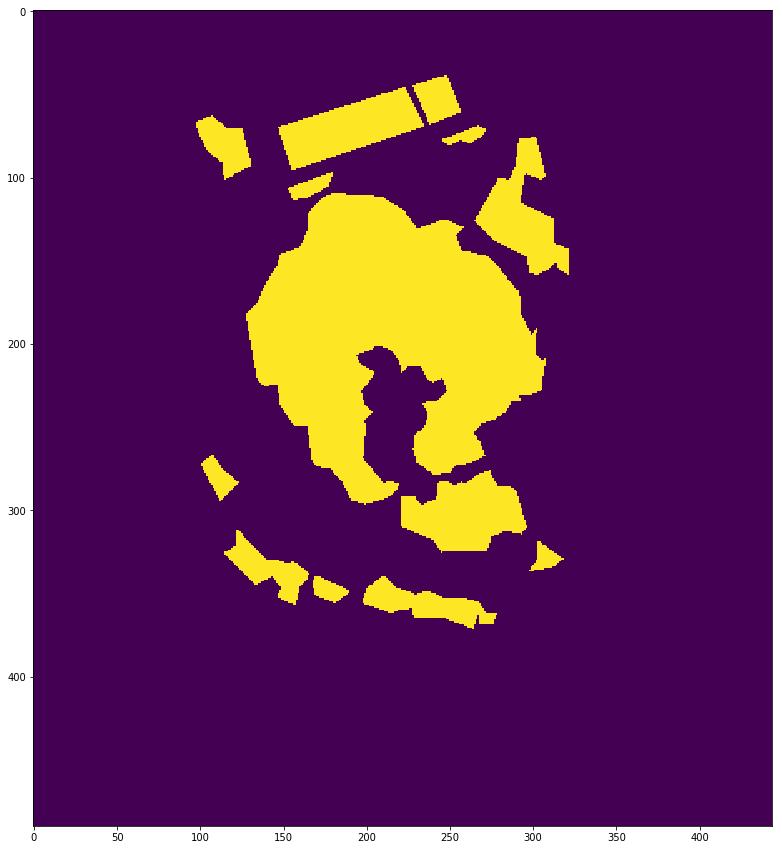

Jakarta_661_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_266_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_266_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_266_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.65592 -6.30144, 106.65591 -6.301...
1  None  POLYGON ((106.65571 -6.30243, 106.65573 -6.302...
2  None  POLYGON ((106.65564 -6.30254, 106.65563 -6.302...
3  None  POLYGON ((106.65564 -6.30269, 106.65566 -6.302...
4  None  POLYGON ((106.65570 -6.30287, 106.65574 -6.302...
5  None  POLYGON ((106.65562 -6.30246, 106.65558 -6.302...
6  None  POLYGON ((106.6555

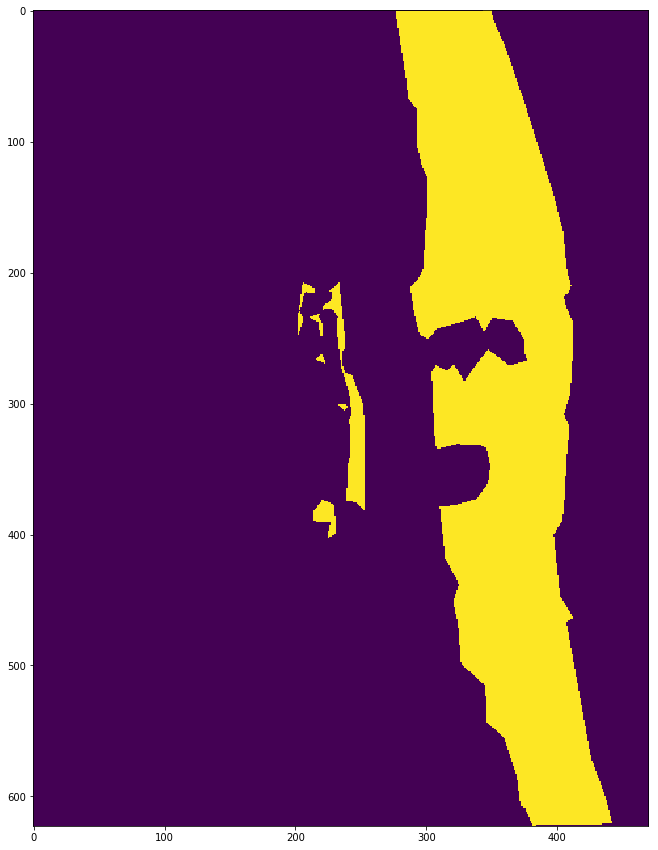

Jakarta_266_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_380_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_380_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_380_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.64364 -6.25244, 106.64368 -6.252...
1  None  POLYGON ((106.64255 -6.25346, 106.64262 -6.253...
2  None  POLYGON ((106.64507 -6.25167, 106.64509 -6.251...


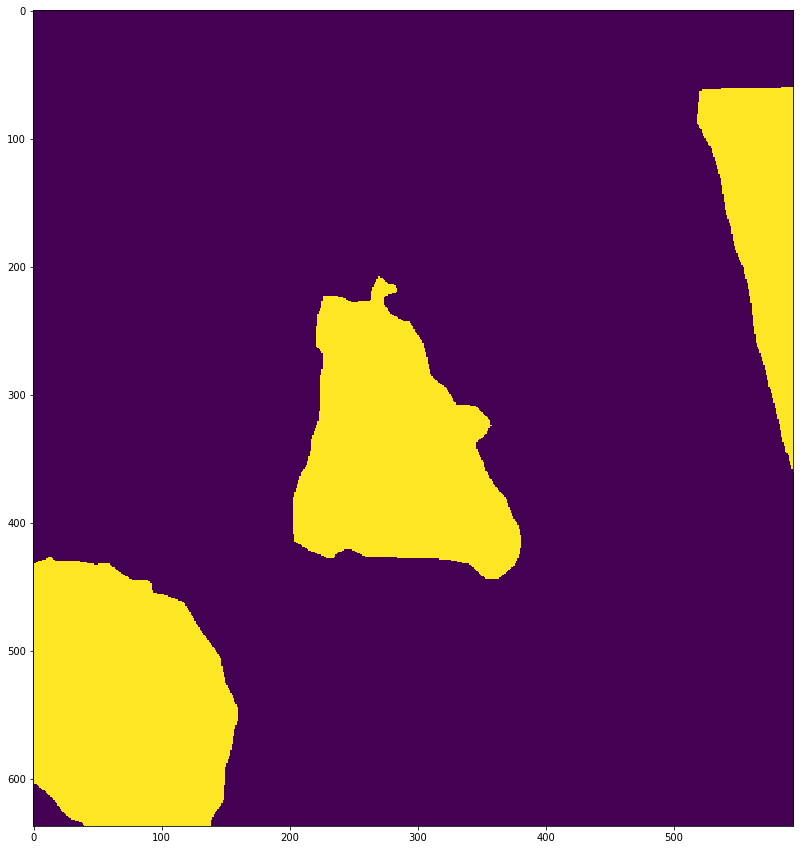

Jakarta_380_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_436_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_436_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_436_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.59320 -6.30700, 106.59326 -6.307...
1  None  POLYGON ((106.59575 -6.30896, 106.59578 -6.308...
2  None  POLYGON ((106.59593 -6.30722, 106.59598 -6.307...
3  None  POLYGON ((106.59502 -6.30866, 106.59509 -6.308...
4  None  POLYGON ((106.59561 -6.30893, 106.59559 -6.308...
5  None  POLYGON ((106.59556 -6.30934, 106.59564 -6.309...
6  None  POLYGON ((106.5947

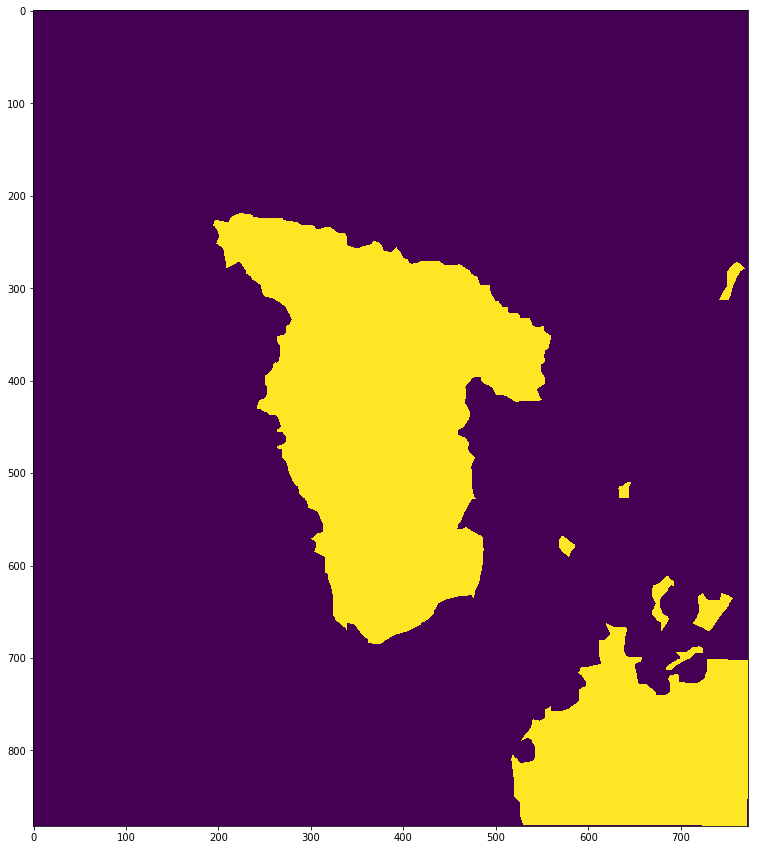

Jakarta_436_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_049_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_049_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_049_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((115.22691 -8.71765, 115.22691 -8.717...
1   None  POLYGON ((115.22689 -8.71765, 115.22693 -8.717...
2   None                                               None
3   None                                               None
4   None  POLYGON ((115.22781 -8.71802, 115.22795 -8.718...
5   None  POLYGON ((115.22820 -8.71802, 115.22825 -8.717...
6   None  POLYGON

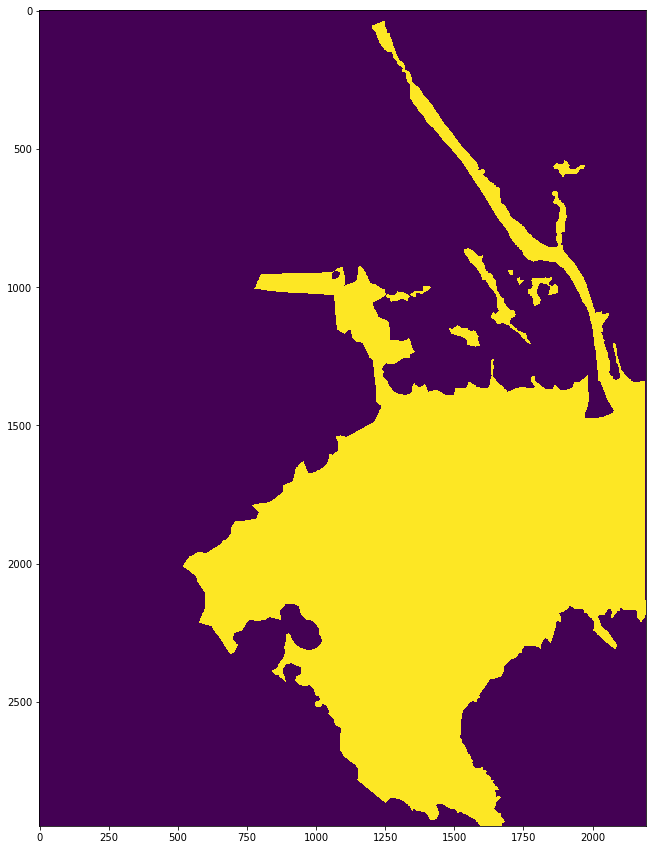

Denpasar_049_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_423_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_423_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_423_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.62502 -6.34548, 106.62504 -6.345...


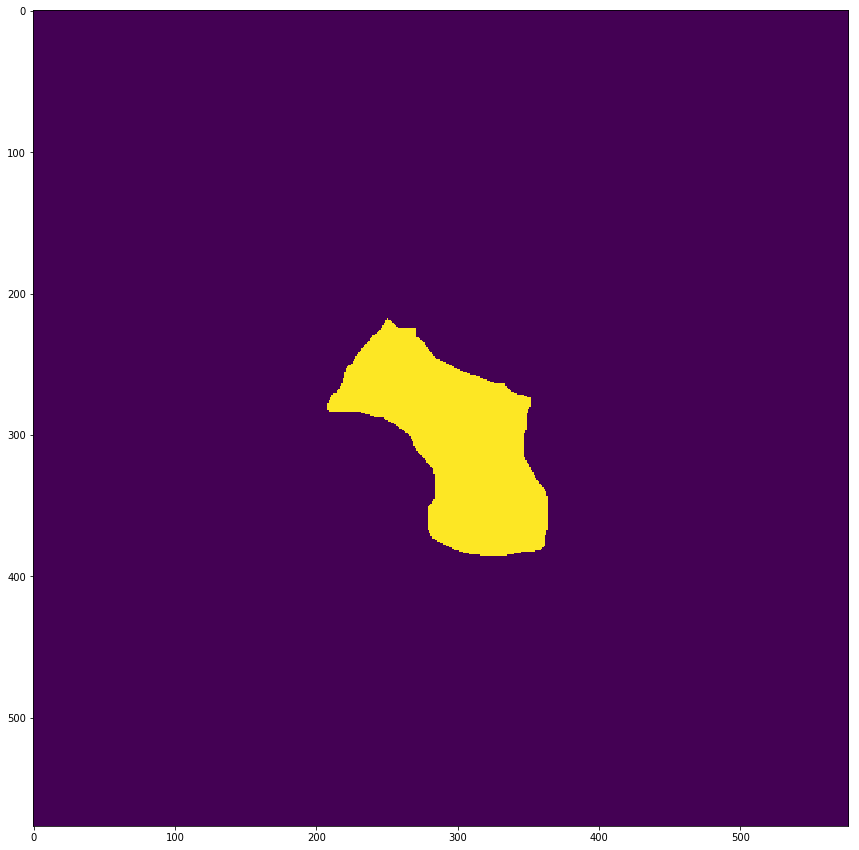

Jakarta_423_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_016_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_016_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_016_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.88171 -1.26076, 116.88189 -1.260...


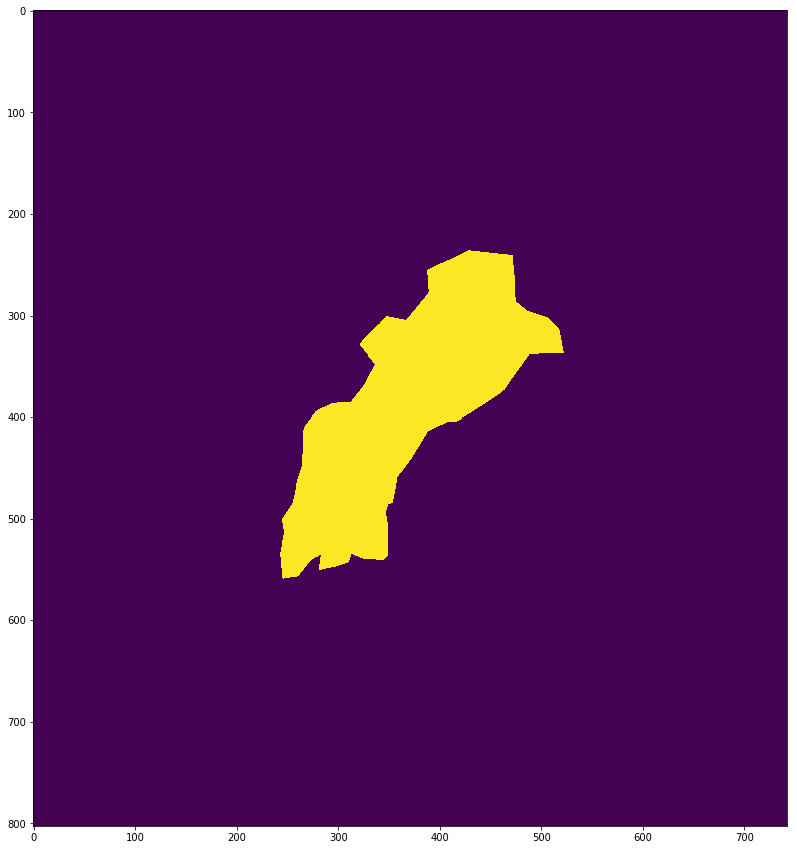

Balikpapan_016_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_290_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_290_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_290_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((106.79680 -6.22038, 106.79684 -6.220...
1   None  POLYGON ((106.79628 -6.21940, 106.79630 -6.219...
2   None  POLYGON ((106.79691 -6.21876, 106.79692 -6.218...
3   None  POLYGON ((106.79704 -6.21828, 106.79708 -6.218...
4   None  POLYGON ((106.79675 -6.21743, 106.79677 -6.217...
5   None  POLYGON ((106.79605 -6.21702, 106.79607 -6.217...
6   None  POLYGON

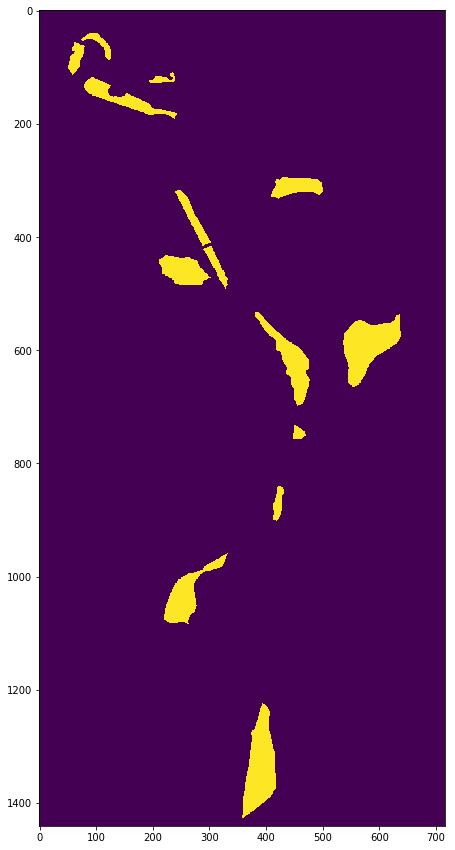

Jakarta_290_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_289_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_289_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_289_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.79642 -6.21693, 106.79654 -6.217...
1  None  POLYGON ((106.79669 -6.21734, 106.79674 -6.217...
2  None  POLYGON ((106.79672 -6.21744, 106.79677 -6.217...
3  None  POLYGON ((106.79702 -6.21820, 106.79705 -6.218...
4  None  POLYGON ((106.79690 -6.21874, 106.79693 -6.218...
5  None  POLYGON ((106.79742 -6.21755, 106.79748 -6.217...


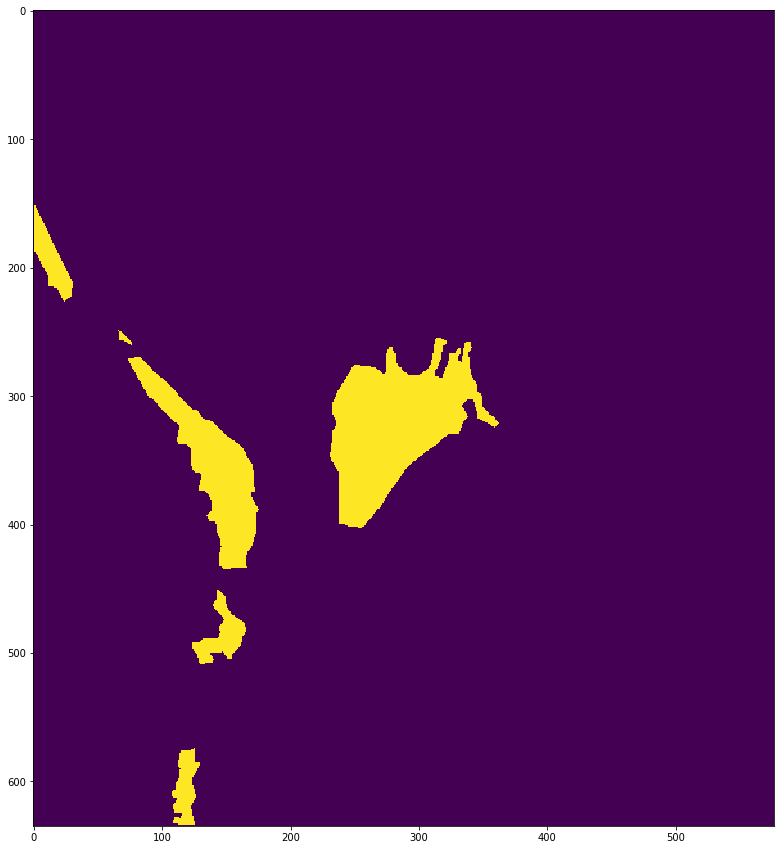

Jakarta_289_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_118_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_118_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_118_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.78886 -6.32405, 106.78891 -6.324...


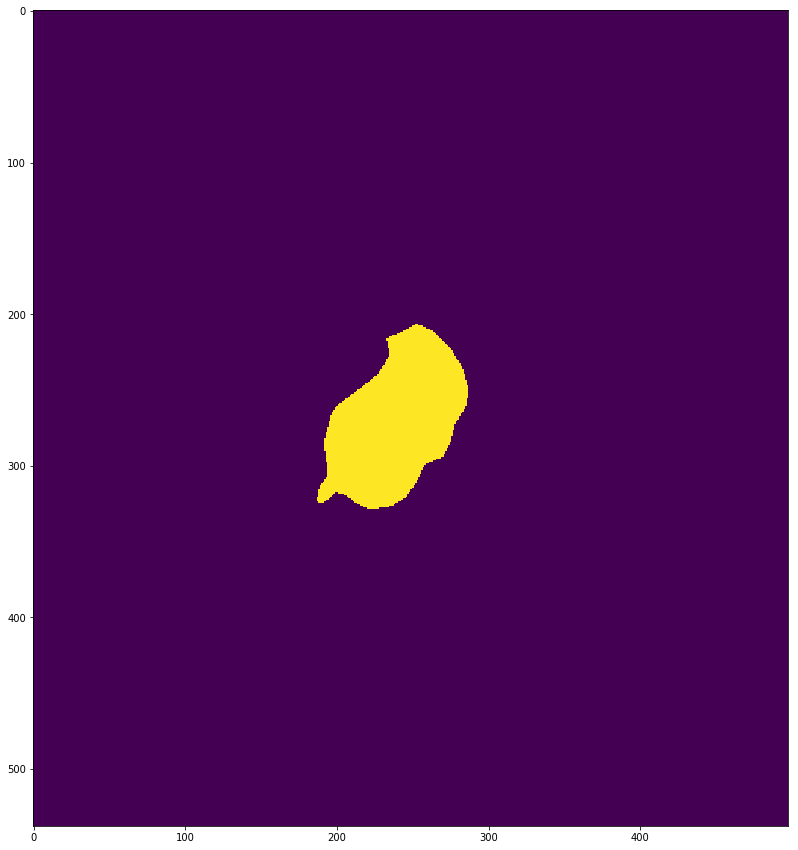

Jakarta_118_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_014_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_014_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_014_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.87753 -1.25313, 116.87757 -1.253...
1  None  POLYGON ((116.87845 -1.25243, 116.87847 -1.252...


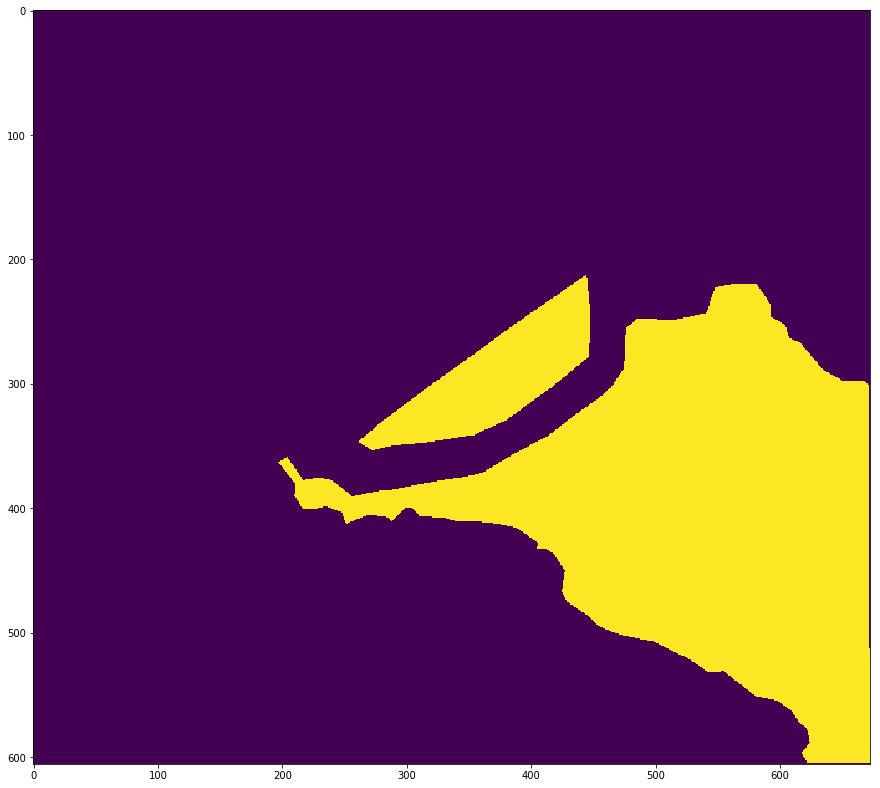

Balikpapan_014_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_027_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_027_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_027_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.82739 -1.21846, 116.82739 -1.218...
1  None  POLYGON ((116.82732 -1.21918, 116.82730 -1.219...
2  None  POLYGON ((116.82701 -1.21745, 116.82697 -1.217...
3  None  POLYGON ((116.82724 -1.21647, 116.82749 -1.216...
4  None  POLYGON ((116.82710 -1.21914, 116.82716 -1.218...
5  None  POLYGON ((116.82714 -1.21876, 116.82714 -1.218...
6  None  POLYGO

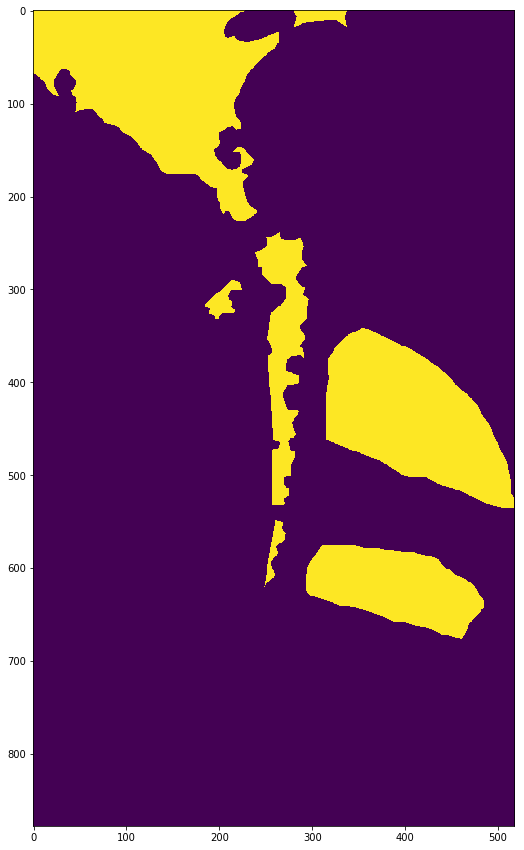

Balikpapan_027_pansharpen_True_2019-03-10_02:44_103001008BD5FD00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_014_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_014_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_014_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.64151 3.62195, 98.64150 3.62193, ...
1  None  POLYGON ((98.64031 3.62243, 98.64035 3.62243, ...
2  None  POLYGON ((98.64376 3.62328, 98.64390 3.62328, ...


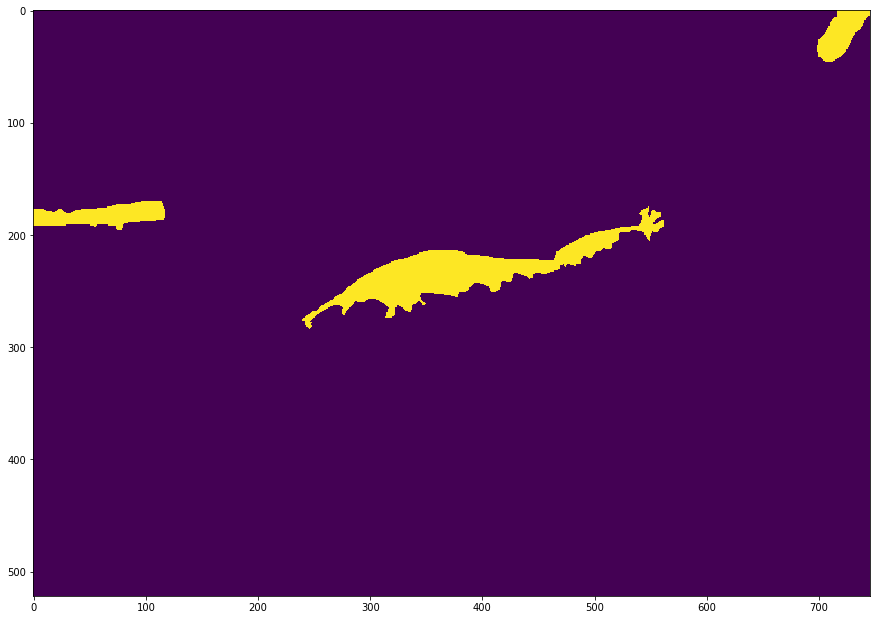

Medan_014_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_587_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_587_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_587_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.61185 -6.27268, 106.61189 -6.272...
1  None  POLYGON ((106.61280 -6.27110, 106.61283 -6.271...


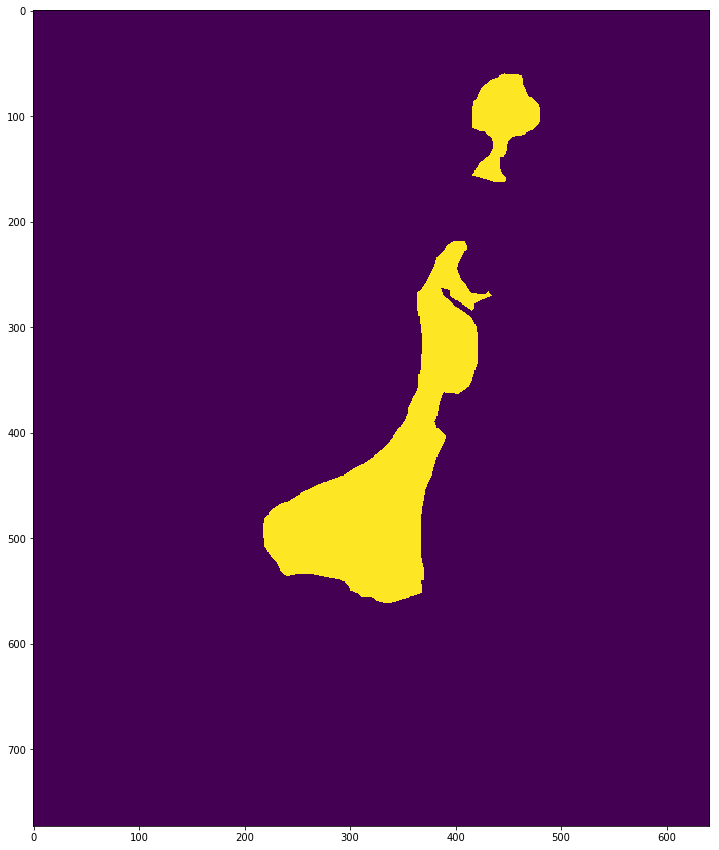

Jakarta_587_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_394_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_394_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_394_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.92202 -6.21083, 106.92208 -6.210...
1  None  POLYGON ((106.92301 -6.21115, 106.92300 -6.211...


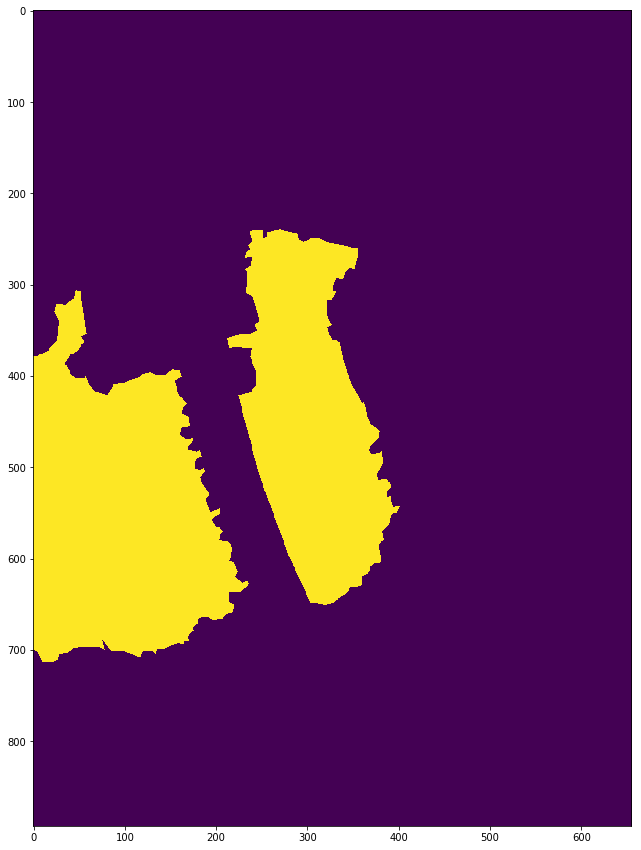

Jakarta_394_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_068_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_068_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_068_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.82281 -6.19469, 106.82293 -6.194...


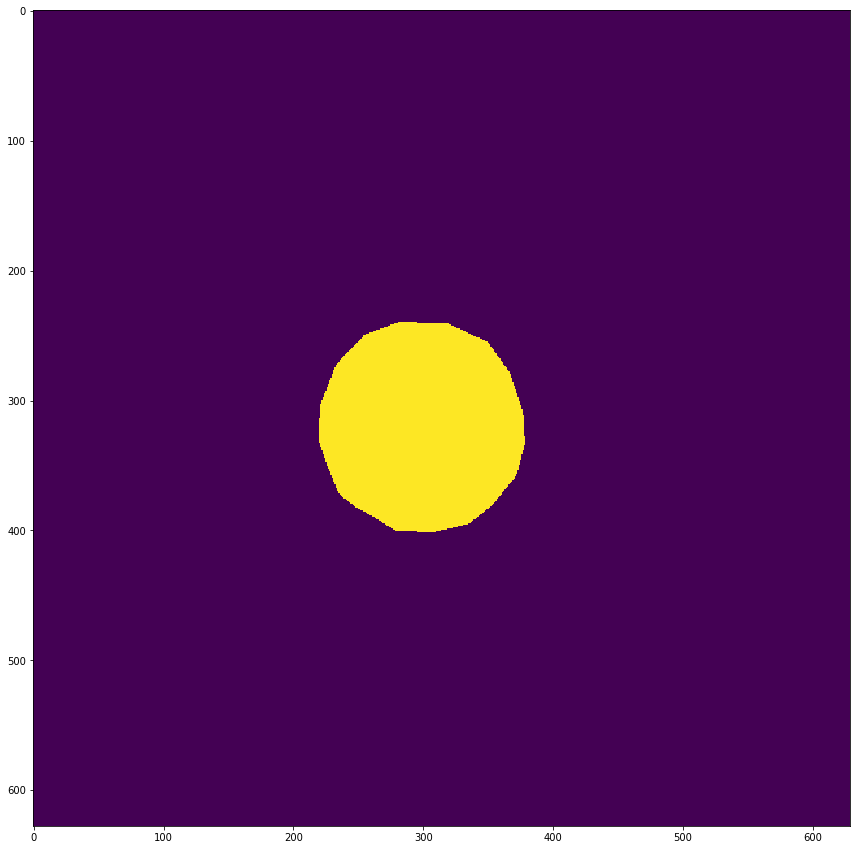

Jakarta_068_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Cilegon_005_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Cilegon_005_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Cilegon_005_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.06421 -5.88121, 106.06427 -5.881...
1  None  POLYGON ((106.06213 -5.88183, 106.06213 -5.880...
2  None  POLYGON ((106.06360 -5.88100, 106.06376 -5.880...
3  None  POLYGON ((106.06385 -5.88089, 106.06403 -5.880...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


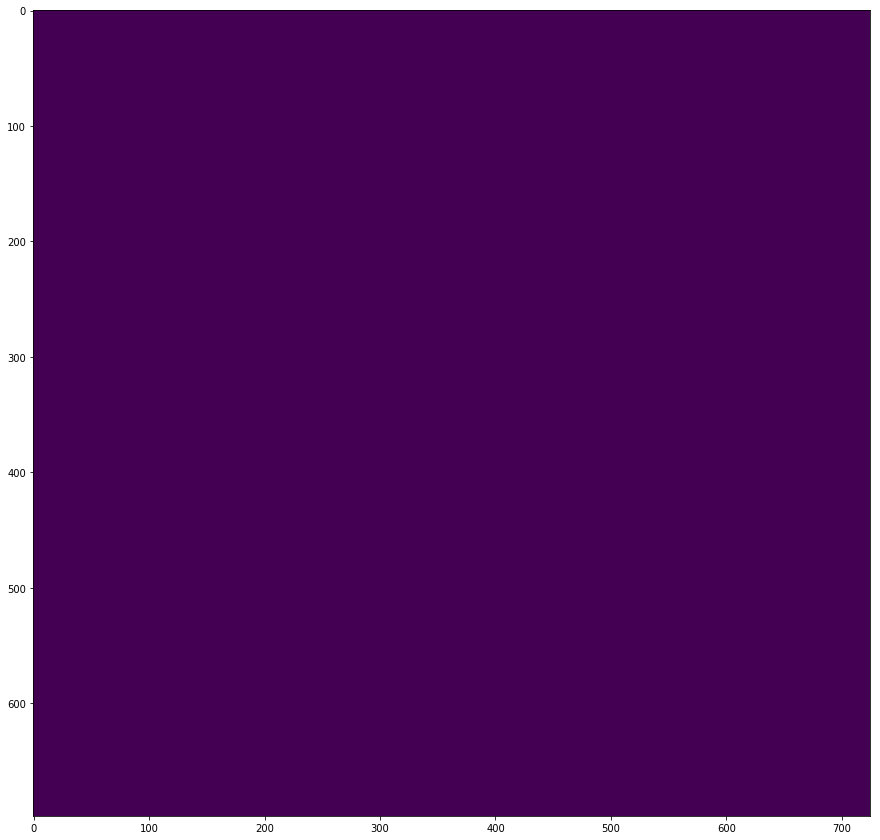

Cilegon_005_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_034_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_034_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_034_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.86366 -6.10258, 106.87325 -6.102...
1  None  POLYGON ((106.86868 -6.11499, 106.86886 -6.115...
2  None  POLYGON ((106.87034 -6.11490, 106.87062 -6.114...


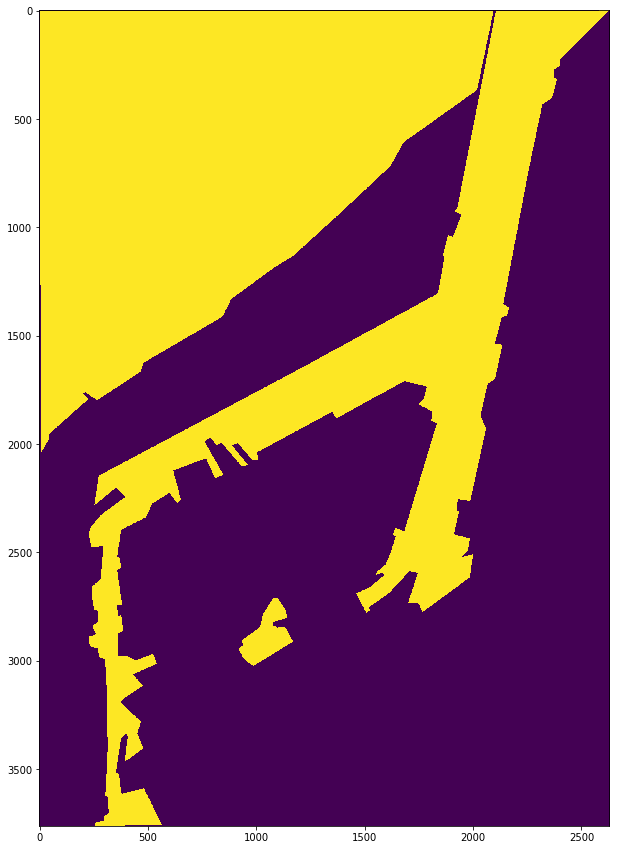

Jakarta_034_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_270_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_270_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_270_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.61123 3.51419, 98.61125 3.51422, ...
1  None  POLYGON ((98.61141 3.51408, 98.61145 3.51411, ...
2  None  POLYGON ((98.61160 3.51395, 98.61169 3.51399, ...
3  None  POLYGON ((98.61220 3.51391, 98.61222 3.51392, ...


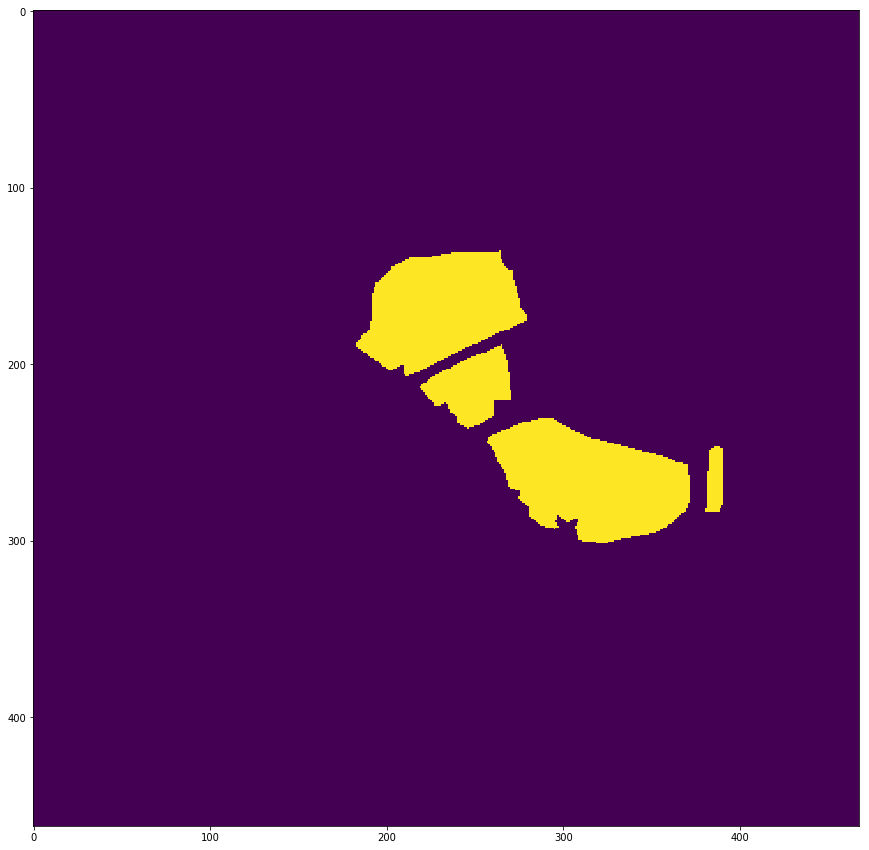

Medan_270_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_298_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_298_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_298_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.72669 -6.09703, 106.72670 -6.097...
1  None  POLYGON ((106.72740 -6.09703, 106.72810 -6.097...
2  None  POLYGON ((106.72811 -6.09702, 106.72878 -6.097...


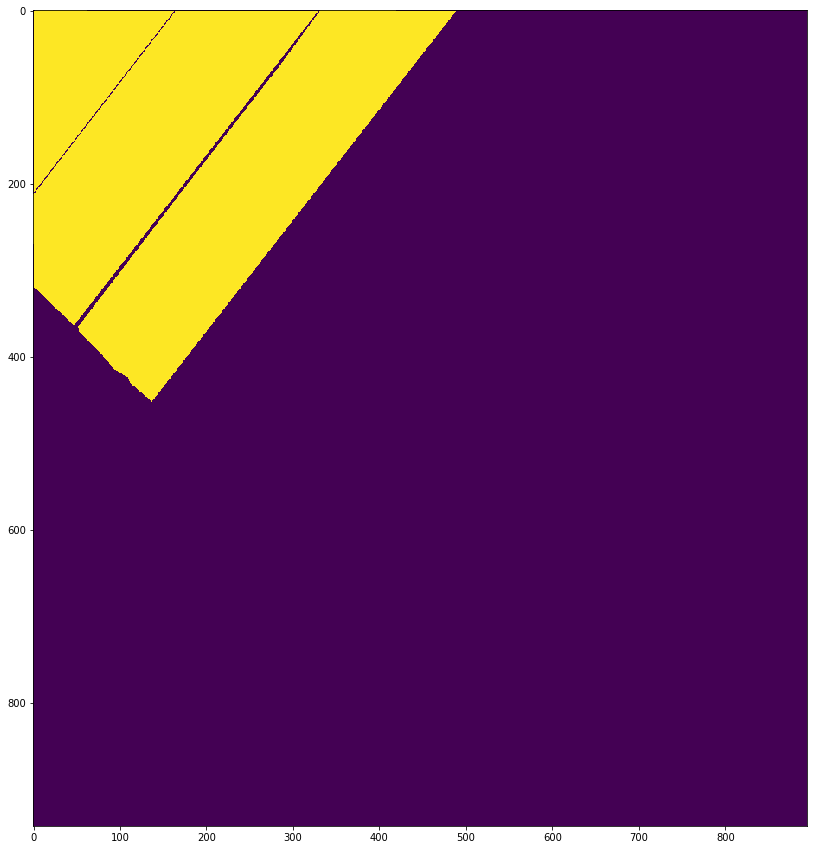

Jakarta_298_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_340_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_340_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_340_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.62902 -6.33193, 106.62898 -6.332...
1  None                                               None
2  None                                               None
3  None  POLYGON ((106.62739 -6.33310, 106.62767 -6.332...
4  None  POLYGON ((106.62653 -6.33351, 106.62661 -6.333...


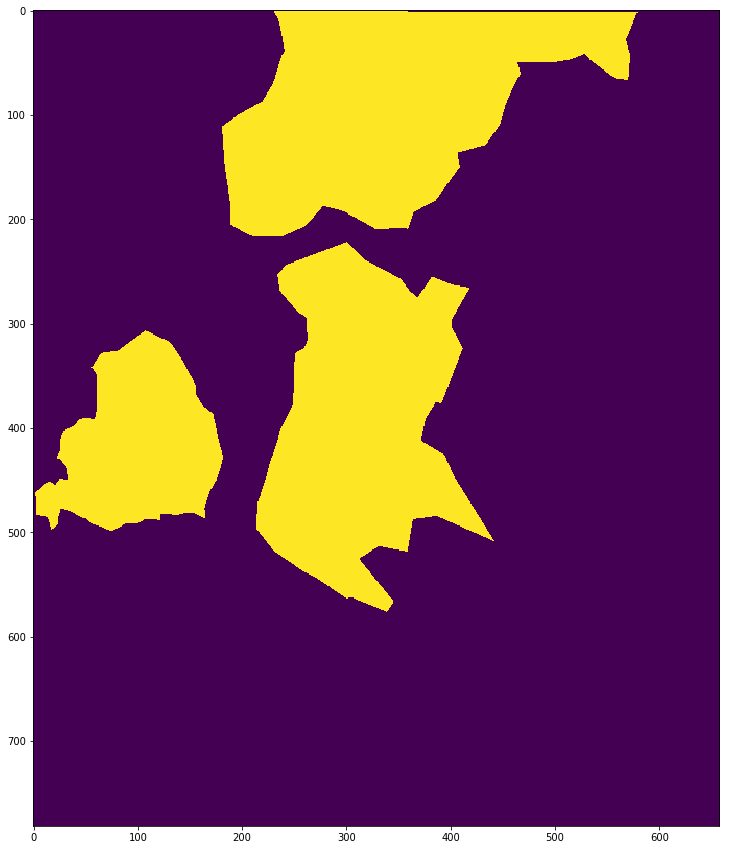

Jakarta_340_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_042_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_042_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_042_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.18491 -8.74777, 115.18494 -8.747...
1  None  POLYGON ((115.18468 -8.74661, 115.18468 -8.746...


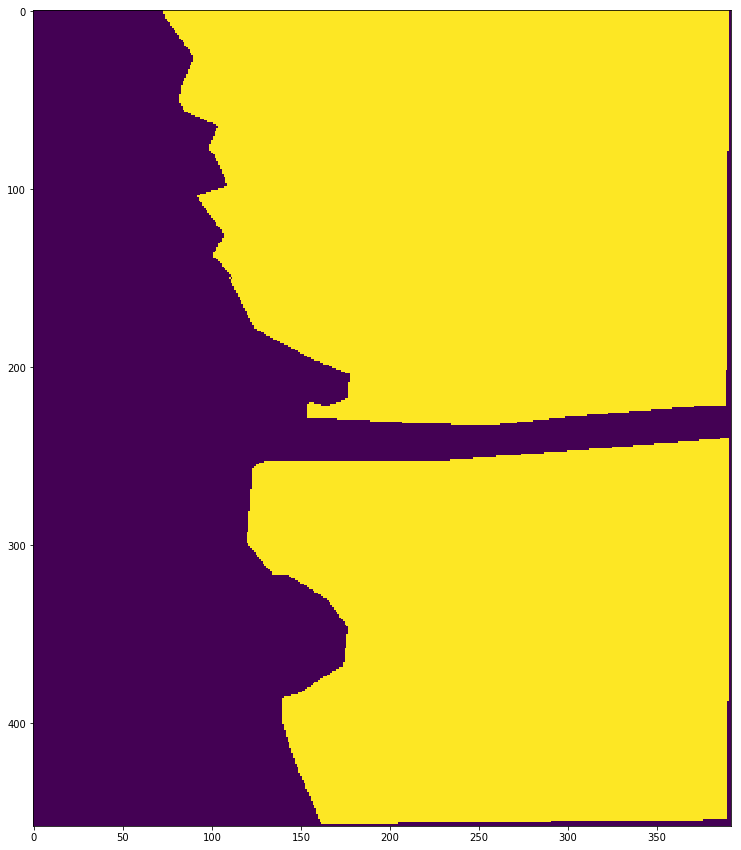

Denpasar_042_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_662_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_662_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_662_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((106.64023 -6.33625, 106.64029 -6.336...
1   None  POLYGON ((106.63967 -6.33639, 106.63975 -6.336...
2   None  POLYGON ((106.64051 -6.33643, 106.64056 -6.336...
3   None  POLYGON ((106.64001 -6.33586, 106.64002 -6.335...
4   None  POLYGON ((106.63978 -6.33520, 106.64015 -6.335...
5   None  POLYGON ((106.63980 -6.33528, 106.64018 -6.335...
6   None  POLYGON (

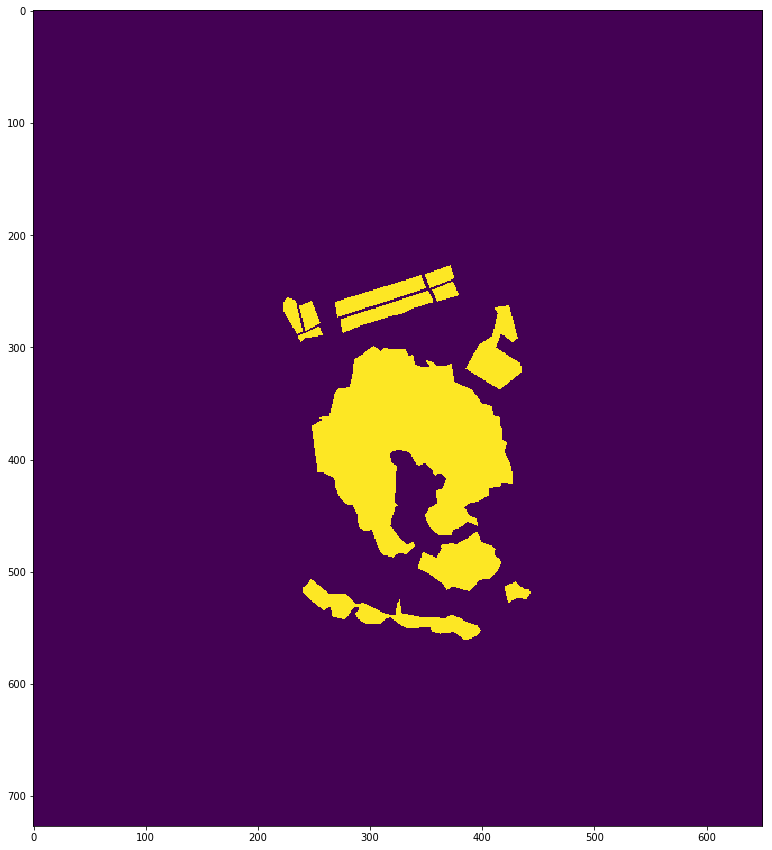

Jakarta_662_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_124_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_124_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_124_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.62253 -6.34204, 106.62248 -6.342...
1  None  POLYGON ((106.62434 -6.34092, 106.62439 -6.340...
2  None  POLYGON ((106.62508 -6.34349, 106.62531 -6.343...
3  None  POLYGON ((106.62554 -6.34427, 106.62563 -6.344...
4  None  POLYGON ((106.62599 -6.34426, 106.62614 -6.344...
5  None  POLYGON ((106.62458 -6.34485, 106.62461 -6.344...


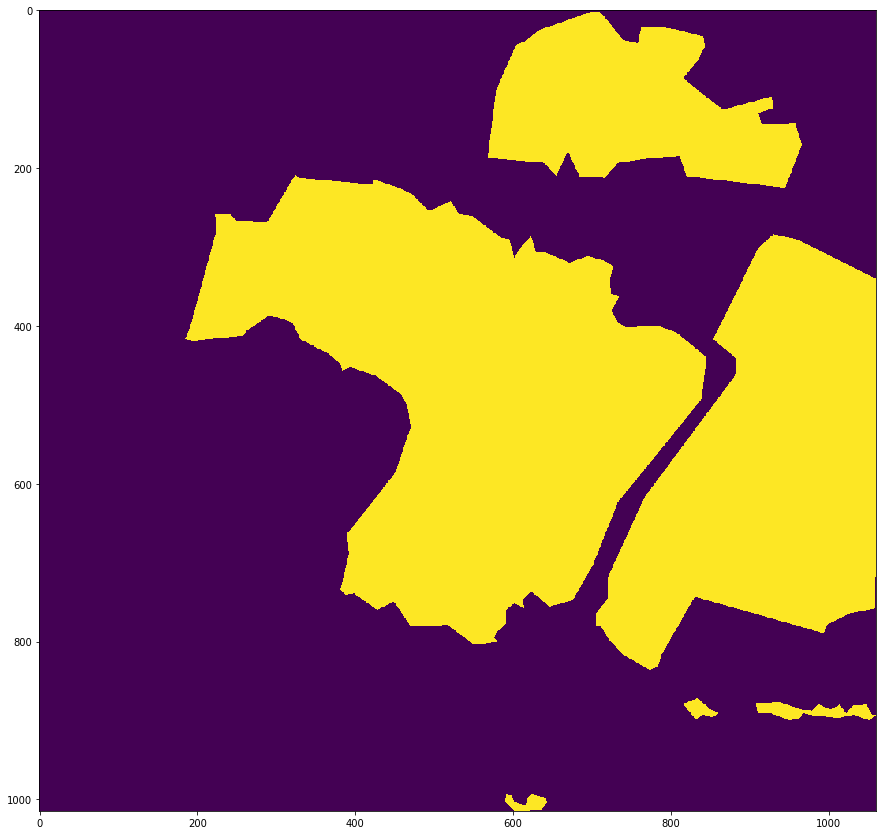

Jakarta_124_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_336_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_336_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_336_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.62280 -6.35384, 106.62275 -6.353...
1  None  POLYGON ((106.62442 -6.35318, 106.62456 -6.353...
2  None  POLYGON ((106.62204 -6.35220, 106.62212 -6.352...
3  None  POLYGON ((106.62179 -6.35273, 106.62185 -6.352...
4  None  POLYGON ((106.62484 -6.35327, 106.62470 -6.353...
5  None  POLYGON ((106.62524 -6.35560, 106.62521 -6.355...


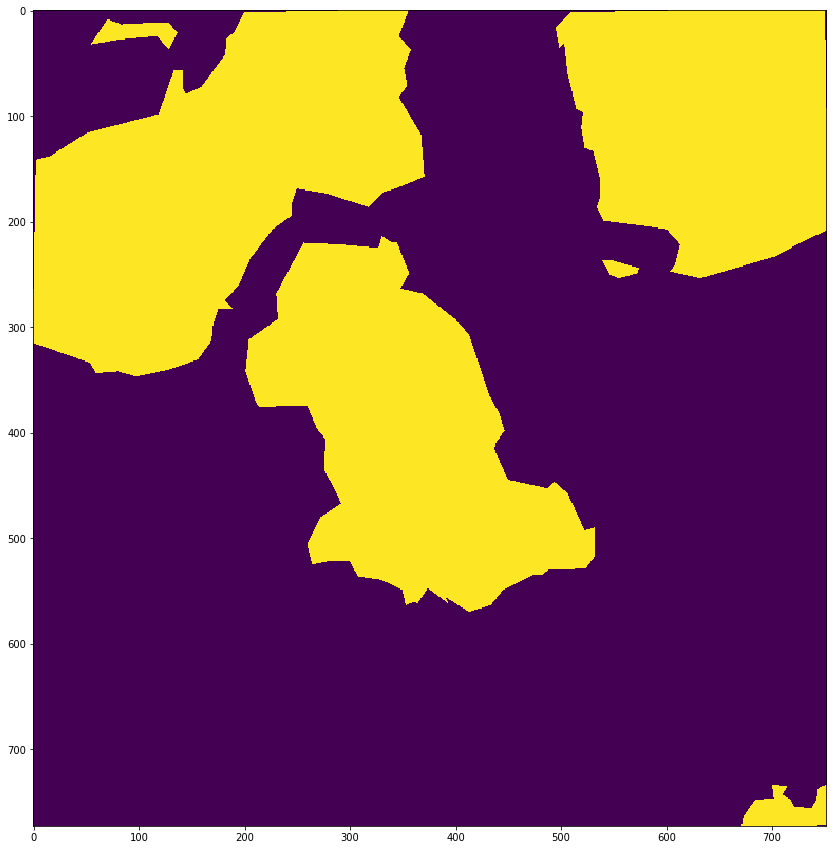

Jakarta_336_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_005_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_005_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_005_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.20537 -8.71830, 115.20561 -8.718...
1  None  POLYGON ((115.20638 -8.71851, 115.20643 -8.718...
2  None  POLYGON ((115.20611 -8.71966, 115.20612 -8.719...
3  None                                               None
4  None  POLYGON ((115.20504 -8.71950, 115.20586 -8.719...
5  None  POLYGON ((115.20682 -8.71750, 115.20726 -8.717...
6  None  POLYGON ((115.2

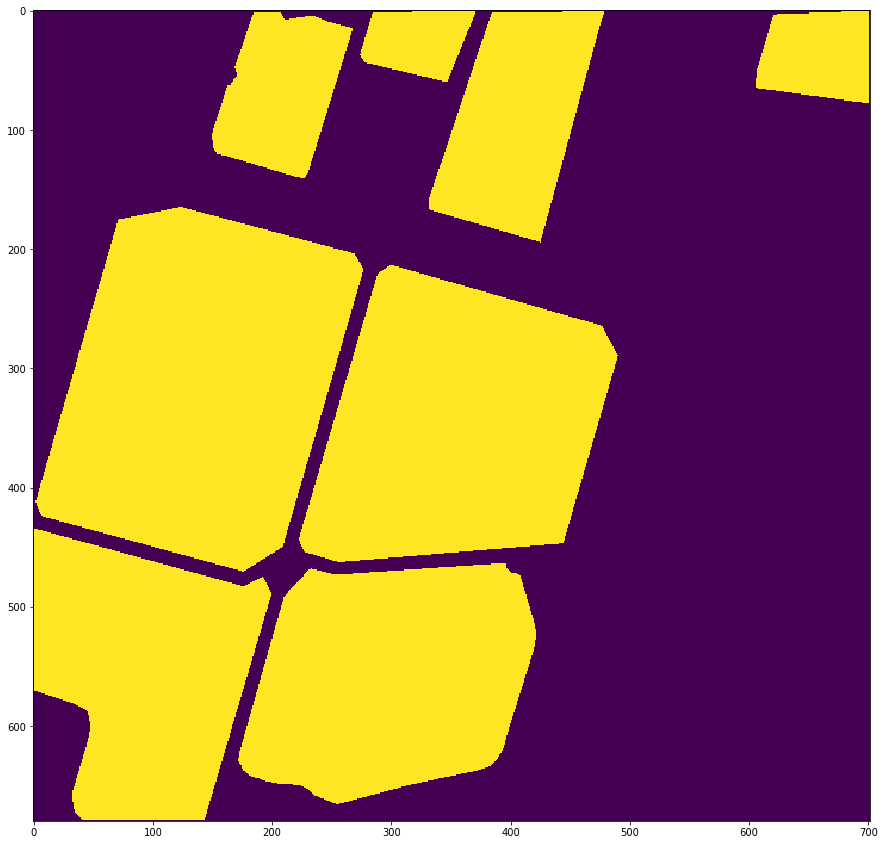

Denpasar_005_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_192_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_192_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_192_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.63510 -6.25534, 106.63507 -6.255...
1  None  POLYGON ((106.63494 -6.25525, 106.63504 -6.255...
2  None  POLYGON ((106.63409 -6.25563, 106.63440 -6.255...
3  None  POLYGON ((106.63612 -6.25448, 106.63621 -6.254...
4  None  POLYGON ((106.63629 -6.25449, 106.63634 -6.254...


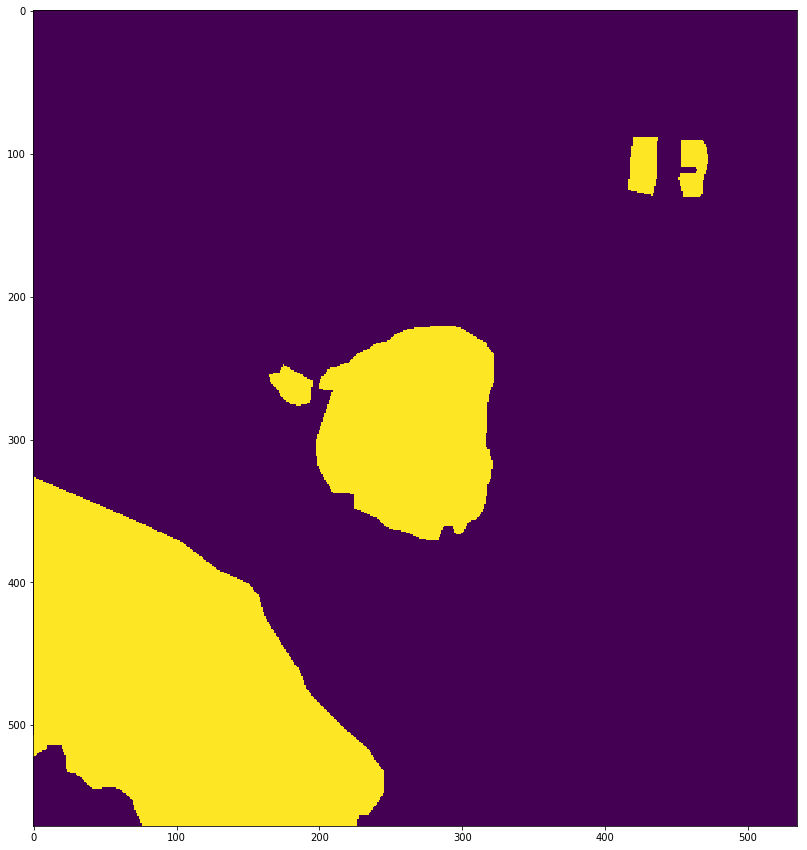

Jakarta_192_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Cilegon_017_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Cilegon_017_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Cilegon_017_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((13809634.301 -17095579.281, 13809616...
1  None  POLYGON ((13810171.828 -17095561.310, 13810149...
2  None  POLYGON ((106.042 -6.008, 106.042 -6.008, 106....
3  None  POLYGON ((106.043 -6.009, 106.043 -6.009, 106....


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


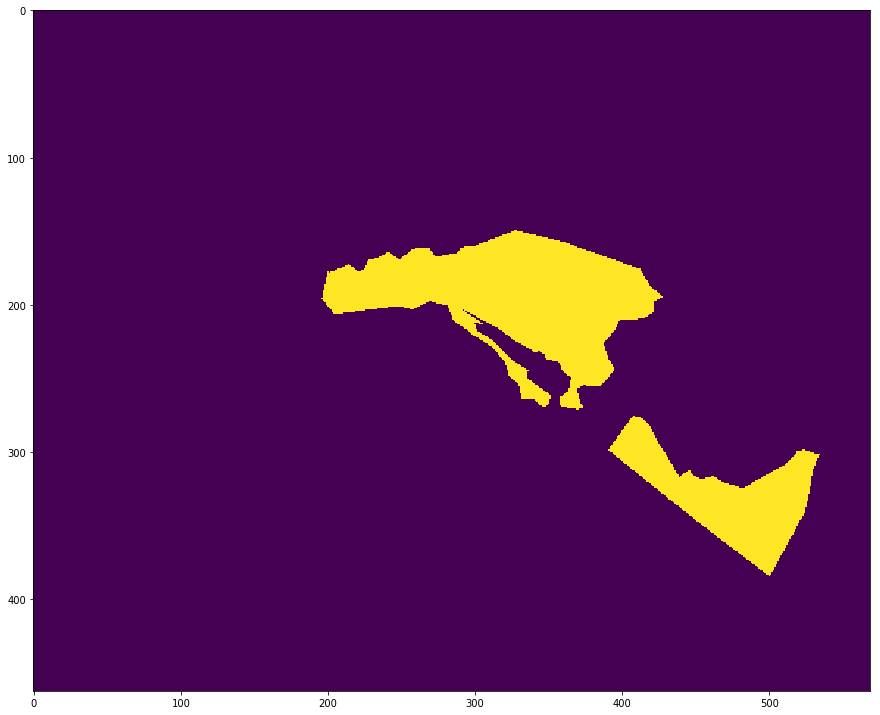

Cilegon_017_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_434_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_434_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_434_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.73871 -6.13680, 106.73874 -6.136...
1  None  POLYGON ((106.73974 -6.13663, 106.73973 -6.136...
2  None  POLYGON ((106.74071 -6.13769, 106.74064 -6.137...
3  None  POLYGON ((106.74011 -6.13650, 106.74013 -6.136...


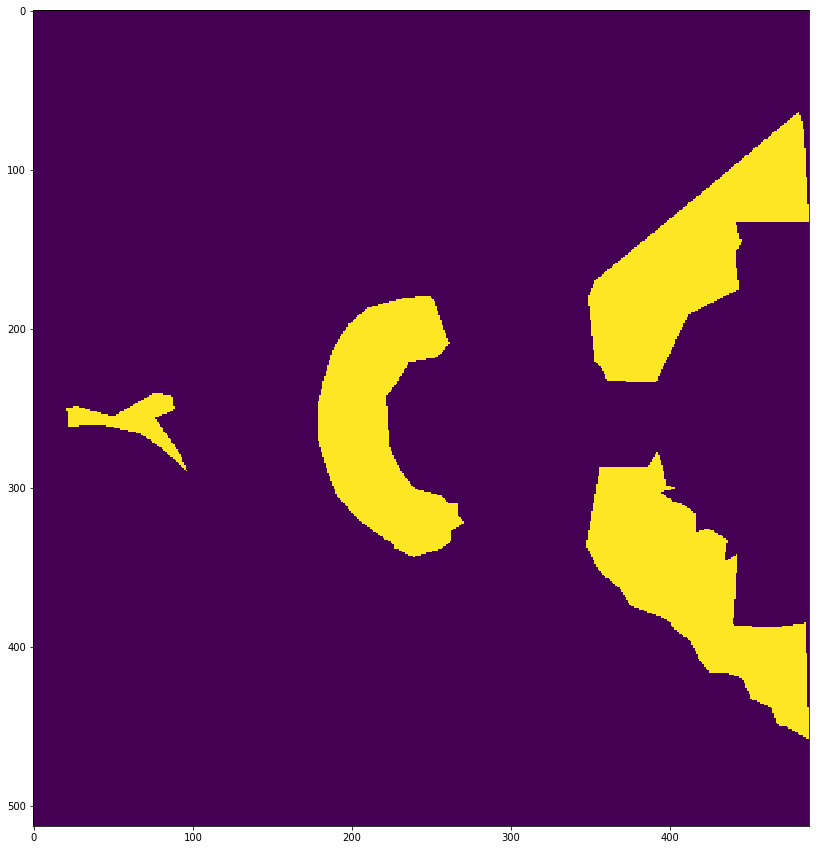

Jakarta_434_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_503_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_503_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_503_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.78500 -6.26701, 106.78497 -6.266...
1  None  POLYGON ((106.78521 -6.26436, 106.78529 -6.264...
2  None  POLYGON ((106.78525 -6.26456, 106.78533 -6.264...
3  None  POLYGON ((106.78540 -6.26503, 106.78545 -6.265...
4  None  POLYGON ((106.78603 -6.26578, 106.78608 -6.265...
5  None  POLYGON ((106.78684 -6.26669, 106.78687 -6.266...
6  None  POLYGON ((106.7849

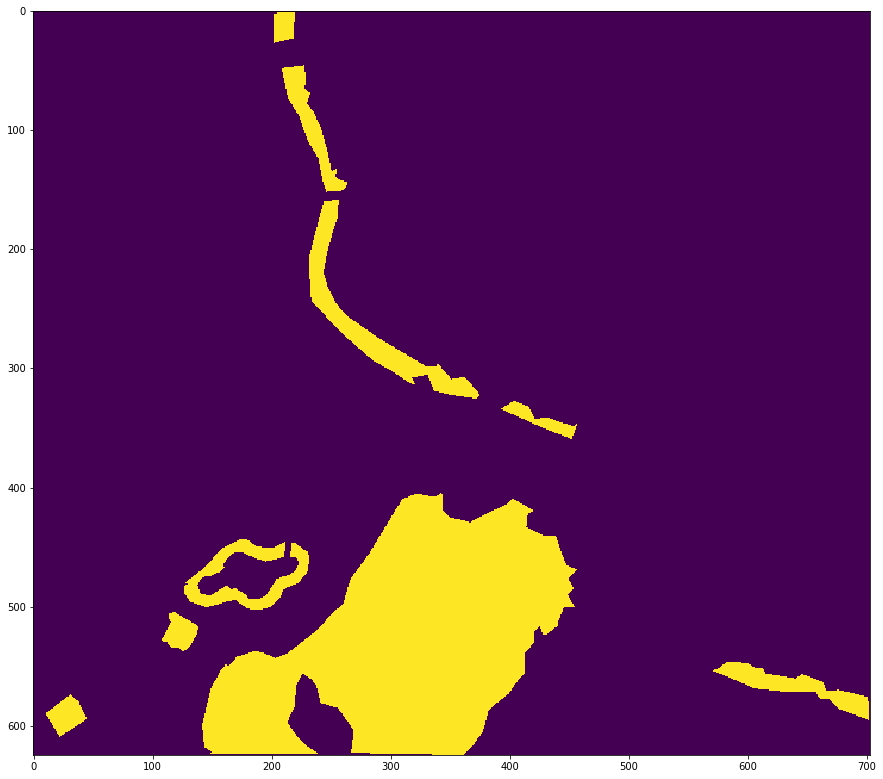

Jakarta_503_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Denpasar_048_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Denpasar_048_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Denpasar_048_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((115.24678 -8.71262, 115.24678 -8.720...
1  None  POLYGON ((115.23115 -8.72005, 115.23116 -8.720...
2  None  POLYGON ((115.23131 -8.72009, 115.23136 -8.720...
3  None  POLYGON ((115.23089 -8.72043, 115.22741 -8.720...
4  None  POLYGON ((115.22885 -8.71856, 115.22891 -8.718...


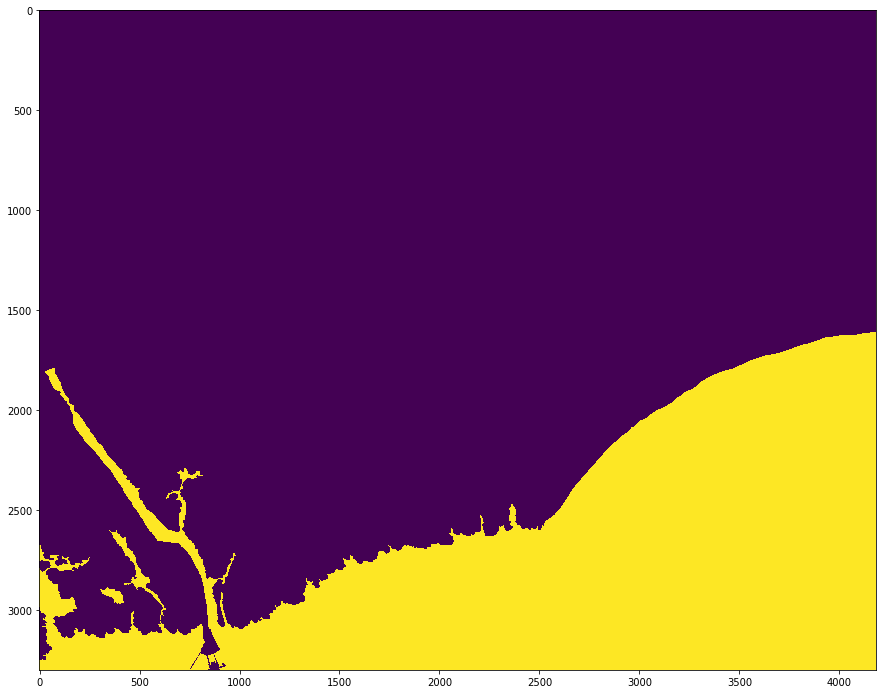

Denpasar_048_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_169_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_169_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_169_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.75808 -6.15185, 106.75812 -6.151...
1  None  POLYGON ((106.75780 -6.15091, 106.75778 -6.150...


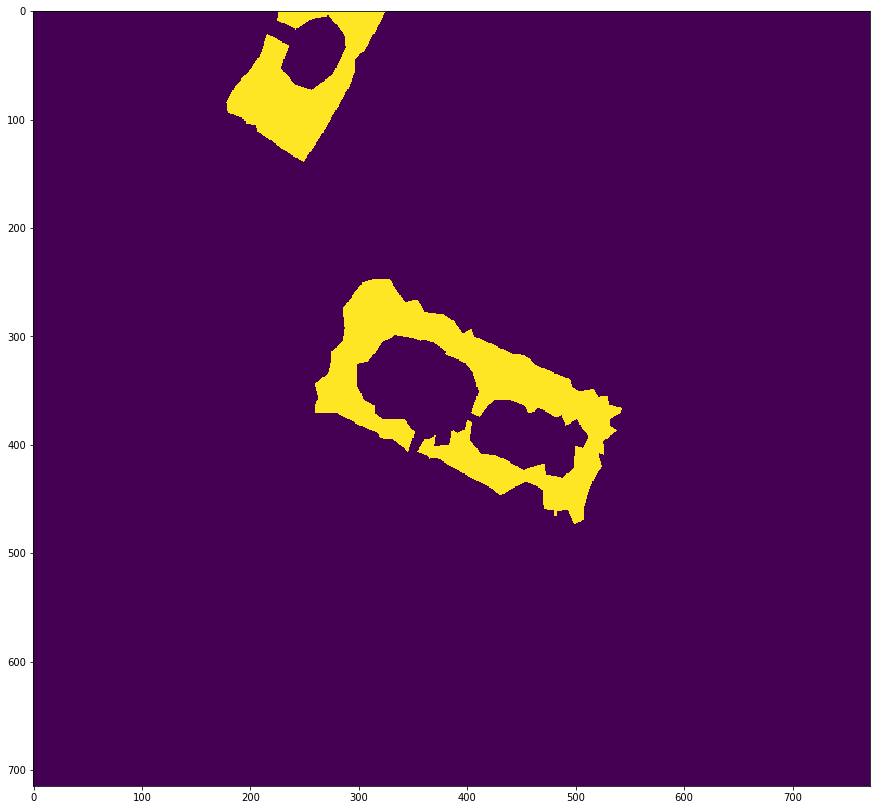

Jakarta_169_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_266_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_266_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_266_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((98.67899 3.49838, 98.67902 3.49839, ...
1  None  POLYGON ((98.67809 3.49893, 98.67814 3.49895, ...


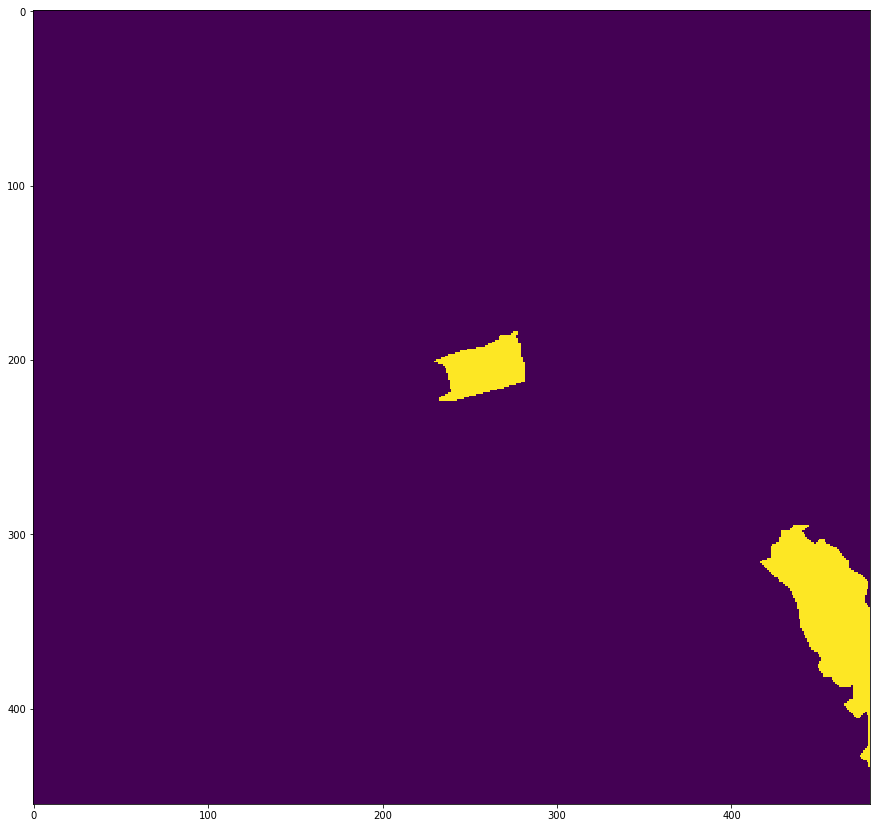

Medan_266_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_364_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_364_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_364_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.58558 -6.29419, 106.58537 -6.294...
1  None  POLYGON ((106.58663 -6.29274, 106.58662 -6.292...
2  None  POLYGON ((106.58596 -6.29448, 106.58608 -6.294...
3  None  POLYGON ((106.58651 -6.29448, 106.58681 -6.294...


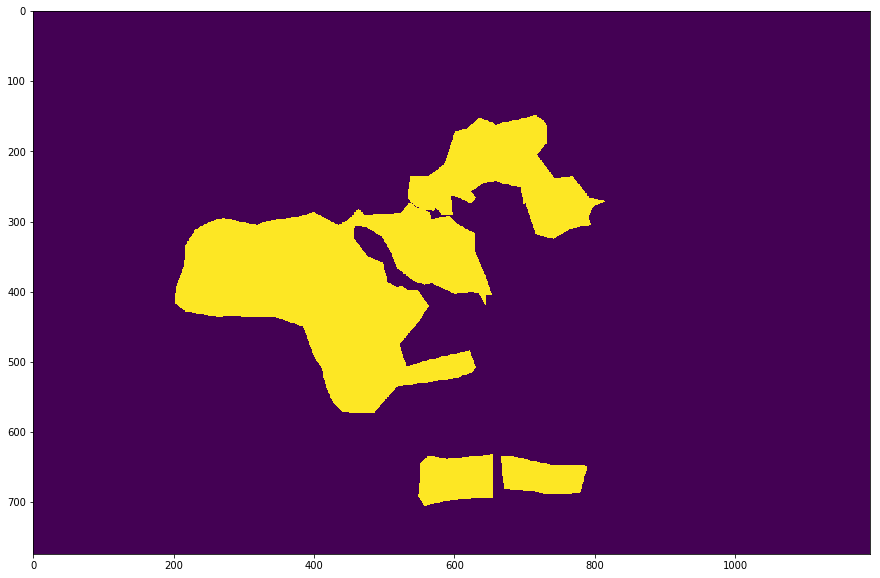

Jakarta_364_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
      id                                           geometry
0   None  POLYGON ((98.66639 3.49030, 98.66643 3.49026, ...
1   None  POLYGON ((98.66633 3.48977, 98.66635 3.48979, ...
2   None  POLYGON ((98.66704 3.49042, 98.66709 3.49047, ...
3   None  POLYGON ((98.66727 3.49068, 98.66736 3.49073, ...
4   None  POLYGON ((98.66784 3.49116, 98.66787 3.49111, ...
5   None  POLYGON ((98.66862 3.49177, 98.66886 3.49177, ...
6   None  POLYGON ((98.667

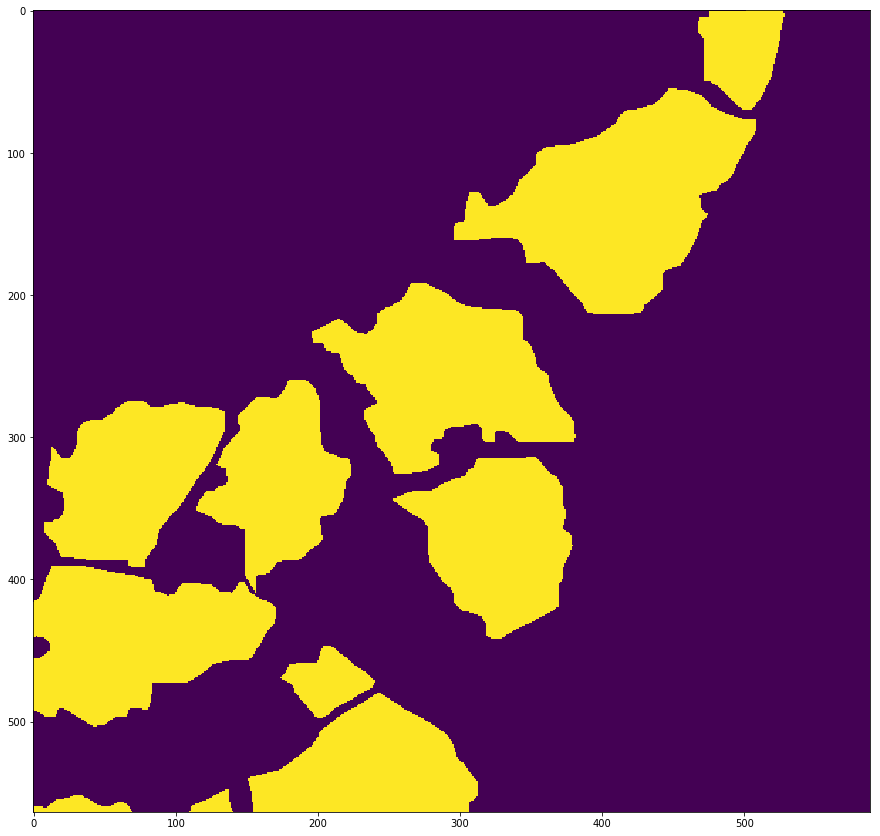

Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Jakarta_112_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_112_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Jakarta_112_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((106.80639 -6.32192, 106.80645 -6.321...


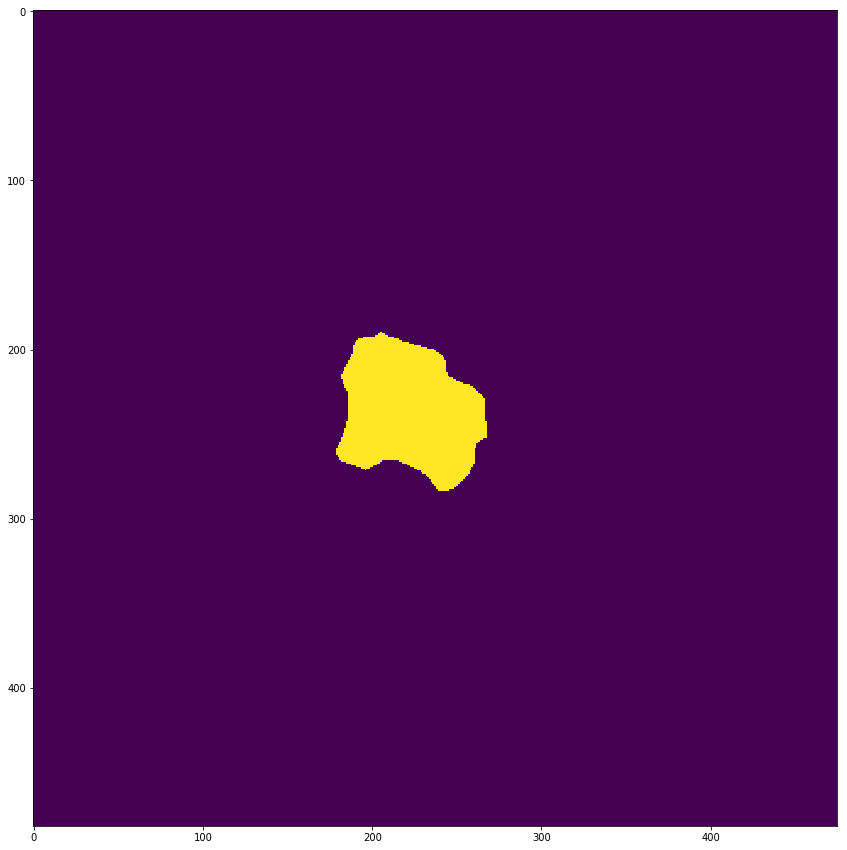

Jakarta_112_pansharpen_True_2019-08-05_03:37_10300100990D7100_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files/Balikpapan_001_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Balikpapan_001_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.shp
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files
Balikpapan_001_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.tif
     id                                           geometry
0  None  POLYGON ((116.95507 -1.22964, 116.95571 -1.229...


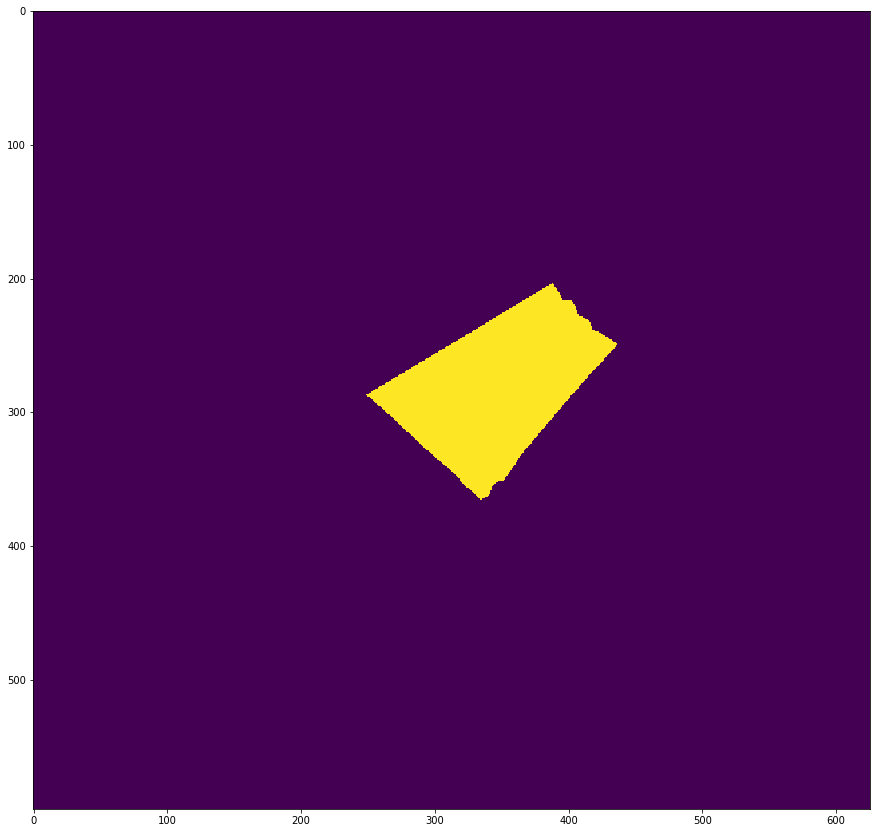

Balikpapan_001_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.shp


In [11]:
shape_files_path = "/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/*.shp"
shape_files = glob.glob(shape_files_path)
raster_files_root_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/raster_files'
mask_files_root_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files'

non_water_shape_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/islands_annotations/*.shp'
non_water_shape_files = glob.glob(non_water_shape_path)

non_water_shape_files = list(map(ntpath.basename,non_water_shape_files))


for shape_file_path in shape_files:
    filename = ntpath.basename(shape_file_path)
    filename = filename.replace('_island','')
    if filename not in non_water_shape_files:
        
        raster_file_path = os.path.join(raster_files_root_path, filename.replace('shp','tif'))
        mask_file_path = os.path.join(mask_files_root_path, filename.replace('shp','tif'))

    #     print(filename)
    #     print(raster_file_path)
    #     print(mask_file_path)
        output_path = Path(mask_file_path)
        generate_mask(raster_path=raster_file_path, shape_path=shape_file_path, output_path=output_path.parent, file_name=filename.replace('shp','tif'))
        print(filename)

# Visualise the Mask Files

/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Medan_216_pansharpen_True_2020-03-03_04:05_10300100A367E500_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Jakarta_500_pansharpen_True_2018-04-03_03:22_103001007C082C00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Cilegon_005_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Jakarta_249_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/D

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Cilegon_007_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Balikpapan_001_pansharpen_True_2019-08-12_02:37_10300100991F2D00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Cilegon_017_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Cilegon_002_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Jakarta_197_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/Denpasar_016_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
/home/ubuntu/sukh_share/water_detection_model/source_data/mask_fil

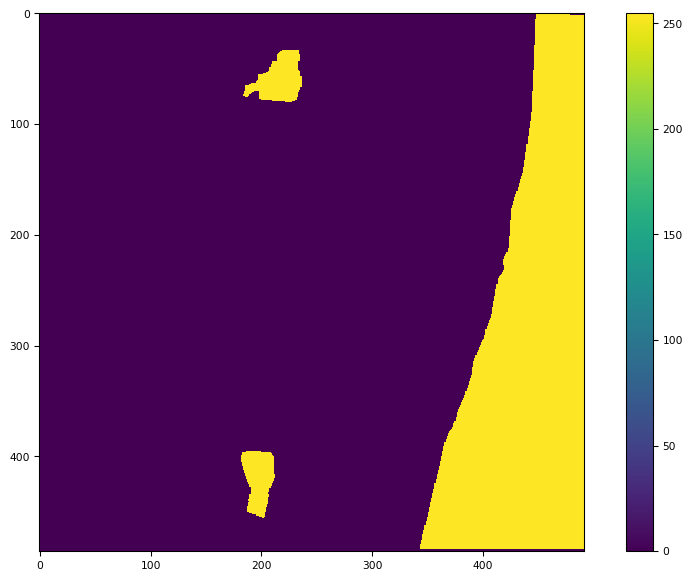

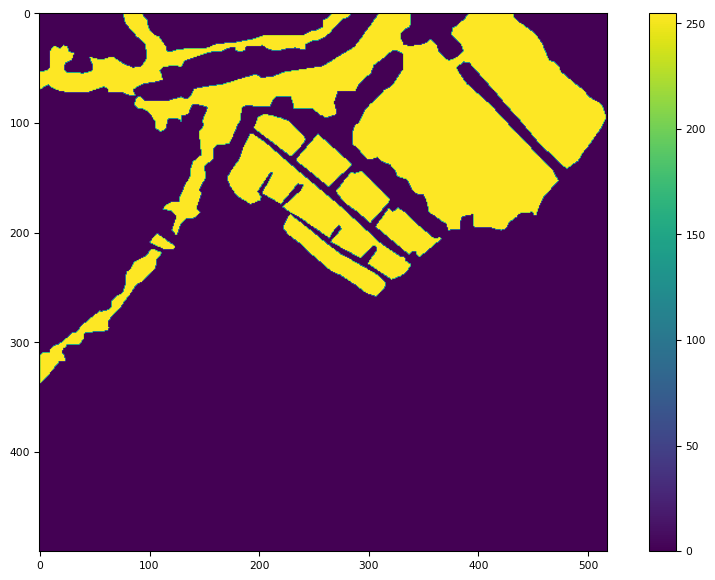

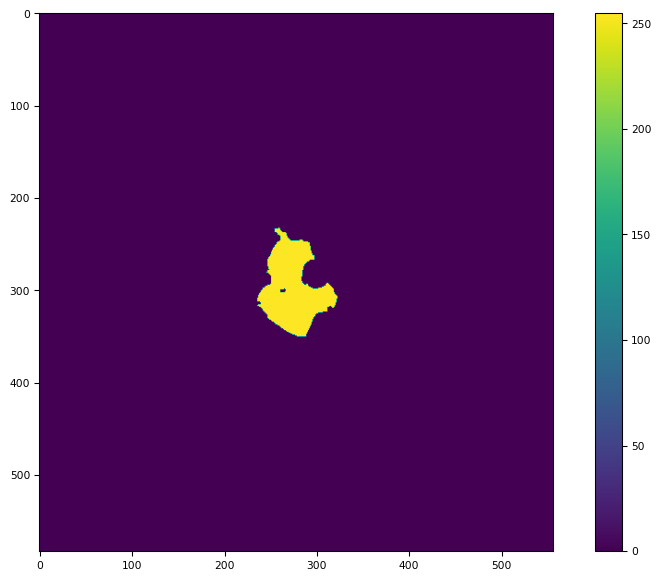

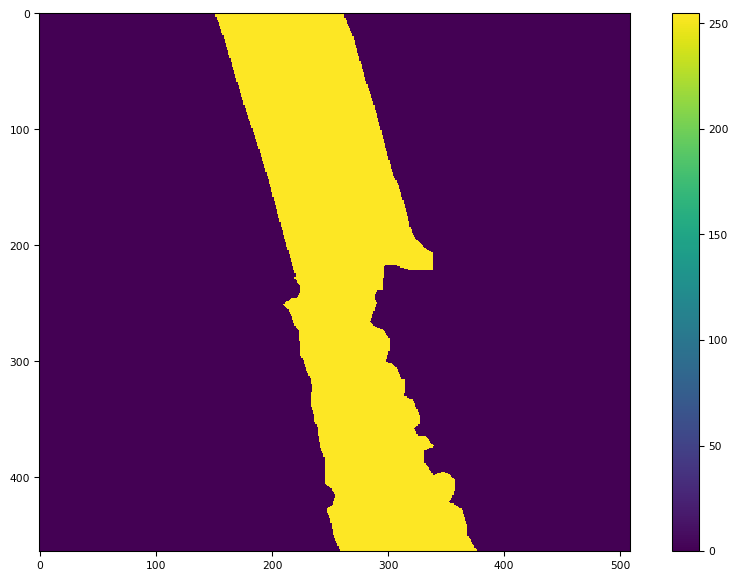

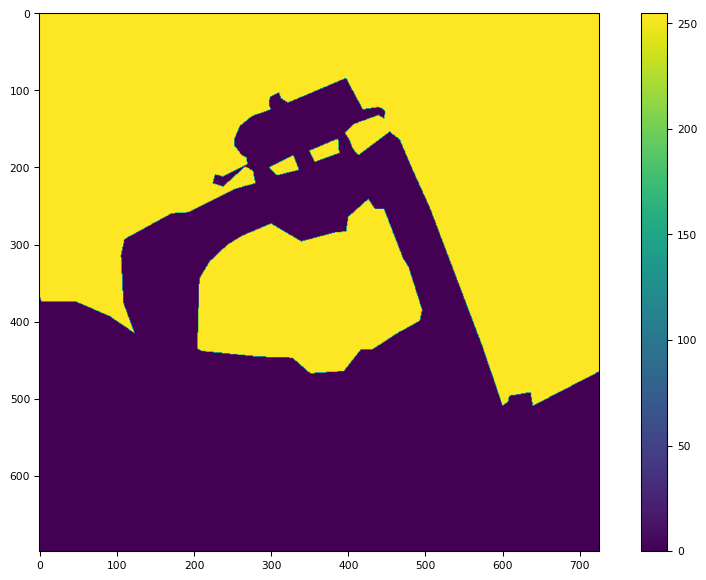

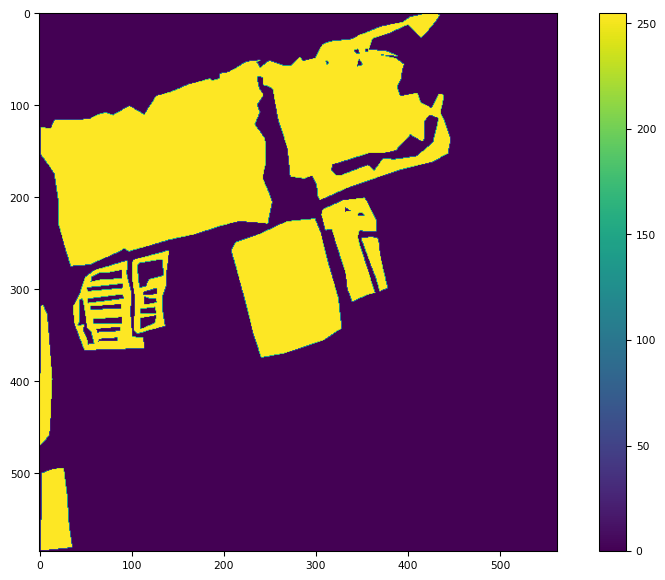

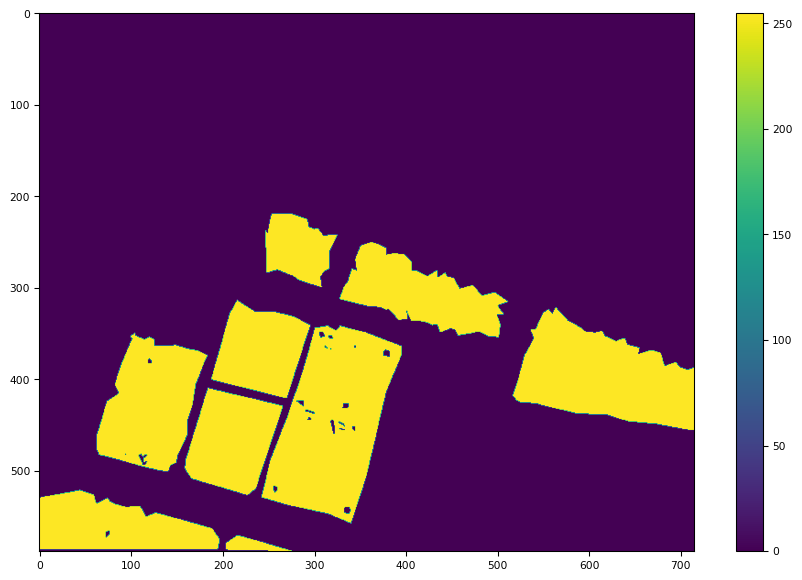

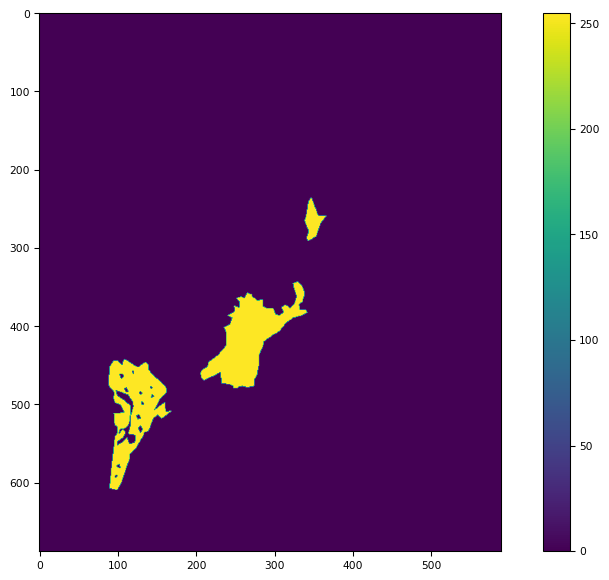

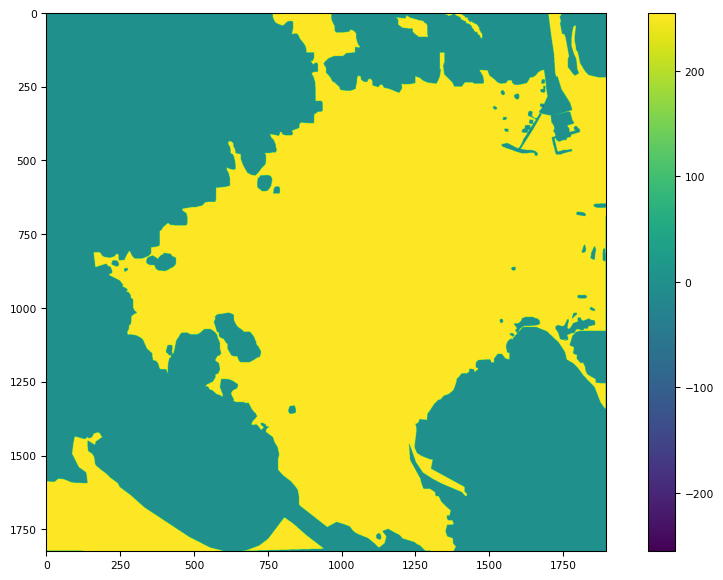

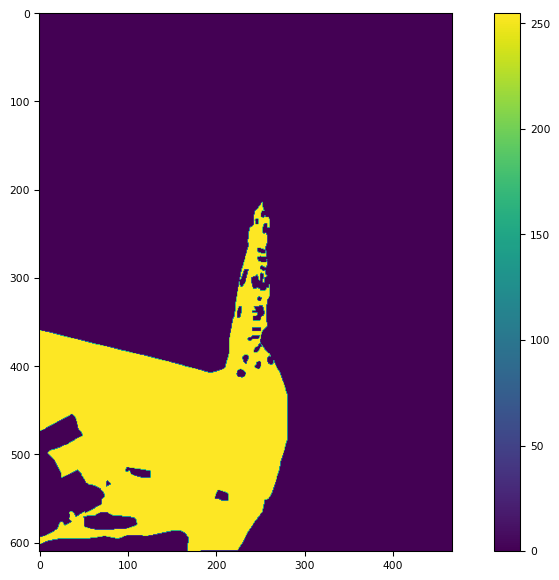

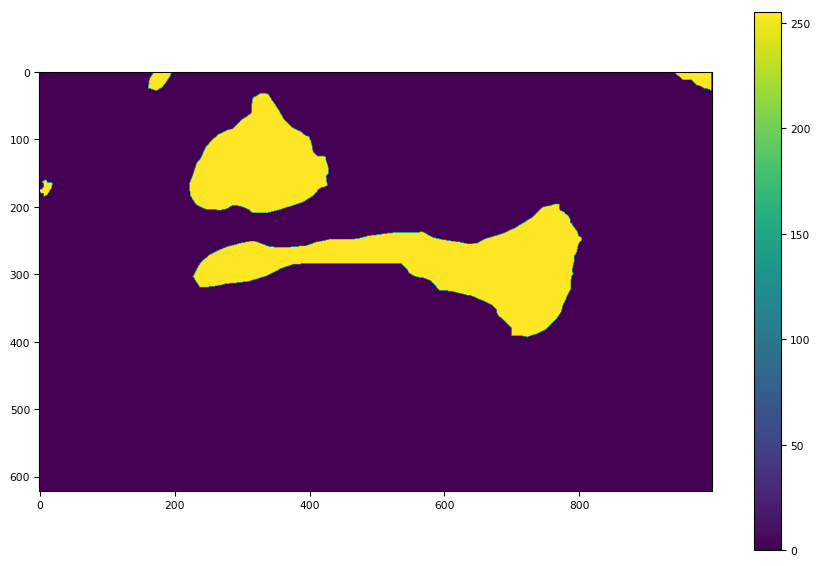

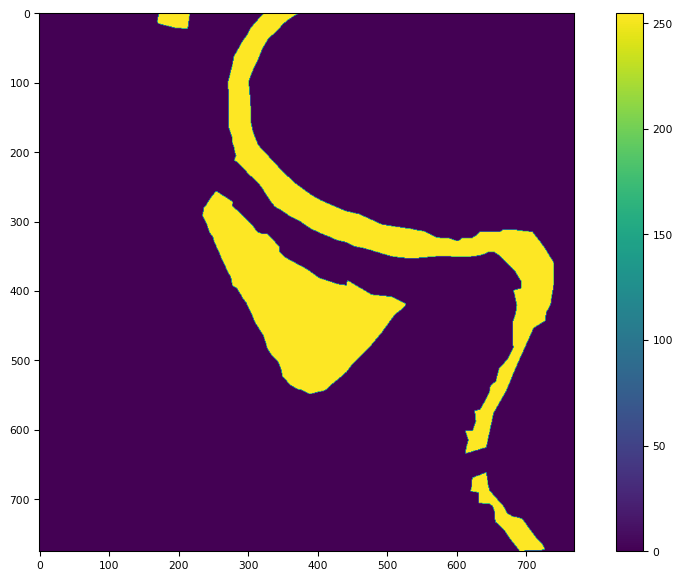

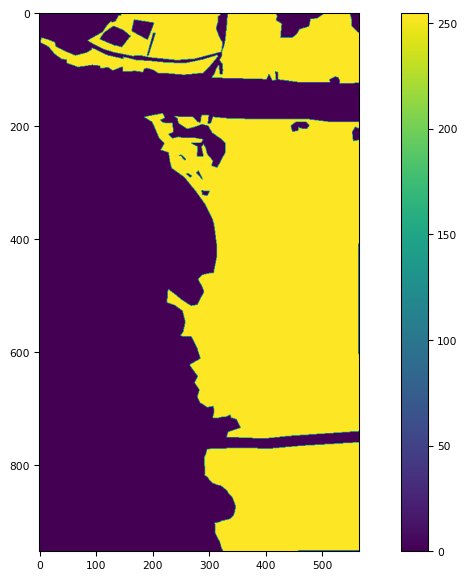

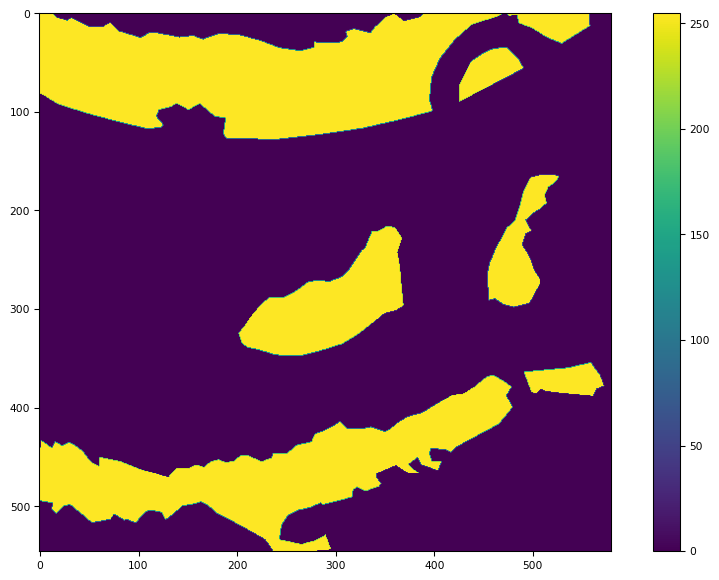

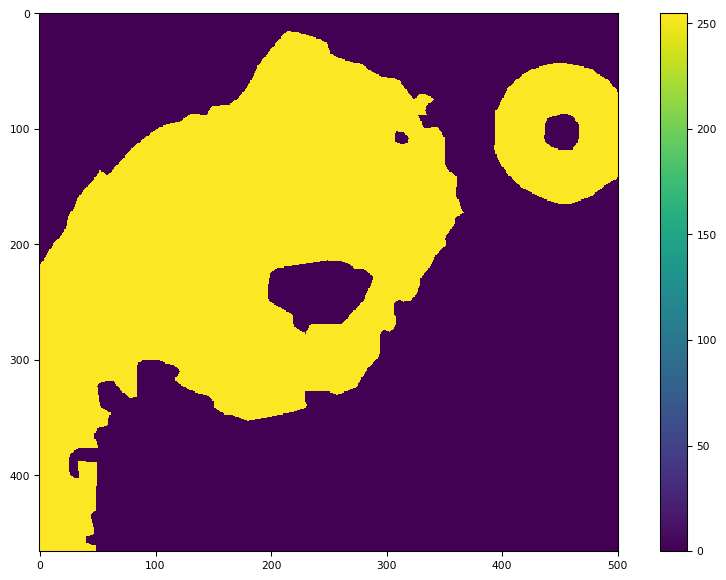

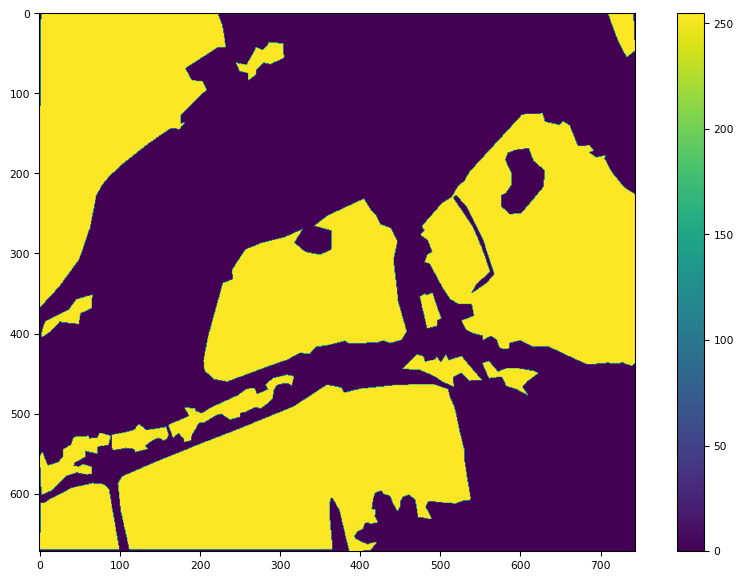

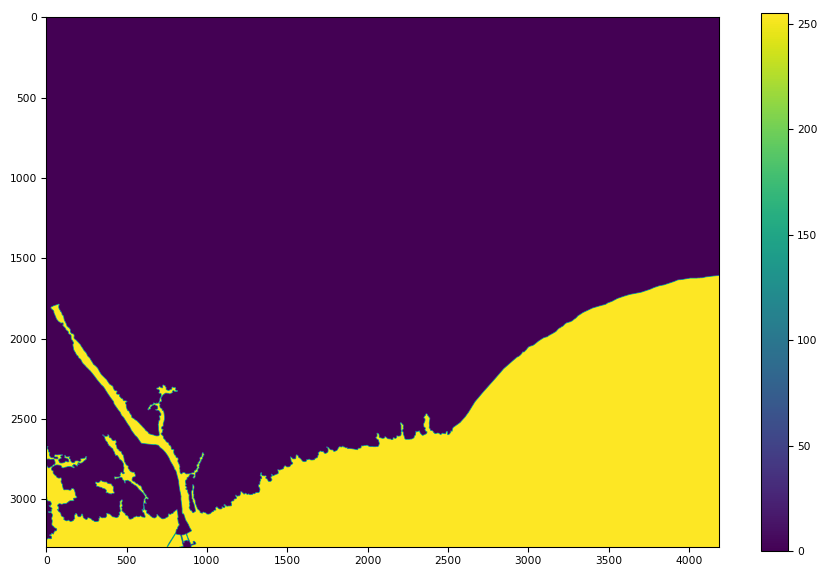

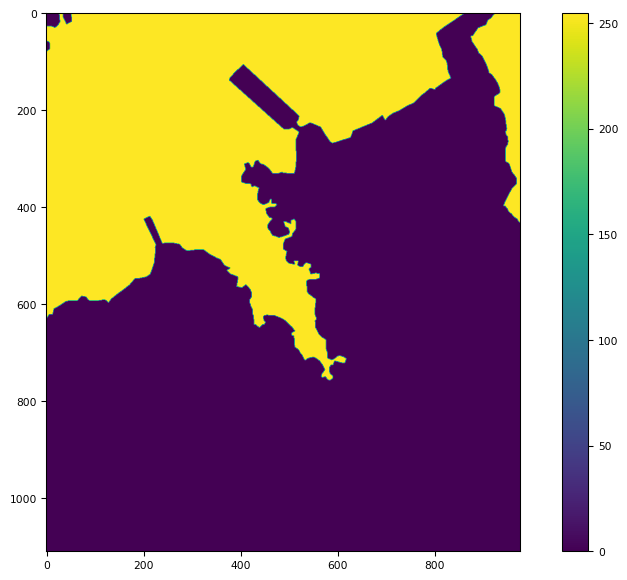

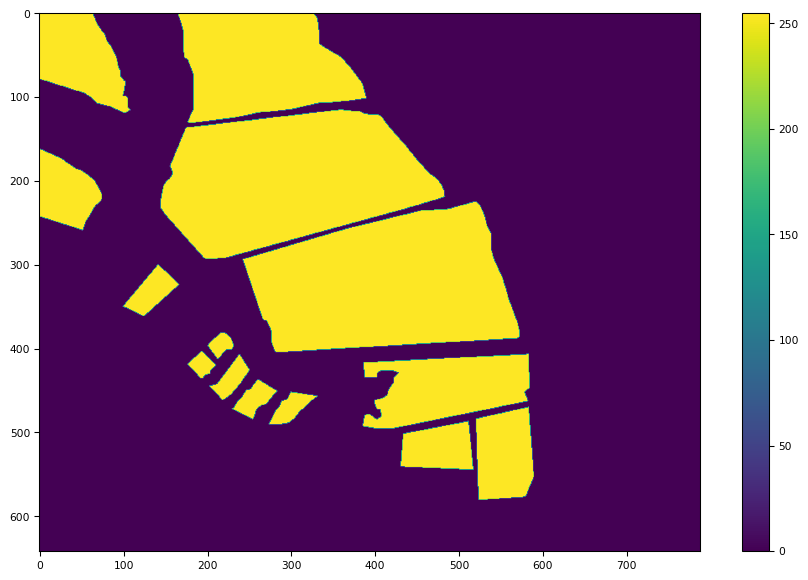

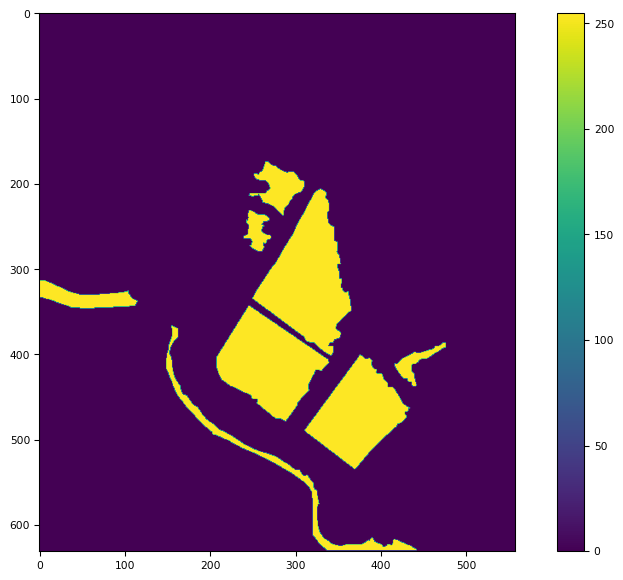

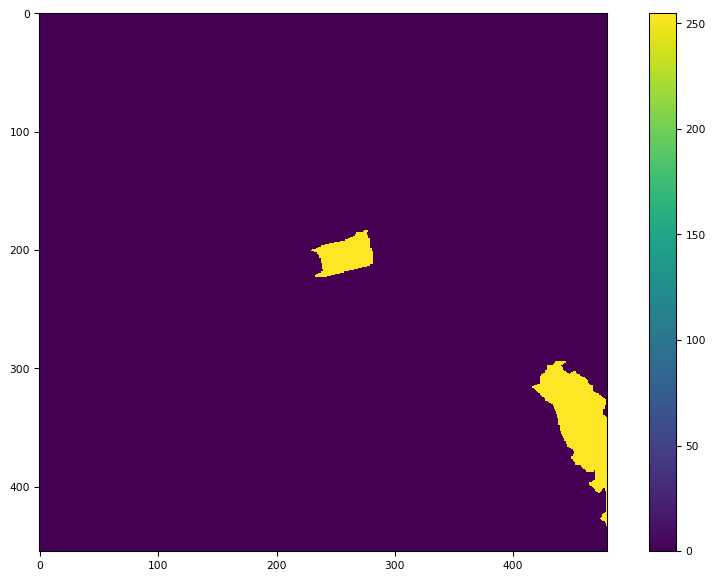

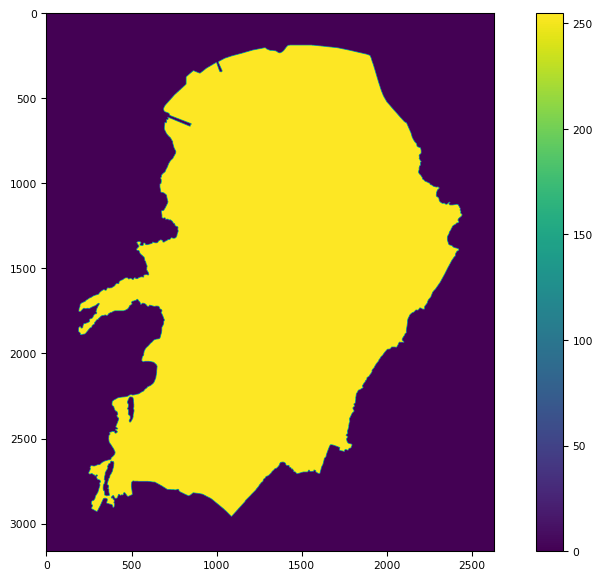

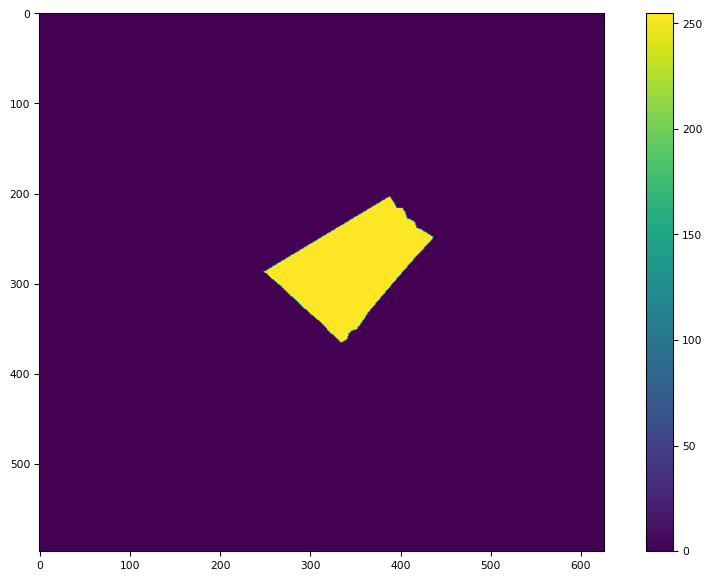

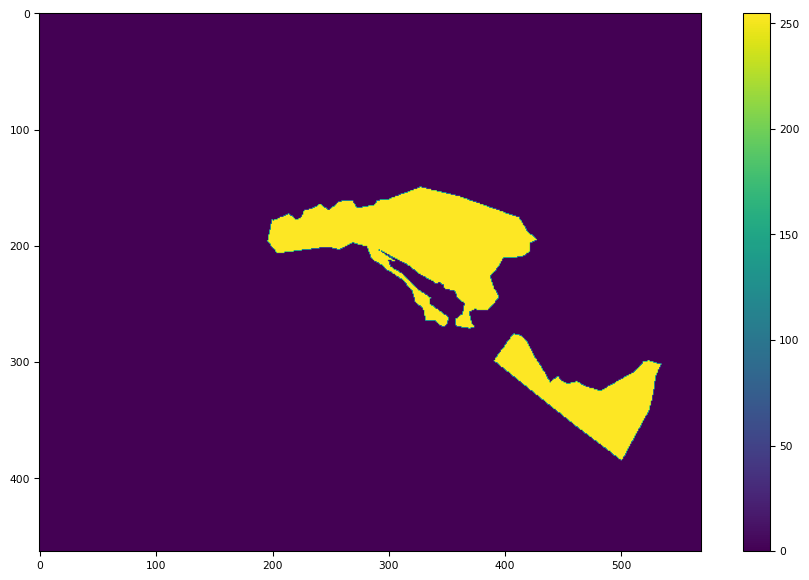

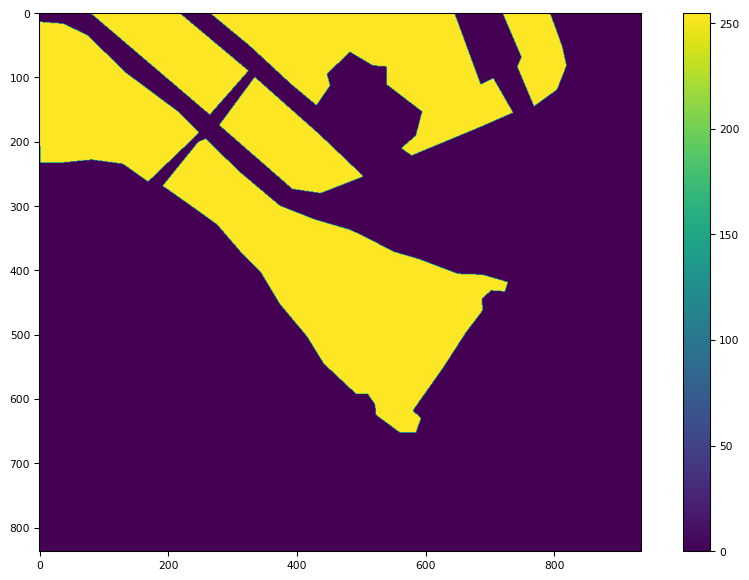

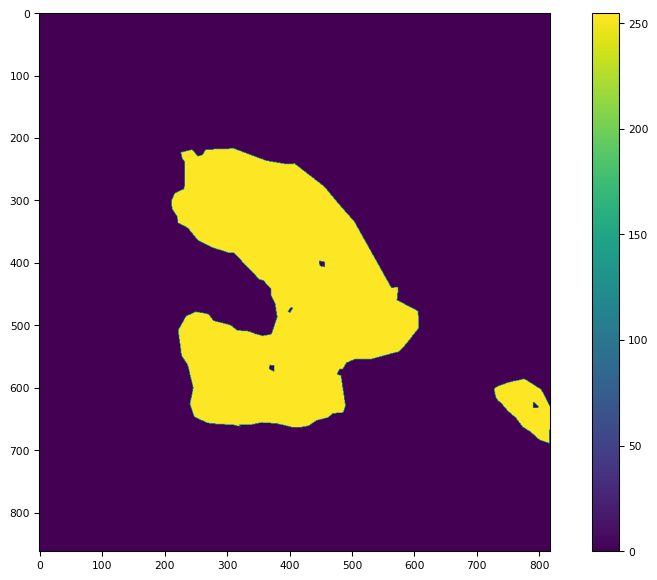

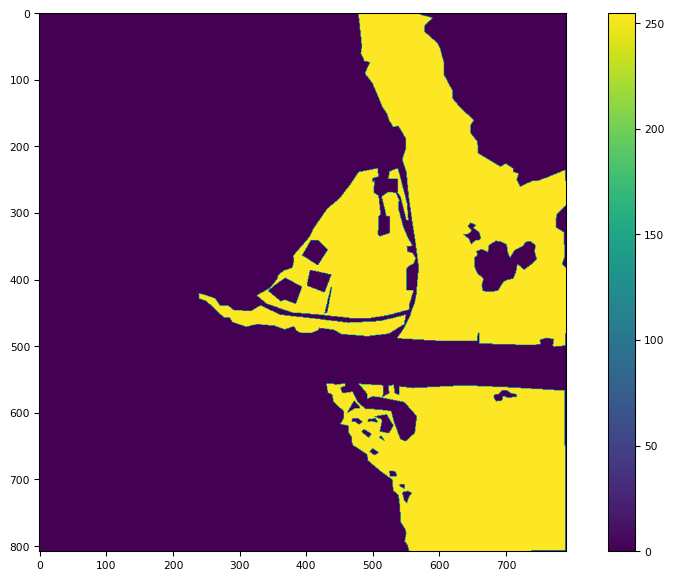

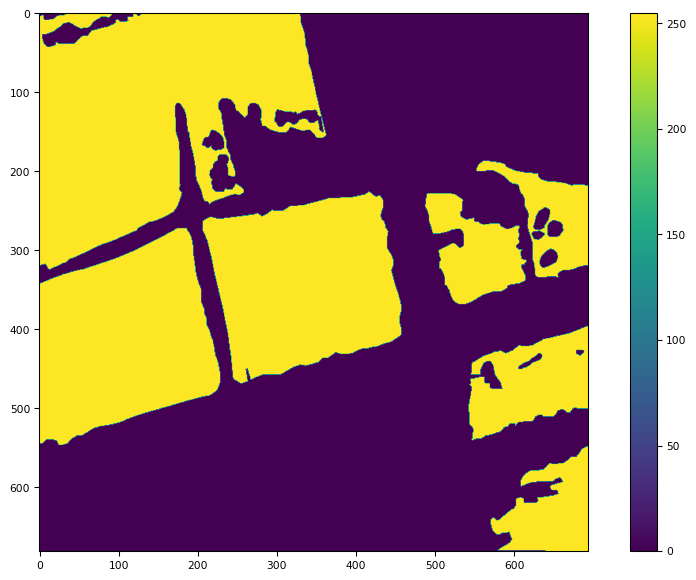

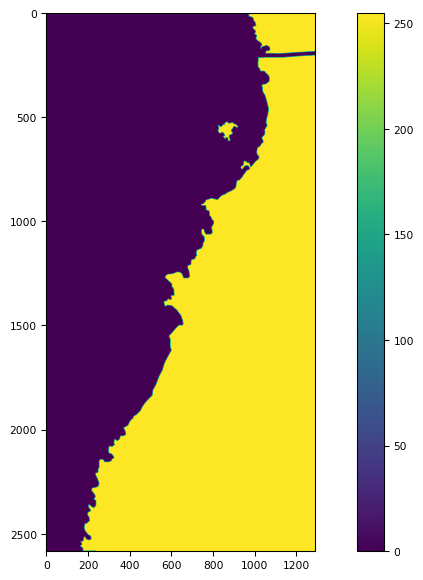

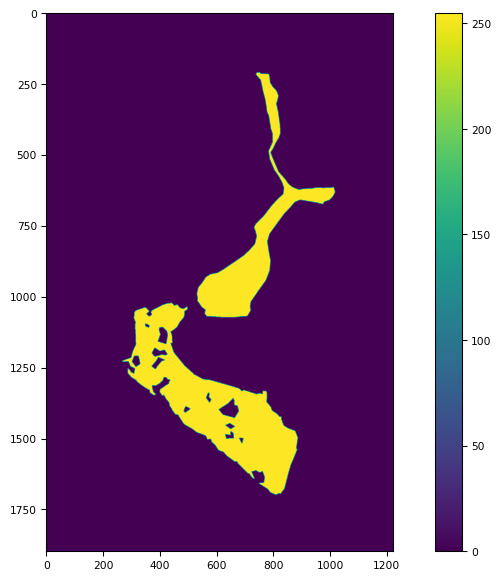

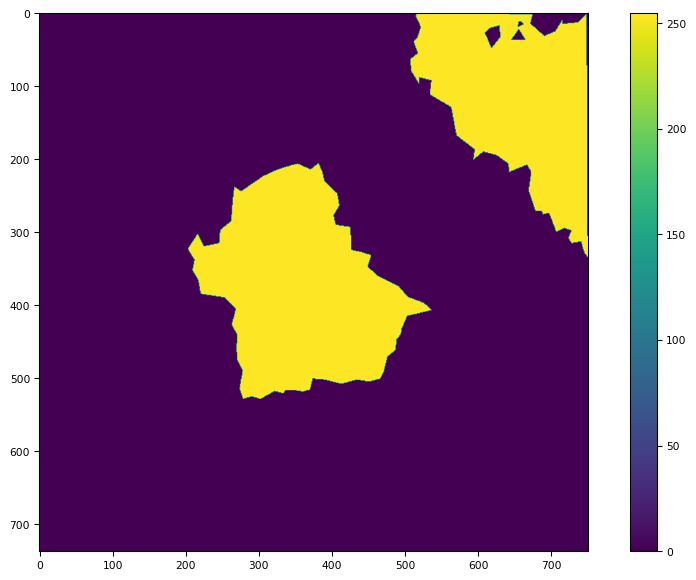

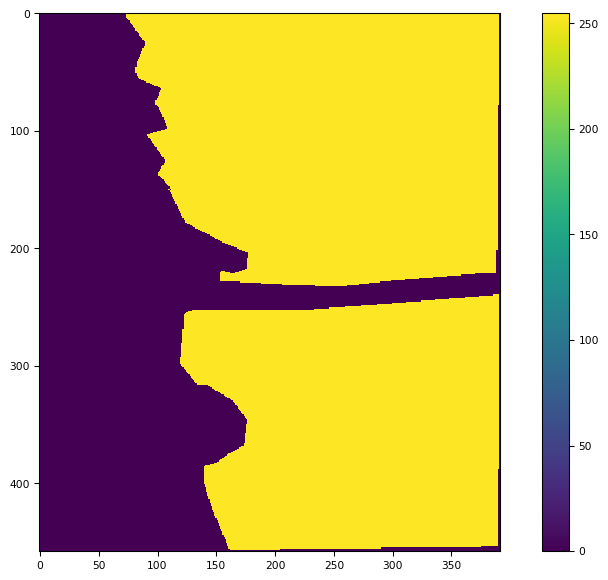

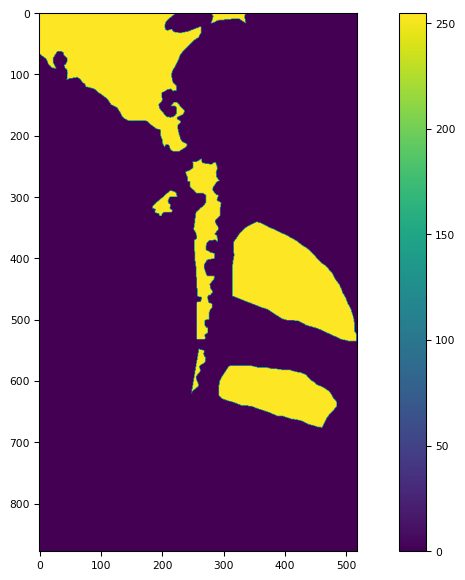

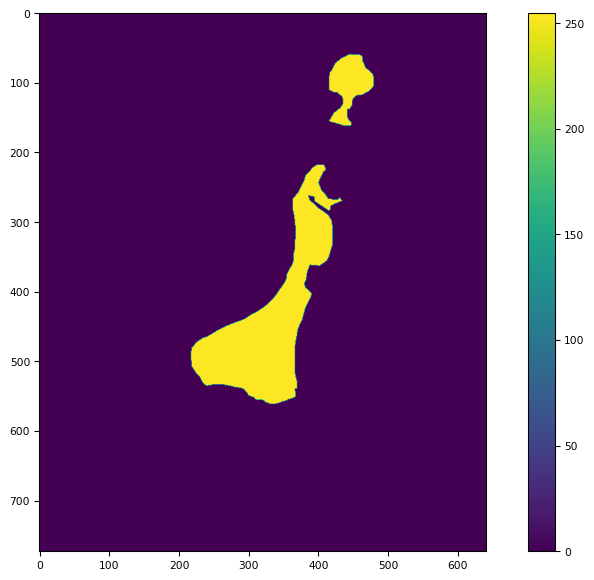

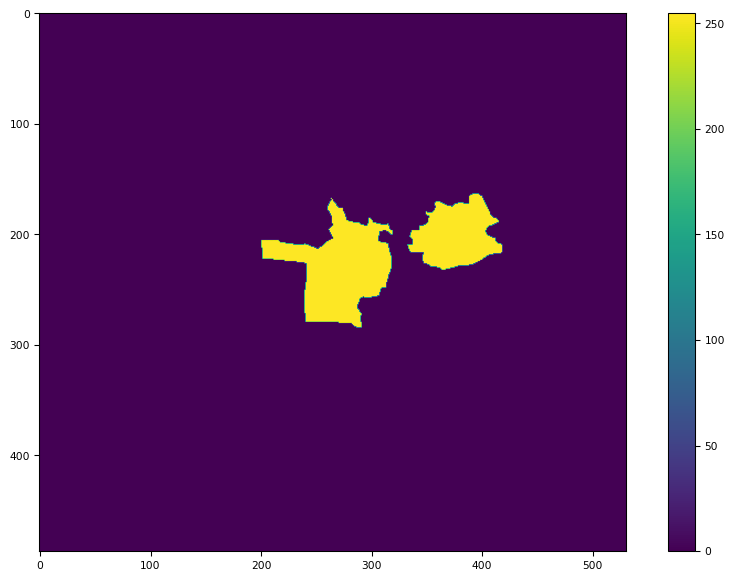

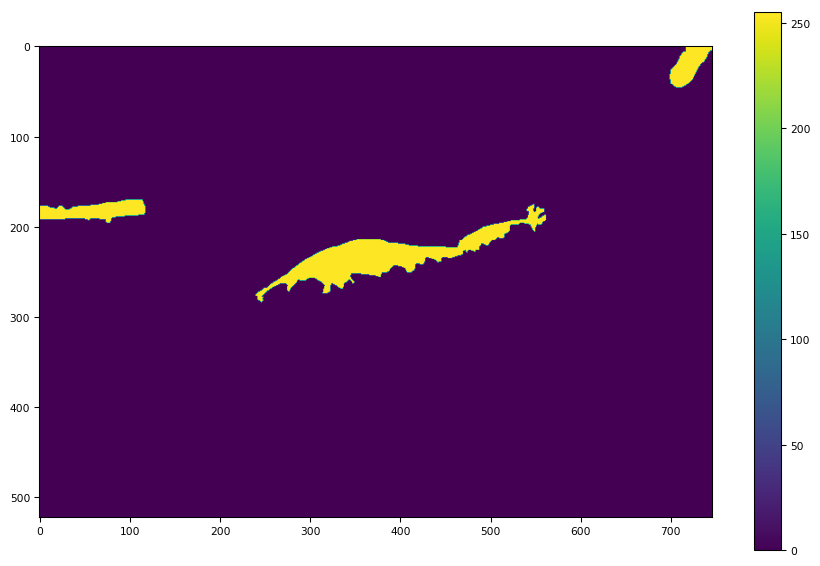

In [25]:
import tifffile as tiff
for mask in glob.glob('/home/ubuntu/sukh_share/water_detection_model/source_data/mask_files/*.tif'):
    img = tiff.imread(mask)
    tiff.imshow(img)
    print(mask)